# **Google Runoff Reanalysis & Reforecast dataset (GRRR) extraction & analysis**

This notebook is complementary to the colab (https://colab.research.google.com/drive/1FnXXSEQqU1TJhMPiNeWUTr9LnbJwZzMm?usp=sharing) which facilitates reading the GRRR.

GRRR consists of hydrologic predictions by Google state-of-the-art (SOTA) hydrologic model, an improved version of the model described in the Nature article (https://www.nature.com/articles/s41586-024-07145-1), with full global coverage and daily resolution. It includes:
* Streamflow reanalysis data for ±1M hybas's (hydrological basin) for 1980 - 2023, on which, too, return period values are based and calculated (the ‘severity threshold levels’ we already knew);
* Streamflow reforecast data for ±1M hybas's for 2016 - 2022, with 7-day lead times.


##### **Step-by-step plan for the analysis:**

- Make a list of all new hybas locations (of interest?). After the update, a **lot** of new stations have been added to FloodHub, 10^2 - 10^3 ish range. To download this manually would be extremely tedious, so maybe Google can help with this. It would be good to automate this for later as well, of course. Maybe there's a way to get all hybas stations in the colab.
- Think of a method (which finishes the downloads and then goes to the next one, or do the analysis in colab) which efficiently handles all data. Then, download all data for the hybases with the colab
- With the data ready, make functions and do the "easy" part: the rest of the analysis

*NB:* Having the "Better Comments" extension installed is adviced for reading some of the comments

##### **Extract Mali data**

In [642]:
import analyse

In [643]:
df_Mali_gauges, df_Mali_gauge_models, df_Mali_forecasts = \
    analyse.get_country_data('Mali','2024-07-08', '2024-10-08', True)

In [644]:
print(df_Mali_gauges['gaugeId'])

0       hybas_1120040380
1       hybas_1120040400
2       hybas_1120040850
3       hybas_1120040860
4       hybas_1120040960
              ...       
1659    hybas_1121945470
1660    hybas_1121947460
1661    hybas_1121947780
1662    hybas_1121948560
1663    hybas_1121948660
Name: gaugeId, Length: 1664, dtype: object


In [645]:
# import pandas as pd

# def print_gauge_IDs(df: pd.DataFrame, width = 1):
#     """
#     Prints the gauge IDs in the dataframe in a pretty format

#     :param df: dataframe containing gauge IDs
#     :param width: width of the columns to print with
#     """
#     print("Mali_hybases = [")
#     for idx in range(0, len(df), width):
#         print("    " + ", ".join([f"'{g}'" for g in df[idx : idx + width]]) + ",")
#     print("]")


# print_gauge_IDs(df_Mali_gauges['gaugeId'], 8)

Replace the comment-block (1) with comment-block (2) for the verified gauges and comment-block (3) for the unverified gauges in addition to comment-block (4) in the colab (of the aforementioned URL) for the Mali data to download locally in the colab environment. Then, (if all processed correctly,) download it manually as a .zip (by converting: ``!zip -r gauge_data.zip /content/gauge_data`` -- and downloading: ``from google.colab import files`` and ``files.download('gauge_data.zip'))``

In [646]:
""" comment-block (1)
gauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()
gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()
gauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()
"""

""" comment-block (2)
Mali_hybases = [
  'hybas_1120641660',
  'hybas_1120650110',
  'hybas_1120661040',
  'hybas_1120679780',
  'hybas_1120689830',
  'hybas_1120705070',
  'hybas_1120737100',
  'hybas_1120739110',
  'hybas_1120758950',
  'hybas_1120766460',
  'hybas_1121890140',
  'hybas_1121893090',
  'hybas_1121895840',
  'hybas_1121900350',
  'hybas_1121905290',
  'hybas_1121919510'
]
"""
""" comment-block (3)
Mali_hybases = [
    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041110', 'hybas_1120041510', 'hybas_1120041730',
    'hybas_1120043640', 'hybas_1120303190', 'hybas_1120303810', 'hybas_1120397600', 'hybas_1120410560', 'hybas_1120411350', 'hybas_1120412240', 'hybas_1120429260',
    'hybas_1120432960', 'hybas_1120466750', 'hybas_1120470630', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471950', 'hybas_1120471970', 'hybas_1120472120',
    'hybas_1120472270', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120473940', 'hybas_1120475600', 'hybas_1120477150', 'hybas_1120477170', 'hybas_1120478130',
    'hybas_1120479380', 'hybas_1120479830', 'hybas_1120481330', 'hybas_1120482130', 'hybas_1120483990', 'hybas_1120484930', 'hybas_1120487900', 'hybas_1120488260',
    'hybas_1120491030', 'hybas_1120491690', 'hybas_1120492490', 'hybas_1120493530', 'hybas_1120494590', 'hybas_1120496140', 'hybas_1120498360', 'hybas_1120504370',
    'hybas_1120504470', 'hybas_1120504640', 'hybas_1120505610', 'hybas_1120509630', 'hybas_1120510390', 'hybas_1120510890', 'hybas_1120512060', 'hybas_1120512280',
    'hybas_1120512460', 'hybas_1120513470', 'hybas_1120515750', 'hybas_1120517670', 'hybas_1120518390', 'hybas_1120518600', 'hybas_1120519840', 'hybas_1120520690',
    'hybas_1120520940', 'hybas_1120521780', 'hybas_1120522540', 'hybas_1120523280', 'hybas_1120523380', 'hybas_1120523420', 'hybas_1120523620', 'hybas_1120523630',
    'hybas_1120524850', 'hybas_1120525450', 'hybas_1120525650', 'hybas_1120527140', 'hybas_1120527350', 'hybas_1120527680', 'hybas_1120528640', 'hybas_1120529240',
    'hybas_1120529440', 'hybas_1120529940', 'hybas_1120530060', 'hybas_1120530160', 'hybas_1120530300', 'hybas_1120531120', 'hybas_1120531460', 'hybas_1120531880',
    'hybas_1120532050', 'hybas_1120532230', 'hybas_1120532750', 'hybas_1120532960', 'hybas_1120533300', 'hybas_1120533310', 'hybas_1120533700', 'hybas_1120533720',
    'hybas_1120533810', 'hybas_1120534130', 'hybas_1120534140', 'hybas_1120536810', 'hybas_1120538130', 'hybas_1120538290', 'hybas_1120539270', 'hybas_1120540030',
    'hybas_1120540480', 'hybas_1120540500', 'hybas_1120540680', 'hybas_1120540820', 'hybas_1120540830', 'hybas_1120544610', 'hybas_1120545390', 'hybas_1120545620',
    'hybas_1120547920', 'hybas_1120547940', 'hybas_1120548470', 'hybas_1120549740', 'hybas_1120550010', 'hybas_1120550020', 'hybas_1120550030', 'hybas_1120550230',
    'hybas_1120550380', 'hybas_1120550540', 'hybas_1120550770', 'hybas_1120550780', 'hybas_1120551370', 'hybas_1120551410', 'hybas_1120551560', 'hybas_1120551770',
    'hybas_1120551780', 'hybas_1120552270', 'hybas_1120552280', 'hybas_1120552460', 'hybas_1120552650', 'hybas_1120553250', 'hybas_1120553570', 'hybas_1120553740',
    'hybas_1120553750', 'hybas_1120554320', 'hybas_1120554770', 'hybas_1120554930', 'hybas_1120554940', 'hybas_1120555140', 'hybas_1120555550', 'hybas_1120555730',
    'hybas_1120556160', 'hybas_1120556480', 'hybas_1120556700', 'hybas_1120556990', 'hybas_1120557110', 'hybas_1120557170', 'hybas_1120557770', 'hybas_1120557870',
    'hybas_1120558440', 'hybas_1120558570', 'hybas_1120558910', 'hybas_1120559030', 'hybas_1120559430', 'hybas_1120559460', 'hybas_1120559600', 'hybas_1120559630',
    'hybas_1120560050', 'hybas_1120560230', 'hybas_1120560390', 'hybas_1120560420', 'hybas_1120560430', 'hybas_1120560650', 'hybas_1120561470', 'hybas_1120561650',
    'hybas_1120561810', 'hybas_1120561830', 'hybas_1120562900', 'hybas_1120562920', 'hybas_1120563590', 'hybas_1120563820', 'hybas_1120564590', 'hybas_1120564740',
    'hybas_1120564860', 'hybas_1120564960', 'hybas_1120564980', 'hybas_1120565220', 'hybas_1120565330', 'hybas_1120565450', 'hybas_1120565570', 'hybas_1120565730',
    'hybas_1120565890', 'hybas_1120565930', 'hybas_1120566540', 'hybas_1120566570', 'hybas_1120566910', 'hybas_1120567030', 'hybas_1120567200', 'hybas_1120567210',
    'hybas_1120567350', 'hybas_1120567380', 'hybas_1120567860', 'hybas_1120567870', 'hybas_1120567880', 'hybas_1120568290', 'hybas_1120568530', 'hybas_1120568560',
    'hybas_1120568750', 'hybas_1120568760', 'hybas_1120569130', 'hybas_1120569140', 'hybas_1120569160', 'hybas_1120569550', 'hybas_1120569730', 'hybas_1120570200',
    'hybas_1120570310', 'hybas_1120570840', 'hybas_1120571020', 'hybas_1120571170', 'hybas_1120571190', 'hybas_1120571210', 'hybas_1120571400', 'hybas_1120571780',
    'hybas_1120571790', 'hybas_1120571810', 'hybas_1120571920', 'hybas_1120572020', 'hybas_1120572030', 'hybas_1120572190', 'hybas_1120572200', 'hybas_1120572390',
    'hybas_1120572870', 'hybas_1120573290', 'hybas_1120573670', 'hybas_1120574720', 'hybas_1120574930', 'hybas_1120575020', 'hybas_1120575340', 'hybas_1120575820',
    'hybas_1120575840', 'hybas_1120576250', 'hybas_1120576260', 'hybas_1120576370', 'hybas_1120576380', 'hybas_1120576510', 'hybas_1120577130', 'hybas_1120577220',
    'hybas_1120577230', 'hybas_1120577590', 'hybas_1120577630', 'hybas_1120577750', 'hybas_1120577880', 'hybas_1120578220', 'hybas_1120579520', 'hybas_1120580940',
    'hybas_1120581610', 'hybas_1120582050', 'hybas_1120582390', 'hybas_1120582680', 'hybas_1120582840', 'hybas_1120582940', 'hybas_1120582950', 'hybas_1120583150',
    'hybas_1120583620', 'hybas_1120583640', 'hybas_1120584260', 'hybas_1120584350', 'hybas_1120584360', 'hybas_1120584370', 'hybas_1120584500', 'hybas_1120585080',
    'hybas_1120585100', 'hybas_1120585450', 'hybas_1120585480', 'hybas_1120585920', 'hybas_1120586040', 'hybas_1120586210', 'hybas_1120587030', 'hybas_1120587040',
    'hybas_1120587440', 'hybas_1120587780', 'hybas_1120587790', 'hybas_1120587880', 'hybas_1120588270', 'hybas_1120588310', 'hybas_1120588700', 'hybas_1120588980',
    'hybas_1120589130', 'hybas_1120589730', 'hybas_1120589740', 'hybas_1120589750', 'hybas_1120590180', 'hybas_1120590190', 'hybas_1120590750', 'hybas_1120591050',
    'hybas_1120591190', 'hybas_1120591200', 'hybas_1120591220', 'hybas_1120591420', 'hybas_1120591560', 'hybas_1120591740', 'hybas_1120591770', 'hybas_1120592240',
    'hybas_1120592250', 'hybas_1120592350', 'hybas_1120592790', 'hybas_1120593030', 'hybas_1120593040', 'hybas_1120593050', 'hybas_1120593470', 'hybas_1120594180',
    'hybas_1120594190', 'hybas_1120594490', 'hybas_1120594520', 'hybas_1120595390', 'hybas_1120595410', 'hybas_1120595660', 'hybas_1120595690', 'hybas_1120595820',
    'hybas_1120595960', 'hybas_1120596090', 'hybas_1120596100', 'hybas_1120596260', 'hybas_1120596300', 'hybas_1120596680', 'hybas_1120596900', 'hybas_1120596910',
    'hybas_1120597170', 'hybas_1120597370', 'hybas_1120597480', 'hybas_1120597500', 'hybas_1120597890', 'hybas_1120598090', 'hybas_1120598250', 'hybas_1120598480',
    'hybas_1120599220', 'hybas_1120599600', 'hybas_1120599620', 'hybas_1120600140', 'hybas_1120600480', 'hybas_1120600830', 'hybas_1120601080', 'hybas_1120601110',
    'hybas_1120601830', 'hybas_1120602200', 'hybas_1120602230', 'hybas_1120602680', 'hybas_1120602870', 'hybas_1120603030', 'hybas_1120603340', 'hybas_1120603370',
    'hybas_1120603580', 'hybas_1120603600', 'hybas_1120603890', 'hybas_1120603910', 'hybas_1120604170', 'hybas_1120604190', 'hybas_1120604370', 'hybas_1120604770',
    'hybas_1120605370', 'hybas_1120605610', 'hybas_1120605720', 'hybas_1120605730', 'hybas_1120605790', 'hybas_1120605800', 'hybas_1120605930', 'hybas_1120606420',
    'hybas_1120606590', 'hybas_1120606620', 'hybas_1120606800', 'hybas_1120606910', 'hybas_1120606920', 'hybas_1120607100', 'hybas_1120607120', 'hybas_1120607270',
    'hybas_1120608260', 'hybas_1120608270', 'hybas_1120608280', 'hybas_1120608450', 'hybas_1120609020', 'hybas_1120609100', 'hybas_1120609250', 'hybas_1120609270',
    'hybas_1120609400', 'hybas_1120609580', 'hybas_1120609590', 'hybas_1120609790', 'hybas_1120609940', 'hybas_1120609950', 'hybas_1120610400', 'hybas_1120610540',
    'hybas_1120610710', 'hybas_1120610850', 'hybas_1120611050', 'hybas_1120611180', 'hybas_1120611190', 'hybas_1120611200', 'hybas_1120611650', 'hybas_1120611660',
    'hybas_1120612020', 'hybas_1120612370', 'hybas_1120613290', 'hybas_1120613300', 'hybas_1120613430', 'hybas_1120613460', 'hybas_1120614120', 'hybas_1120614290',
    'hybas_1120614820', 'hybas_1120614850', 'hybas_1120614860', 'hybas_1120615070', 'hybas_1120615200', 'hybas_1120615740', 'hybas_1120616130', 'hybas_1120616150',
    'hybas_1120616250', 'hybas_1120616410', 'hybas_1120616420', 'hybas_1120616500', 'hybas_1120616670', 'hybas_1120616690', 'hybas_1120616700', 'hybas_1120617070',
    'hybas_1120617160', 'hybas_1120617360', 'hybas_1120617570', 'hybas_1120617870', 'hybas_1120617880', 'hybas_1120617930', 'hybas_1120618270', 'hybas_1120618560',
    'hybas_1120618570', 'hybas_1120618670', 'hybas_1120618790', 'hybas_1120618800', 'hybas_1120619400', 'hybas_1120619810', 'hybas_1120619820', 'hybas_1120619920',
    'hybas_1120619930', 'hybas_1120620140', 'hybas_1120620420', 'hybas_1120620550', 'hybas_1120620950', 'hybas_1120620980', 'hybas_1120621160', 'hybas_1120621340',
    'hybas_1120621490', 'hybas_1120621510', 'hybas_1120621520', 'hybas_1120621820', 'hybas_1120621980', 'hybas_1120622370', 'hybas_1120622540', 'hybas_1120623020',
    'hybas_1120623040', 'hybas_1120623900', 'hybas_1120623920', 'hybas_1120623930', 'hybas_1120624050', 'hybas_1120624420', 'hybas_1120624560', 'hybas_1120624690',
    'hybas_1120624700', 'hybas_1120624920', 'hybas_1120625000', 'hybas_1120625010', 'hybas_1120625310', 'hybas_1120625570', 'hybas_1120625970', 'hybas_1120626120',
    'hybas_1120626130', 'hybas_1120626240', 'hybas_1120626260', 'hybas_1120626430', 'hybas_1120626460', 'hybas_1120626560', 'hybas_1120626670', 'hybas_1120626700',
    'hybas_1120626730', 'hybas_1120626740', 'hybas_1120626870', 'hybas_1120627060', 'hybas_1120627170', 'hybas_1120627280', 'hybas_1120627290', 'hybas_1120627430',
    'hybas_1120627450', 'hybas_1120627460', 'hybas_1120627470', 'hybas_1120627480', 'hybas_1120627660', 'hybas_1120627670', 'hybas_1120627850', 'hybas_1120627860',
    'hybas_1120627960', 'hybas_1120627980', 'hybas_1120628110', 'hybas_1120628120', 'hybas_1120628260', 'hybas_1120628330', 'hybas_1120628350', 'hybas_1120628510',
    'hybas_1120628520', 'hybas_1120628530', 'hybas_1120628540', 'hybas_1120628550', 'hybas_1120628680', 'hybas_1120628730', 'hybas_1120629420', 'hybas_1120629430',
    'hybas_1120630150', 'hybas_1120630290', 'hybas_1120630440', 'hybas_1120630620', 'hybas_1120630640', 'hybas_1120630800', 'hybas_1120630930', 'hybas_1120631400',
    'hybas_1120631550', 'hybas_1120631730', 'hybas_1120631740', 'hybas_1120631890', 'hybas_1120632060', 'hybas_1120632070', 'hybas_1120632490', 'hybas_1120632620',
    'hybas_1120632630', 'hybas_1120633370', 'hybas_1120633580', 'hybas_1120633600', 'hybas_1120634230', 'hybas_1120634240', 'hybas_1120634440', 'hybas_1120634800',
    'hybas_1120634810', 'hybas_1120635400', 'hybas_1120635720', 'hybas_1120635740', 'hybas_1120636080', 'hybas_1120636160', 'hybas_1120636170', 'hybas_1120636660',
    'hybas_1120636820', 'hybas_1120636970', 'hybas_1120637330', 'hybas_1120637340', 'hybas_1120637510', 'hybas_1120637690', 'hybas_1120637880', 'hybas_1120638180',
    'hybas_1120638320', 'hybas_1120638470', 'hybas_1120638490', 'hybas_1120638510', 'hybas_1120638530', 'hybas_1120638640', 'hybas_1120638930', 'hybas_1120639070',
    'hybas_1120639310', 'hybas_1120639320', 'hybas_1120639330', 'hybas_1120639350', 'hybas_1120639370', 'hybas_1120639480', 'hybas_1120639620', 'hybas_1120639840',
    'hybas_1120639850', 'hybas_1120639990', 'hybas_1120640000', 'hybas_1120640160', 'hybas_1120640190', 'hybas_1120640350', 'hybas_1120640370', 'hybas_1120640580',
    'hybas_1120640680', 'hybas_1120640840', 'hybas_1120641440', 'hybas_1120641630', 'hybas_1120641640', 'hybas_1120641660', 'hybas_1120641680', 'hybas_1120642000',
    'hybas_1120642010', 'hybas_1120642020', 'hybas_1120642140', 'hybas_1120642160', 'hybas_1120642490', 'hybas_1120642990', 'hybas_1120643020', 'hybas_1120643170',
    'hybas_1120643390', 'hybas_1120643540', 'hybas_1120643800', 'hybas_1120643820', 'hybas_1120643950', 'hybas_1120644110', 'hybas_1120644270', 'hybas_1120644470',
    'hybas_1120644480', 'hybas_1120644490', 'hybas_1120644500', 'hybas_1120644510', 'hybas_1120644620', 'hybas_1120644920', 'hybas_1120645180', 'hybas_1120645190',
    'hybas_1120645630', 'hybas_1120645770', 'hybas_1120646000', 'hybas_1120646230', 'hybas_1120646630', 'hybas_1120646780', 'hybas_1120646950', 'hybas_1120646960',
    'hybas_1120646970', 'hybas_1120647210', 'hybas_1120647330', 'hybas_1120647580', 'hybas_1120647600', 'hybas_1120647730', 'hybas_1120647860', 'hybas_1120647880',
    'hybas_1120647910', 'hybas_1120648120', 'hybas_1120648650', 'hybas_1120648910', 'hybas_1120649070', 'hybas_1120649770', 'hybas_1120650110', 'hybas_1120650150',
    'hybas_1120650510', 'hybas_1120650760', 'hybas_1120650770', 'hybas_1120650880', 'hybas_1120651040', 'hybas_1120651140', 'hybas_1120651160', 'hybas_1120652080',
    'hybas_1120652110', 'hybas_1120652930', 'hybas_1120653070', 'hybas_1120653220', 'hybas_1120653430', 'hybas_1120653920', 'hybas_1120653930', 'hybas_1120653940',
    'hybas_1120654250', 'hybas_1120654440', 'hybas_1120654450', 'hybas_1120655200', 'hybas_1120655490', 'hybas_1120655670', 'hybas_1120655680', 'hybas_1120655880',
    'hybas_1120656040', 'hybas_1120656050', 'hybas_1120656400', 'hybas_1120656520', 'hybas_1120656740', 'hybas_1120656870', 'hybas_1120657320', 'hybas_1120657440',
    'hybas_1120657550', 'hybas_1120657740', 'hybas_1120657830', 'hybas_1120657850', 'hybas_1120657960', 'hybas_1120657990', 'hybas_1120658110', 'hybas_1120658270',
    'hybas_1120658280', 'hybas_1120658790', 'hybas_1120659170', 'hybas_1120659180', 'hybas_1120659570', 'hybas_1120659990', 'hybas_1120660180', 'hybas_1120660330',
    'hybas_1120660570', 'hybas_1120660580', 'hybas_1120660860', 'hybas_1120661020', 'hybas_1120661040', 'hybas_1120661190', 'hybas_1120661200', 'hybas_1120661220',
    'hybas_1120661290', 'hybas_1120661440', 'hybas_1120661550', 'hybas_1120661570', 'hybas_1120661810', 'hybas_1120661820', 'hybas_1120662020', 'hybas_1120662030',
    'hybas_1120662040', 'hybas_1120662150', 'hybas_1120662160', 'hybas_1120662170', 'hybas_1120662370', 'hybas_1120662450', 'hybas_1120662460', 'hybas_1120662570',
    'hybas_1120662940', 'hybas_1120663010', 'hybas_1120663210', 'hybas_1120663220', 'hybas_1120663330', 'hybas_1120663340', 'hybas_1120663550', 'hybas_1120664010',
    'hybas_1120664030', 'hybas_1120664620', 'hybas_1120664760', 'hybas_1120664890', 'hybas_1120665270', 'hybas_1120665450', 'hybas_1120665680', 'hybas_1120665690',
    'hybas_1120665700', 'hybas_1120665730', 'hybas_1120665930', 'hybas_1120666250', 'hybas_1120666260', 'hybas_1120666270', 'hybas_1120666450', 'hybas_1120666460',
    'hybas_1120666470', 'hybas_1120666620', 'hybas_1120666640', 'hybas_1120666890', 'hybas_1120666920', 'hybas_1120667130', 'hybas_1120667360', 'hybas_1120667560',
    'hybas_1120667570', 'hybas_1120667880', 'hybas_1120668080', 'hybas_1120668110', 'hybas_1120668220', 'hybas_1120668310', 'hybas_1120668430', 'hybas_1120668580',
    'hybas_1120668750', 'hybas_1120668890', 'hybas_1120668900', 'hybas_1120669370', 'hybas_1120669410', 'hybas_1120669420', 'hybas_1120669690', 'hybas_1120669700',
    'hybas_1120669950', 'hybas_1120670290', 'hybas_1120670530', 'hybas_1120670650', 'hybas_1120671040', 'hybas_1120671050', 'hybas_1120671150', 'hybas_1120671380',
    'hybas_1120671410', 'hybas_1120671550', 'hybas_1120671560', 'hybas_1120671750', 'hybas_1120671900', 'hybas_1120671910', 'hybas_1120671920', 'hybas_1120672510',
    'hybas_1120673030', 'hybas_1120673060', 'hybas_1120673240', 'hybas_1120673440', 'hybas_1120673450', 'hybas_1120673460', 'hybas_1120673470', 'hybas_1120673740',
    'hybas_1120673890', 'hybas_1120673900', 'hybas_1120674630', 'hybas_1120674800', 'hybas_1120674900', 'hybas_1120674920', 'hybas_1120674930', 'hybas_1120675110',
    'hybas_1120675120', 'hybas_1120675320', 'hybas_1120675440', 'hybas_1120675450', 'hybas_1120675460', 'hybas_1120675470', 'hybas_1120676440', 'hybas_1120676680',
    'hybas_1120676810', 'hybas_1120676840', 'hybas_1120677030', 'hybas_1120677520', 'hybas_1120677670', 'hybas_1120677900', 'hybas_1120677910', 'hybas_1120678060',
    'hybas_1120678070', 'hybas_1120679250', 'hybas_1120679750', 'hybas_1120679780', 'hybas_1120679900', 'hybas_1120680040', 'hybas_1120680250', 'hybas_1120680440',
    'hybas_1120681230', 'hybas_1120681490', 'hybas_1120681510', 'hybas_1120681700', 'hybas_1120681730', 'hybas_1120681900', 'hybas_1120682030', 'hybas_1120682040',
    'hybas_1120682230', 'hybas_1120682720', 'hybas_1120682870', 'hybas_1120682900', 'hybas_1120683000', 'hybas_1120683440', 'hybas_1120683450', 'hybas_1120683650',
    'hybas_1120683670', 'hybas_1120683750', 'hybas_1120684180', 'hybas_1120684520', 'hybas_1120684640', 'hybas_1120684820', 'hybas_1120684830', 'hybas_1120685060',
    'hybas_1120685070', 'hybas_1120685220', 'hybas_1120685600', 'hybas_1120685890', 'hybas_1120686300', 'hybas_1120686430', 'hybas_1120687330', 'hybas_1120687340',
    'hybas_1120687350', 'hybas_1120687650', 'hybas_1120688060', 'hybas_1120688340', 'hybas_1120688460', 'hybas_1120688690', 'hybas_1120688870', 'hybas_1120688880',
    'hybas_1120689060', 'hybas_1120689070', 'hybas_1120689080', 'hybas_1120689090', 'hybas_1120689180', 'hybas_1120689210', 'hybas_1120689430', 'hybas_1120689440',
    'hybas_1120689470', 'hybas_1120689480', 'hybas_1120689830', 'hybas_1120689850', 'hybas_1120689980', 'hybas_1120690000', 'hybas_1120690130', 'hybas_1120690300',
    'hybas_1120690510', 'hybas_1120690730', 'hybas_1120690900', 'hybas_1120691130', 'hybas_1120691160', 'hybas_1120691400', 'hybas_1120691540', 'hybas_1120691660',
    'hybas_1120692310', 'hybas_1120692440', 'hybas_1120692550', 'hybas_1120692570', 'hybas_1120692820', 'hybas_1120693340', 'hybas_1120693600', 'hybas_1120693800',
    'hybas_1120693950', 'hybas_1120694100', 'hybas_1120694110', 'hybas_1120694300', 'hybas_1120694600', 'hybas_1120694610', 'hybas_1120694990', 'hybas_1120695240',
    'hybas_1120695630', 'hybas_1120696030', 'hybas_1120696310', 'hybas_1120696830', 'hybas_1120696840', 'hybas_1120697160', 'hybas_1120697620', 'hybas_1120697630',
    'hybas_1120697730', 'hybas_1120697740', 'hybas_1120697760', 'hybas_1120698040', 'hybas_1120698390', 'hybas_1120698600', 'hybas_1120698610', 'hybas_1120699220',
    'hybas_1120699410', 'hybas_1120699620', 'hybas_1120699850', 'hybas_1120700000', 'hybas_1120700030', 'hybas_1120700210', 'hybas_1120700220', 'hybas_1120700240',
    'hybas_1120700250', 'hybas_1120700420', 'hybas_1120700680', 'hybas_1120700840', 'hybas_1120701160', 'hybas_1120701180', 'hybas_1120701570', 'hybas_1120702100',
    'hybas_1120702240', 'hybas_1120702250', 'hybas_1120702620', 'hybas_1120702630', 'hybas_1120702650', 'hybas_1120703110', 'hybas_1120703660', 'hybas_1120703670',
    'hybas_1120703920', 'hybas_1120704050', 'hybas_1120704600', 'hybas_1120704610', 'hybas_1120704760', 'hybas_1120704900', 'hybas_1120705070', 'hybas_1120705080',
    'hybas_1120705240', 'hybas_1120705440', 'hybas_1120705580', 'hybas_1120705730', 'hybas_1120705940', 'hybas_1120705950', 'hybas_1120706170', 'hybas_1120706180',
    'hybas_1120706350', 'hybas_1120706520', 'hybas_1120706530', 'hybas_1120706730', 'hybas_1120706900', 'hybas_1120707170', 'hybas_1120707570', 'hybas_1120707730',
    'hybas_1120707850', 'hybas_1120707970', 'hybas_1120707980', 'hybas_1120707990', 'hybas_1120708000', 'hybas_1120708130', 'hybas_1120708810', 'hybas_1120709490',
    'hybas_1120709510', 'hybas_1120709750', 'hybas_1120709950', 'hybas_1120710240', 'hybas_1120710930', 'hybas_1120711110', 'hybas_1120711120', 'hybas_1120711150',
    'hybas_1120711290', 'hybas_1120711310', 'hybas_1120712000', 'hybas_1120712100', 'hybas_1120712360', 'hybas_1120712710', 'hybas_1120712740', 'hybas_1120712890',
    'hybas_1120712910', 'hybas_1120713090', 'hybas_1120713430', 'hybas_1120713810', 'hybas_1120713990', 'hybas_1120714260', 'hybas_1120714560', 'hybas_1120714730',
    'hybas_1120714890', 'hybas_1120714900', 'hybas_1120715340', 'hybas_1120715970', 'hybas_1120715980', 'hybas_1120716000', 'hybas_1120716140', 'hybas_1120716370',
    'hybas_1120716510', 'hybas_1120716930', 'hybas_1120717080', 'hybas_1120717590', 'hybas_1120717700', 'hybas_1120717710', 'hybas_1120717720', 'hybas_1120717980',
    'hybas_1120718150', 'hybas_1120718190', 'hybas_1120718200', 'hybas_1120718480', 'hybas_1120718500', 'hybas_1120718910', 'hybas_1120718920', 'hybas_1120719200',
    'hybas_1120719300', 'hybas_1120719310', 'hybas_1120719480', 'hybas_1120719720', 'hybas_1120719840', 'hybas_1120720050', 'hybas_1120720250', 'hybas_1120721160',
    'hybas_1120721290', 'hybas_1120721300', 'hybas_1120721460', 'hybas_1120721770', 'hybas_1120722020', 'hybas_1120722180', 'hybas_1120722200', 'hybas_1120722400',
    'hybas_1120722680', 'hybas_1120722900', 'hybas_1120722910', 'hybas_1120722920', 'hybas_1120723030', 'hybas_1120723040', 'hybas_1120723240', 'hybas_1120723250',
    'hybas_1120723380', 'hybas_1120724310', 'hybas_1120724320', 'hybas_1120724330', 'hybas_1120724680', 'hybas_1120724830', 'hybas_1120726130', 'hybas_1120726300',
    'hybas_1120726500', 'hybas_1120726900', 'hybas_1120726910', 'hybas_1120727280', 'hybas_1120727290', 'hybas_1120727300', 'hybas_1120727660', 'hybas_1120727970',
    'hybas_1120728250', 'hybas_1120728560', 'hybas_1120728760', 'hybas_1120728770', 'hybas_1120728930', 'hybas_1120728950', 'hybas_1120728960', 'hybas_1120729190',
    'hybas_1120729430', 'hybas_1120729570', 'hybas_1120729580', 'hybas_1120729590', 'hybas_1120729700', 'hybas_1120729940', 'hybas_1120729950', 'hybas_1120729960',
    'hybas_1120730140', 'hybas_1120730150', 'hybas_1120730460', 'hybas_1120730650', 'hybas_1120730840', 'hybas_1120731010', 'hybas_1120731020', 'hybas_1120731270',
    'hybas_1120731410', 'hybas_1120731570', 'hybas_1120731720', 'hybas_1120731730', 'hybas_1120732080', 'hybas_1120732390', 'hybas_1120732420', 'hybas_1120732970',
    'hybas_1120732980', 'hybas_1120733370', 'hybas_1120733820', 'hybas_1120733900', 'hybas_1120733920', 'hybas_1120734100', 'hybas_1120734770', 'hybas_1120734820',
    'hybas_1120734990', 'hybas_1120735330', 'hybas_1120735660', 'hybas_1120735680', 'hybas_1120735690', 'hybas_1120735950', 'hybas_1120736230', 'hybas_1120736540',
    'hybas_1120736800', 'hybas_1120737100', 'hybas_1120737520', 'hybas_1120738120', 'hybas_1120738140', 'hybas_1120738150', 'hybas_1120738320', 'hybas_1120738560',
    'hybas_1120739050', 'hybas_1120739060', 'hybas_1120739090', 'hybas_1120739110', 'hybas_1120739380', 'hybas_1120739800', 'hybas_1120739910', 'hybas_1120740080',
    'hybas_1120741580', 'hybas_1120741590', 'hybas_1120741710', 'hybas_1120741720', 'hybas_1120741790', 'hybas_1120742920', 'hybas_1120743410', 'hybas_1120743810',
    'hybas_1120744170', 'hybas_1120744580', 'hybas_1120744600', 'hybas_1120744740', 'hybas_1120744750', 'hybas_1120744990', 'hybas_1120745160', 'hybas_1120745390',
    'hybas_1120746520', 'hybas_1120747090', 'hybas_1120747780', 'hybas_1120748210', 'hybas_1120748220', 'hybas_1120748680', 'hybas_1120748690', 'hybas_1120749670',
    'hybas_1120750740', 'hybas_1120751120', 'hybas_1120751340', 'hybas_1120751610', 'hybas_1120751630', 'hybas_1120751750', 'hybas_1120752200', 'hybas_1120752860',
    'hybas_1120753110', 'hybas_1120753120', 'hybas_1120753520', 'hybas_1120753530', 'hybas_1120753720', 'hybas_1120753730', 'hybas_1120754480', 'hybas_1120755450',
    'hybas_1120756360', 'hybas_1120758320', 'hybas_1120758440', 'hybas_1120758950', 'hybas_1120759390', 'hybas_1120759680', 'hybas_1120760490', 'hybas_1120760630',
    'hybas_1120760640', 'hybas_1120760650', 'hybas_1120761040', 'hybas_1120763240', 'hybas_1120764070', 'hybas_1120764530', 'hybas_1120764550', 'hybas_1120764870',
    'hybas_1120764880', 'hybas_1120765350', 'hybas_1120765840', 'hybas_1120766460', 'hybas_1120766700', 'hybas_1120766810', 'hybas_1120769340', 'hybas_1120769890',
    'hybas_1120770210', 'hybas_1120771040', 'hybas_1120771890', 'hybas_1120772020', 'hybas_1120772260', 'hybas_1120772580', 'hybas_1120774270', 'hybas_1120775120',
    'hybas_1120775680', 'hybas_1120775880', 'hybas_1120776340', 'hybas_1120776760', 'hybas_1120777580', 'hybas_1120777590', 'hybas_1120778600', 'hybas_1120779390',
    'hybas_1120779510', 'hybas_1120779770', 'hybas_1120779870', 'hybas_1120779990', 'hybas_1120780240', 'hybas_1120780250', 'hybas_1120780530', 'hybas_1120780540',
    'hybas_1120780550', 'hybas_1120780560', 'hybas_1120780900', 'hybas_1120781290', 'hybas_1120781490', 'hybas_1120782480', 'hybas_1120783050', 'hybas_1120783740',
    'hybas_1120784270', 'hybas_1120784430', 'hybas_1120784440', 'hybas_1120784660', 'hybas_1120784870', 'hybas_1120785340', 'hybas_1120785350', 'hybas_1120785520',
    'hybas_1120785540', 'hybas_1120785950', 'hybas_1120786380', 'hybas_1120786990', 'hybas_1120787010', 'hybas_1120787150', 'hybas_1120787170', 'hybas_1120788300',
    'hybas_1120788560', 'hybas_1120788820', 'hybas_1120789240', 'hybas_1120789450', 'hybas_1120791410', 'hybas_1120791820', 'hybas_1120793000', 'hybas_1120793010',
    'hybas_1120793460', 'hybas_1120794380', 'hybas_1120796030', 'hybas_1120796190', 'hybas_1120797430', 'hybas_1120797630', 'hybas_1120797940', 'hybas_1120798710',
    'hybas_1120799330', 'hybas_1121749330', 'hybas_1121801600', 'hybas_1121816480', 'hybas_1121818730', 'hybas_1121819310', 'hybas_1121830390', 'hybas_1121830470',
    'hybas_1121834830', 'hybas_1121835270', 'hybas_1121836460', 'hybas_1121838070', 'hybas_1121839340', 'hybas_1121840160', 'hybas_1121840170', 'hybas_1121841450',
    'hybas_1121841500', 'hybas_1121842020', 'hybas_1121842590', 'hybas_1121843060', 'hybas_1121843470', 'hybas_1121844840', 'hybas_1121844910', 'hybas_1121845300',
    'hybas_1121847490', 'hybas_1121847590', 'hybas_1121848030', 'hybas_1121848210', 'hybas_1121848430', 'hybas_1121849050', 'hybas_1121849550', 'hybas_1121850030',
    'hybas_1121850580', 'hybas_1121850950', 'hybas_1121851680', 'hybas_1121852270', 'hybas_1121852820', 'hybas_1121853410', 'hybas_1121853780', 'hybas_1121854000',
    'hybas_1121854220', 'hybas_1121854350', 'hybas_1121854820', 'hybas_1121855010', 'hybas_1121855120', 'hybas_1121855250', 'hybas_1121855570', 'hybas_1121855830',
    'hybas_1121856220', 'hybas_1121856440', 'hybas_1121856490', 'hybas_1121856630', 'hybas_1121857000', 'hybas_1121857220', 'hybas_1121857430', 'hybas_1121857720',
    'hybas_1121857860', 'hybas_1121858150', 'hybas_1121858650', 'hybas_1121859400', 'hybas_1121859690', 'hybas_1121859700', 'hybas_1121859890', 'hybas_1121860750',
    'hybas_1121861150', 'hybas_1121862050', 'hybas_1121862110', 'hybas_1121862400', 'hybas_1121862720', 'hybas_1121863320', 'hybas_1121864920', 'hybas_1121865150',
    'hybas_1121865370', 'hybas_1121865950', 'hybas_1121866060', 'hybas_1121866140', 'hybas_1121867220', 'hybas_1121867500', 'hybas_1121867640', 'hybas_1121869140',
    'hybas_1121869890', 'hybas_1121869980', 'hybas_1121870020', 'hybas_1121870490', 'hybas_1121870500', 'hybas_1121870830', 'hybas_1121872260', 'hybas_1121872360',
    'hybas_1121872840', 'hybas_1121872870', 'hybas_1121873010', 'hybas_1121873350', 'hybas_1121873650', 'hybas_1121874520', 'hybas_1121874830', 'hybas_1121874880',
    'hybas_1121875740', 'hybas_1121875790', 'hybas_1121876500', 'hybas_1121876780', 'hybas_1121876860', 'hybas_1121877040', 'hybas_1121877200', 'hybas_1121877770',
    'hybas_1121877900', 'hybas_1121878070', 'hybas_1121878260', 'hybas_1121878870', 'hybas_1121879220', 'hybas_1121879830', 'hybas_1121879860', 'hybas_1121879870',
    'hybas_1121879920', 'hybas_1121879970', 'hybas_1121879980', 'hybas_1121880270', 'hybas_1121880360', 'hybas_1121880500', 'hybas_1121880720', 'hybas_1121880730',
    'hybas_1121880840', 'hybas_1121880970', 'hybas_1121881070', 'hybas_1121881080', 'hybas_1121881440', 'hybas_1121881700', 'hybas_1121882160', 'hybas_1121882230',
    'hybas_1121882410', 'hybas_1121882790', 'hybas_1121882940', 'hybas_1121882950', 'hybas_1121883200', 'hybas_1121883210', 'hybas_1121883310', 'hybas_1121883900',
    'hybas_1121884010', 'hybas_1121884390', 'hybas_1121884590', 'hybas_1121884990', 'hybas_1121885010', 'hybas_1121885080', 'hybas_1121885290', 'hybas_1121885370',
    'hybas_1121885420', 'hybas_1121885620', 'hybas_1121886020', 'hybas_1121886030', 'hybas_1121886210', 'hybas_1121886260', 'hybas_1121886330', 'hybas_1121886340',
    'hybas_1121887040', 'hybas_1121887260', 'hybas_1121887380', 'hybas_1121887460', 'hybas_1121887780', 'hybas_1121887790', 'hybas_1121887900', 'hybas_1121887990',
    'hybas_1121888000', 'hybas_1121888050', 'hybas_1121888250', 'hybas_1121888350', 'hybas_1121888360', 'hybas_1121888470', 'hybas_1121888710', 'hybas_1121888730',
    'hybas_1121888820', 'hybas_1121889070', 'hybas_1121889260', 'hybas_1121889380', 'hybas_1121889530', 'hybas_1121889650', 'hybas_1121889730', 'hybas_1121889810',
    'hybas_1121890090', 'hybas_1121890100', 'hybas_1121890110', 'hybas_1121890140', 'hybas_1121890200', 'hybas_1121890500', 'hybas_1121890510', 'hybas_1121890720',
    'hybas_1121890800', 'hybas_1121891110', 'hybas_1121891280', 'hybas_1121891450', 'hybas_1121891570', 'hybas_1121891870', 'hybas_1121891920', 'hybas_1121892020',
    'hybas_1121892440', 'hybas_1121892630', 'hybas_1121892640', 'hybas_1121892850', 'hybas_1121892910', 'hybas_1121893090', 'hybas_1121893130', 'hybas_1121893280',
    'hybas_1121893390', 'hybas_1121893580', 'hybas_1121893730', 'hybas_1121893740', 'hybas_1121893880', 'hybas_1121893950', 'hybas_1121894010', 'hybas_1121894460',
    'hybas_1121894470', 'hybas_1121894900', 'hybas_1121894970', 'hybas_1121895430', 'hybas_1121895500', 'hybas_1121895580', 'hybas_1121895690', 'hybas_1121895840',
    'hybas_1121895950', 'hybas_1121896100', 'hybas_1121896230', 'hybas_1121896320', 'hybas_1121896370', 'hybas_1121896390', 'hybas_1121896450', 'hybas_1121896810',
    'hybas_1121896880', 'hybas_1121897330', 'hybas_1121897340', 'hybas_1121897430', 'hybas_1121897510', 'hybas_1121897620', 'hybas_1121897710', 'hybas_1121898220',
    'hybas_1121898390', 'hybas_1121898520', 'hybas_1121898580', 'hybas_1121898650', 'hybas_1121898720', 'hybas_1121898800', 'hybas_1121898920', 'hybas_1121899050',
    'hybas_1121899110', 'hybas_1121899210', 'hybas_1121899250', 'hybas_1121899510', 'hybas_1121899570', 'hybas_1121899800', 'hybas_1121900020', 'hybas_1121900350',
    'hybas_1121900400', 'hybas_1121900510', 'hybas_1121900570', 'hybas_1121900700', 'hybas_1121900800', 'hybas_1121901020', 'hybas_1121901130', 'hybas_1121901200',
    'hybas_1121901370', 'hybas_1121901670', 'hybas_1121901680', 'hybas_1121901820', 'hybas_1121901960', 'hybas_1121902020', 'hybas_1121902250', 'hybas_1121902260',
    'hybas_1121902270', 'hybas_1121902350', 'hybas_1121902580', 'hybas_1121902750', 'hybas_1121902930', 'hybas_1121903010', 'hybas_1121903350', 'hybas_1121903540',
    'hybas_1121903600', 'hybas_1121903900', 'hybas_1121904080', 'hybas_1121904180', 'hybas_1121904990', 'hybas_1121905090', 'hybas_1121905180', 'hybas_1121905290',
    'hybas_1121905350', 'hybas_1121905590', 'hybas_1121905730', 'hybas_1121905800', 'hybas_1121905810', 'hybas_1121905840', 'hybas_1121906240', 'hybas_1121906460',
    'hybas_1121906660', 'hybas_1121907090', 'hybas_1121907100', 'hybas_1121907480', 'hybas_1121907650', 'hybas_1121907760', 'hybas_1121907960', 'hybas_1121907970',
    'hybas_1121907980', 'hybas_1121908100', 'hybas_1121908920', 'hybas_1121909060', 'hybas_1121909160', 'hybas_1121910100', 'hybas_1121910110', 'hybas_1121910560',
    'hybas_1121910650', 'hybas_1121910970', 'hybas_1121910980', 'hybas_1121911290', 'hybas_1121911430', 'hybas_1121911680', 'hybas_1121911810', 'hybas_1121911950',
    'hybas_1121912140', 'hybas_1121912180', 'hybas_1121912970', 'hybas_1121913580', 'hybas_1121914060', 'hybas_1121914080', 'hybas_1121914430', 'hybas_1121914440',
    'hybas_1121914740', 'hybas_1121914860', 'hybas_1121914930', 'hybas_1121915130', 'hybas_1121915140', 'hybas_1121915150', 'hybas_1121915390', 'hybas_1121915430',
    'hybas_1121915620', 'hybas_1121915900', 'hybas_1121915910', 'hybas_1121915970', 'hybas_1121916030', 'hybas_1121916060', 'hybas_1121916080', 'hybas_1121916250',
    'hybas_1121916400', 'hybas_1121916500', 'hybas_1121916600', 'hybas_1121916680', 'hybas_1121916910', 'hybas_1121917110', 'hybas_1121917290', 'hybas_1121917300',
    'hybas_1121917810', 'hybas_1121917830', 'hybas_1121917850', 'hybas_1121917860', 'hybas_1121918190', 'hybas_1121918200', 'hybas_1121918320', 'hybas_1121919510',
    'hybas_1121919710', 'hybas_1121919720', 'hybas_1121919800', 'hybas_1121920380', 'hybas_1121920590', 'hybas_1121920790', 'hybas_1121921020', 'hybas_1121921100',
    'hybas_1121921400', 'hybas_1121922550', 'hybas_1121922880', 'hybas_1121923140', 'hybas_1121923150', 'hybas_1121923300', 'hybas_1121924160', 'hybas_1121924260',
    'hybas_1121924350', 'hybas_1121924610', 'hybas_1121924810', 'hybas_1121924970', 'hybas_1121925500', 'hybas_1121925740', 'hybas_1121926130', 'hybas_1121926190',
    'hybas_1121926260', 'hybas_1121926670', 'hybas_1121927280', 'hybas_1121927360', 'hybas_1121927400', 'hybas_1121927640', 'hybas_1121927840', 'hybas_1121928280',
    'hybas_1121928360', 'hybas_1121928500', 'hybas_1121928630', 'hybas_1121928830', 'hybas_1121929040', 'hybas_1121929140', 'hybas_1121929680', 'hybas_1121929850',
    'hybas_1121929860', 'hybas_1121930330', 'hybas_1121930790', 'hybas_1121930800', 'hybas_1121931200', 'hybas_1121931460', 'hybas_1121931640', 'hybas_1121931980',
    'hybas_1121932130', 'hybas_1121932420', 'hybas_1121932550', 'hybas_1121933410', 'hybas_1121933800', 'hybas_1121934500', 'hybas_1121934670', 'hybas_1121935030',
    'hybas_1121935350', 'hybas_1121936790', 'hybas_1121937030', 'hybas_1121938800', 'hybas_1121939410', 'hybas_1121939420', 'hybas_1121939430', 'hybas_1121939720',
    'hybas_1121939780', 'hybas_1121940130', 'hybas_1121940450', 'hybas_1121940880', 'hybas_1121942020', 'hybas_1121942570', 'hybas_1121942910', 'hybas_1121943580',
    'hybas_1121943810', 'hybas_1121944140', 'hybas_1121944430', 'hybas_1121945470', 'hybas_1121947460', 'hybas_1121947780', 'hybas_1121948560', 'hybas_1121948660',
]
"""

""" comment-block (4)
import os

local_directory = '/content/gauge_data'
if not os.path.exists(local_directory):
    os.makedirs(local_directory)
                                # for every hybas: get data and store locally
count = 0                       # in the directory /gauge_data/
expected_count = len(Mali_hybases * 3)
for hybas_id in Mali_hybases:
  try:
    gauge_reforecast_ds = reforecast_ds.sel(gauge_id = hybas_id).compute()
    gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id = hybas_id).compute()
    gauge_return_periods_ds = return_periods_ds.sel(gauge_id = hybas_id).compute()

    reforecast_file = f'{local_directory}/{hybas_id}_reforecast_ds.nc'
    reanalysis_file = f'{local_directory}/{hybas_id}_reanalysis_ds.nc'
    return_periods_file = f'{local_directory}/{hybas_id}_return_periods_ds.nc'

    gauge_reforecast_ds.to_netcdf(reforecast_file)
    gauge_reanalysis_ds.to_netcdf(reanalysis_file)
    gauge_return_periods_ds.to_netcdf(return_periods_file)

                                # check whether export OK
    for file_path in [reforecast_file, reanalysis_file, return_periods_file]:
      if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)
        if file_size > 0:
          count += 1
        else:
          print(f'Warning: {file_path} is empty')
      else:
        print(f'Error: file {file_path} not found after saving')
    print(f'progress: {count}/{expected_count}, {count/expected_count * 100:.2f}%, countMOD3 = {count % 3}')
  except Exception as exc:
      print(f'An error occurred while processing {hybas_id}: {exc}')

print(f'\n[actual/expected] downloaded files: {count}/{expected_count}')

from google.colab import files
zip_file = 'gauge_data.zip'

if os.path.exists(local_directory):
    print(f'Compressing files in {local_directory} into {zip_file}...')
    !zip -r {zip_file} {local_directory}
    print(f'Compression complete: {zip_file}')
else:
    print(f'Error: the directory {local_directory} does not exist')

if os.path.exists(zip_file):  # download .zip file
    files.download(zip_file)
"""

" comment-block (4)\nimport os\n\nlocal_directory = '/content/gauge_data'\nif not os.path.exists(local_directory):\n    os.makedirs(local_directory)\n                                # for every hybas: get data and store locally\ncount = 0                       # in the directory /gauge_data/\nexpected_count = len(Mali_hybases * 3)\nfor hybas_id in Mali_hybases:\n  try:\n    gauge_reforecast_ds = reforecast_ds.sel(gauge_id = hybas_id).compute()\n    gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id = hybas_id).compute()\n    gauge_return_periods_ds = return_periods_ds.sel(gauge_id = hybas_id).compute()\n\n    reforecast_file = f'{local_directory}/{hybas_id}_reforecast_ds.nc'\n    reanalysis_file = f'{local_directory}/{hybas_id}_reanalysis_ds.nc'\n    return_periods_file = f'{local_directory}/{hybas_id}_return_periods_ds.nc'\n\n    gauge_reforecast_ds.to_netcdf(reforecast_file)\n    gauge_reanalysis_ds.to_netcdf(reanalysis_file)\n    gauge_return_periods_ds.to_netcdf(return_periods_file)\

Now, download the manually added data (after putting it in folders (manually or with os/shutil package))

In [647]:
# import os
# import shutil
#                         # create subdirectories (if non-existent)
# base_dir = '../data/GRRR'
# source_dir = os.path.join(base_dir, 'gauge_data')
# reanalysis_dir = os.path.join(base_dir, 'reanalysis')
# reforecast_dir = os.path.join(base_dir, 'reforecast')
# return_periods_dir = os.path.join(base_dir, 'return_periods')

# goal_dirs = [reanalysis_dir, reforecast_dir, return_periods_dir]
# for subdir in goal_dirs:
#     if not os.path.exists(subdir):
#         os.makedirs(subdir)
#         print(f'Created directory: {subdir}')
#                         # move files to respective subdirectories w/ shutil.move()
# all_files = os.listdir(source_dir)
# for filename in all_files:
#     file_path = os.path.join(source_dir, filename)
#                         # skip directories (although there should be none)
#     if os.path.isdir(file_path):
#         continue

#     if filename.endswith('_reanalysis_ds.nc'):
#         destination_dir = reanalysis_dir
#     elif filename.endswith('_reforecast_ds.nc'):
#         destination_dir = reforecast_dir
#     elif filename.endswith('_return_periods_ds.nc'):
#         destination_dir = return_periods_dir
#     else:
#         print(f'{filename} does not match any category')
#         continue

#                         # if it already exists, print and overwrite
#     dest_file_path = os.path.join(destination_dir, filename)
#     if os.path.exists(dest_file_path):
#         os.remove(dest_file_path)
#         print(f'Warning: replacing {filename} in {destination_dir}')

#     shutil.move(file_path, destination_dir)

In [648]:
import numpy as np
import pandas as pd
import xarray as xr

In [649]:
# First, try one hybas_id to test:
hybas_id = 'hybas_1120724680'

ds_reanalysis_1120724680 = xr.open_dataset(f'../data/GRRR/reanalysis/{hybas_id}_reanalysis_ds.nc')
ds_reforecast_1120724680 = xr.open_dataset(f'../data/GRRR/reforecast/{hybas_id}_reforecast_ds.nc')
ds_return_ps_1120724680 = xr.open_dataset(f'../data/GRRR/return_periods/{hybas_id}_return_periods_ds.nc')

In [650]:
print(type(ds_reanalysis_1120724680))

<class 'xarray.core.dataset.Dataset'>


In [651]:
print(ds_return_ps_1120724680)

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    gauge_id           object ...
Data variables:
    return_period_10   float64 ...
    return_period_100  float64 ...
    return_period_15   float64 ...
    return_period_2    float64 ...
    return_period_20   float64 ...
    return_period_200  float64 ...
    return_period_25   float64 ...
    return_period_5    float64 ...
    return_period_50   float64 ...
    return_period_7    float64 ...


In [652]:
# Now, download for all hybases:
# dict_ds_data_Mali = {}
dict_datasets = {}
dict_return_periods = {}
dict_reanalysis = {}

for hybas in df_Mali_gauges['gaugeId']:
    ds_reanalysis = xr.open_dataset(f'../data/GRRR/reanalysis/{hybas}_reanalysis_ds.nc')
    ds_reforecast = xr.open_dataset(f'../data/GRRR/reforecast/{hybas}_reforecast_ds.nc')
    ds_return_ps = xr.open_dataset(f'../data/GRRR/return_periods/{hybas}_return_periods_ds.nc')

    # dict_ds_data_Mali[hybas] = {'reanalysis': ds_reanalysis,
    #                             'reforecast': ds_reforecast,
    #                             'return_periods': ds_return_ps}
    # We download the reforecast analysis to evaluate forecasts,
    # the return periods to see when certain thresholds are exceeded,
    # and the reanalysis to recalculate the return period values
    dict_datasets[f'{hybas}'] = ds_reforecast
    dict_return_periods[hybas] = ds_return_ps
    dict_reanalysis[hybas] = ds_reanalysis


dict_datasets = {key.replace('hybas_', 'ds_reforecast_'): value \
                 for key, value in dict_datasets.items()}
dict_reanalysis = {key.replace('hybas_', 'ds_reanalysis_'): value \
                   for key, value in dict_reanalysis.items()}
dict_return_periods = {key.replace('hybas_', 'ds_return_ps_'): value \
                       for key, value in dict_return_periods.items()}
print(len(dict_datasets))
print(len(dict_return_periods))
print(len(dict_reanalysis))
# print(dict_datasets.keys())

1664
1664
1664


Some plotting functions/utils (partly copied from the same notebook):

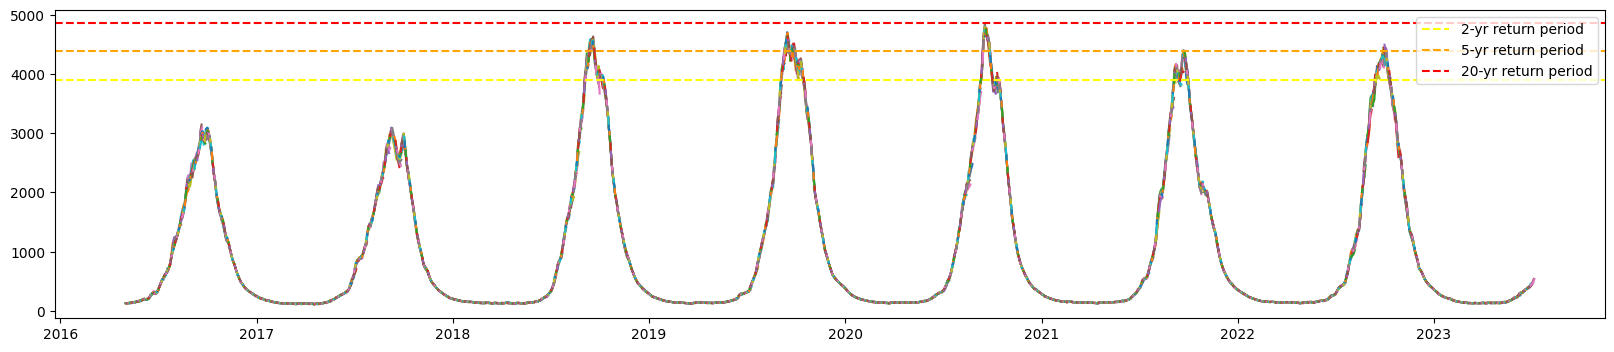

In [653]:
issue_time_start_date = '2016-05-01'
issue_time_end_date = '2024-10-30'

analyse.plot_reforecast(issue_time_start_date, issue_time_end_date,
                        ds_reforecast_1120724680, ds_return_ps_1120724680)

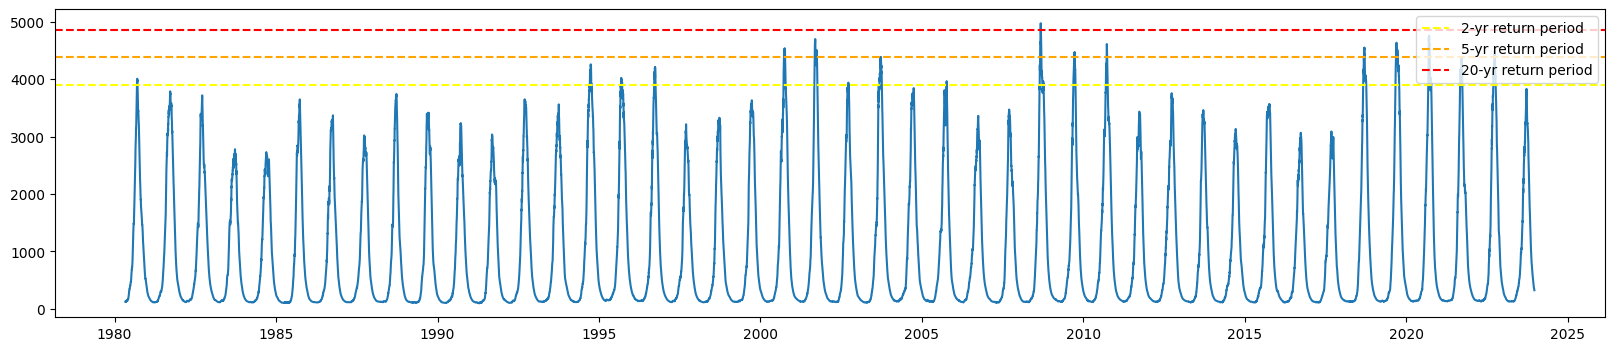

In [654]:
issue_time_start_date = '1980-05-01'
issue_time_end_date = '2024-10-30'

analyse.plot_reanalysis(issue_time_start_date, issue_time_end_date,
                        ds_reanalysis_1120724680, ds_return_ps_1120724680)

In [655]:
# # Plot all reanalysis data for Mali, 2016 - 2024:
# issue_time_start_date = '2016-05-01'
# issue_time_end_date = '2024-10-30'

# for hybas_id in dict_ds_data_Mali.keys():
#     ds_reanalysis = dict_ds_data_Mali[hybas_id]['reanalysis']
#     ds_return_ps = dict_ds_data_Mali[hybas_id]['return_periods']

#     analyse.plot_reanalysis(issue_time_start_date, issue_time_end_date,
#                             ds_reanalysis, ds_return_ps)

In [656]:
# # Plot all reforecast data for Mali, 2016 - 2024:
# issue_time_start_date = '2016-05-01'
# issue_time_end_date = '2024-10-30'

# for hybas_id in dict_ds_data_Mali.keys():
#     ds_reforecast = dict_ds_data_Mali[hybas_id]['reforecast']
#     ds_return_ps = dict_ds_data_Mali[hybas_id]['return_periods']

#     analyse.plot_reforecast(issue_time_start_date, issue_time_end_date,
#                             ds_reforecast, ds_return_ps)

In [657]:
ds_return_ps_1120724680

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    gauge_id           object ...
Data variables:
    return_period_10   float64 ...
    return_period_100  float64 ...
    return_period_15   float64 ...
    return_period_2    float64 3.904e+03
    return_period_20   float64 4.864e+03
    return_period_200  float64 ...
    return_period_25   float64 ...
    return_period_5    float64 4.392e+03
    return_period_50   float64 ...
    return_period_7    float64 ...

In [658]:
ds_reanalysis_1120724680

<xarray.Dataset>
Dimensions:     (time: 16063)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-23
    gauge_id    object ...
Data variables:
    streamflow  (time) float32 ...

In [659]:
from typing import Any
import matplotlib.pyplot as plt
from scipy import stats
from pyextremes import EVA
# the final step before analysis is to calculate the return periods
# for the reforecast data datasets using the reanalysis data. We do
# this because not all reforecast data contain more than the 5-yr RP
# in the return period datasets, and we need more of them for our analysis.
# They can be calculated using a Gumbel distribution or Log-Pearson III
def calculate_annual_max(ds: xr.Dataset) -> xr.DataArray:
    """
    Given a reanalysis dataset, it computes the annual maximum
    discharge values for the dataset

    :param ds: the reanalysis dataset
    :return: the dataset with annual maximum values
    """
    # exclude non-complete years from the reanalysis dataset, because
    # these might not include the rain season, and, consequently, neither
    # the annual water rises and/or floodings, and thus the annual maxima
    # ... this subsetting procedure is moved elsewhere

    if not pd.api.types.is_datetime64_any_dtype(ds['time']):
        ds['time'] = pd.to_datetime(ds['time'].values)
    return ds['streamflow'].resample(time = 'Y').max()


def calculate_RP_Gumbel(ds: xr.Dataset, RP: float) -> float:
    """
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value that corresponds to the
    given return period using a Gumbel distribution fit

    :param ds: the reanalysis dataset
    :param RP: the return period in years
    :return: the discharge value corresponding to the return period
    """                     
    annual_max = calculate_annual_max(ds).to_series()
    # print(annual_max)
                            # fit a Gumbel distribution to maxima
    loc, scale = stats.gumbel_r.fit(annual_max)
    return stats.gumbel_r.ppf(1 - (1 / RP), loc = loc, scale = scale)


def calculate_RP_LogPearsonIII(ds: xr.Dataset, RP: float) -> float:
    """ 
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value that corresponds to the
    given return period using a Log-Pearson Type-III dist. fit

    :param ds: the reanalysis dataset
    :param RP: the return period in years
    :return: the discharge value corresponding to the return period
    """                     
    annual_max = calculate_annual_max(ds).to_series()
                            # log-transform the maxima and fit
                            # a Log-Pearson Type-III distribution
    shape, loc, scale = stats.pearson3.fit(np.log10(annual_max))
                            # calculate z-value for the given return period,
                            # and then the return period value by inverting
    return 10 ** stats.pearson3.ppf(1 - (1 / RP), shape, loc = loc, scale = scale)


def calculate_RP_GEV(ds: xr.Dataset, RP: float) -> float:
    """ 
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value that corresponds to the
    given return period using a Generalized Extreme Value dist. fit

    :param ds: the reanalysis dataset
    :param RP: the return period in years
    :return: the discharge value corresponding to the return period
    """                     
    annual_max = calculate_annual_max(ds).to_series()
                            # fit a Generalized Extreme Value distribution to maxima
    loc, scale, shape = stats.genextreme.fit(annual_max)
                            #! Deze werkt niet goed, niet gebruiken
    return stats.genextreme.ppf(1 - (1 / RP), loc = loc, scale = scale, c = shape)


def calculate_RP_EVA(ds: xr.Dataset, RP: Any, method: str = 'GEV') -> float:
    """ 
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value for the RP using the
    pyextremes.eva.EVA package for a method of choice
    
    URL: https://georgebv.github.io/pyextremes/api/eva/

    :param ds: the reanalysis dataset
    :param RP: the return period(s) in years, as float or array
    :param method: the method to use for the calculation
    :return: the discharge value corresponding to the return period
    """
    model = EVA(ds['streamflow'].to_series())

    if method == 'GEV':    # Generalized Extreme Value distribution with:
                           # block method for block maxima, default freq is annual
        model.get_extremes(method = 'BM')
        model.fit_model(distribution = 'genextreme')
    else:
        raise ValueError(f'Unknown method: {method}')
                            #! Deze werkt ook niet goed, niet gberuiken
    return_value = model.get_return_value(return_period = RP)
    # print(type(return_value))
    # print(return_value)
    return return_value[0]


print('Gumbel and Log-Pearson III return periods for RP 2-20:')
for idx in range(2, 21):
    print(f'RP {idx}: {calculate_RP_Gumbel(ds_reanalysis_1120724680, idx):.0f}, '
          f'{calculate_RP_LogPearsonIII(ds_reanalysis_1120724680, idx):.0f}, '
          f'{calculate_RP_GEV(ds_reanalysis_1120724680, idx):.0f}, '
          f'{calculate_RP_EVA(ds_reanalysis_1120724680, idx):.0f}')

Gumbel and Log-Pearson III return periods for RP 2-20:
RP 2: 3696, 3761, 356, 2741
RP 3: 3969, 4013, 386, 2989
RP 4: 4144, 4160, 386, 4629
RP 5: 4273, 4264, 386, 11018
RP 6: 4376, 4342, 386, 29485
RP 7: 4462, 4406, 386, 73552
RP 8: 4535, 4459, 386, 165607
RP 9: 4599, 4504, 386, 339978
RP 10: 4655, 4543, 386, 646434
RP 11: 4706, 4578, 386, 1154059
RP 12: 4753, 4609, 386, 1955523
RP 13: 4795, 4638, 386, 3171727
RP 14: 4834, 4663, 386, 4956811
RP 15: 4871, 4687, 386, 7503525
RP 16: 4905, 4709, 386, 11048962
RP 17: 4937, 4729, 386, 15880631
RP 18: 4966, 4748, 386, 22342879
RP 19: 4995, 4766, 386, 30843656
RP 20: 5022, 4783, 386, 41861614


In [660]:
from typing import List, Dict, Any


def add_return_periods_to_dataset(
        ds_rf: xr.Dataset,
        ds_ra: xr.Dataset,
        method: str = 'Gumbel',
        rps: List[str] = ['1.5', '2', '5', '7', '10', '20']
    ) -> xr.Dataset:
    """
    Adds return period values to the dataset for the given return periods

    :param ds_rf: the (reforecast) dataset to add return periods to
    :param ds_ra: the (reanalysis) dataset to use for the calculations
    :param method: the method to use for the calculation: either 
                   'Gumbel', 'Log-Pearson III', 'GEV', or 'EVA'
    :param rps: the return periods to calculate, default is
                [1.5, 2, 5, 7, 10, 20]
    """
    if method not in ['Gumbel', 'Log-Pearson III', 'GEV', 'EVA']:
        raise ValueError(f'Unknown method: {method}')
    if method == 'Gumbel':
        for rp in rps:
            ds_rf.attrs[f'RP_{rp}'] = calculate_RP_Gumbel(ds_ra, float(rp))
    elif method == 'Log-Pearson III':
        for rp in rps:
            ds_rf[f'RP_{rp}'] = calculate_RP_LogPearsonIII(ds_ra, float(rp))
    elif method == 'GEV':
        for rp in rps:
            ds_rf[f'RP_{rp}'] = calculate_RP_GEV(ds_ra, float(rp))
    elif method == 'EVA':
        for rp in rps:
            ds_rf[f'RP_{rp}'] = calculate_RP_EVA(ds_ra, float(rp))
    return ds_rf


def add_percentiles_to_dataset(
        ds_rf: xr.Dataset,
        ds_ra: xr.Dataset,
        percentiles: List[int] = [95, 98, 99]
) -> xr.Dataset:
    """
    Adds percentile values to the dataset for the given percentiles

    :param ds_rf: the (reforecast) dataset to add percentiles to
    :param ds_ra: the (reanalysis) dataset to use for the calculations
    :param percentiles: the percentiles to calculate, default is
                        [95, 98, 99]
    """
    for perc in percentiles:
        ds_rf.attrs[f'pc_{perc}th'] = np.percentile(ds_ra['streamflow'], perc)
    return ds_rf
    

def get_common_IDs(
        dict_rf: Dict[str, xr.Dataset],
        dict_ra: Dict[str, xr.Dataset]
    ) -> List[str]:
    """
    Returns the common IDs between the two dictionaries

    :param dict_rf: dictionary with reforecast datasets
    :param dict_ra: dictionary with reanalysis datasets
    :return: the list of common IDs
    """
    # extract only the ID part from the keys, e.g.
    # ds_reforecast_hybas_1120724680 -> 1120724680; and
    # ds_reanalysis_hybas_112072468 -> 1120724680, to match IDs
    rf_IDs = [key.split('_')[-1] for key in dict_rf.keys()]
    ra_IDs = [key.split('_')[-1] for key in dict_ra.keys()]
    return list(set(rf_IDs).intersection(set(ra_IDs)))


def assure_all_attributes_added(
        dict_rf: Dict[str, xr.Dataset],
        common_keys: List[str],
        rps: List[str],
        percentiles: List[int]
    ) -> None:
    """
    Loops over all datasets and checks if all attributes were added

    :param dict_rf: dictionary with reforecast datasets
    :param common_keys: the common keys between the dictionaries
    :param rps: the return periods to calculate
    :param percentiles: the percentiles to calculate
    """
    for key in common_keys:
        ds_rf = dict_rf[f'ds_reforecast_{key}']
        for rp in rps:
            if f'RP_{rp}' not in ds_rf.attrs:
                raise ValueError(f'RP_{rp} not added to {key}')
        for perc in percentiles:
            if f'pc_{perc}th' not in ds_rf.attrs:
                raise ValueError(f'pc_{perc}th not added to {key}')


def add_RPs_and_percentiles(
        dict_rf: Dict[str, xr.Dataset],
        dict_ra: Dict[str, xr.Dataset],
        dict_rp: Dict[str, xr.Dataset],
        method: str = 'Gumbel',
        rps: List[str] = ['1.5', '2', '5', '7', '10', '20'],
        percentiles: List[int] = [95, 98, 99],
        verbose = True
) -> Dict[str, xr.Dataset]:
    """
    Helper function to add return periods and percentiles to all datasets

    :param dict_rf: dictionary with reforecast datasets
    :param dict_ra: dictionary with reanalysis datasets
    :param dict_rp: dictionary with return periods datasets
    :param method: the method to use for the calculation
    :param rps: the return periods to calculate
    :param percentiles: the percentiles to calculate
    :param verbose: whether to print messages
    :return: the updated dictionary with all datasets
    """
    common_keys = get_common_IDs(dict_rf, dict_ra)
    
    if len(common_keys) == 0:
        raise ValueError('No common keys found between the dictionaries')
    if len(common_keys) != len(dict_rf) or len(common_keys) != len(dict_ra):
        raise ValueError('Dictionaries have different lengths')

                            # add the RPs and %'s
    idx = 1
    for key in common_keys:
        if verbose:
            if idx % 50 == 0:
                print(f'{idx/len(common_keys)*100:.2f}% done')
            idx += 1

        ds_rf = dict_rf[f'ds_reforecast_{key}']
        ds_ra = dict_ra[f'ds_reanalysis_{key}']
        ds_rp = dict_rp[f'ds_return_ps_{key}']
                            # add to reforecast dict datasets
        dict_rf[f'ds_reforecast_{key}'] = add_return_periods_to_dataset(
            ds_rf, ds_ra, method, rps
        )
        dict_rf[f'ds_reforecast_{key}'] = add_percentiles_to_dataset(
            ds_rf, ds_ra, percentiles
        )
        #                     # add to return periods dict datasets after
        #                     # prefixing old keys with 'old_'
        # for attr_key in list(ds_rp.attrs.keys()):
        #     if attr_key.startswith("return_period_"):
        #         ds_rp.attrs[f"old_{attr_key}"] = ds_rp.attrs.pop(attr_key)
                            # add to return periods dict datasets
        dict_rp[f'ds_return_ps_{key}'] = add_return_periods_to_dataset(
            ds_rp, ds_ra, method, rps
        )
        dict_rp[f'ds_return_ps_{key}'] = add_percentiles_to_dataset(
            ds_rp, ds_ra, percentiles
        )

                            # check if all attributes were added
    assure_all_attributes_added(dict_rf, common_keys, rps, percentiles)

    print('100% done')
    return dict_rf, dict_rp

In [661]:
# add return periods and percentiles to all datasets and create
# a dictionary with all values recalculated (rc) for reference
dict_datasets, dict_return_periods_rc = \
    add_RPs_and_percentiles(dict_datasets, dict_reanalysis, dict_return_periods)

3.00% done
6.01% done
9.01% done
12.02% done
15.02% done
18.03% done
21.03% done
24.04% done
27.04% done
30.05% done
33.05% done
36.06% done
39.06% done
42.07% done
45.07% done
48.08% done
51.08% done
54.09% done
57.09% done
60.10% done
63.10% done
66.11% done
69.11% done
72.12% done
75.12% done
78.12% done
81.13% done
84.13% done
87.14% done
90.14% done
93.15% done
96.15% done
99.16% done
100% done


In [662]:
dict_datasets['ds_reforecast_1120040380']

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_1.5:   89.75050452923384
    RP_2:     132.8784961487048
    RP_5:     239.01527224744933
    RP_7:     273.65214805644086
    RP_10:    309.28705329043413
    RP_20:    376.69343279034223
    pc_95th:  39.41727371215819
    pc_98th:  78.35467834472658
    pc_99th:  116.63700698852435

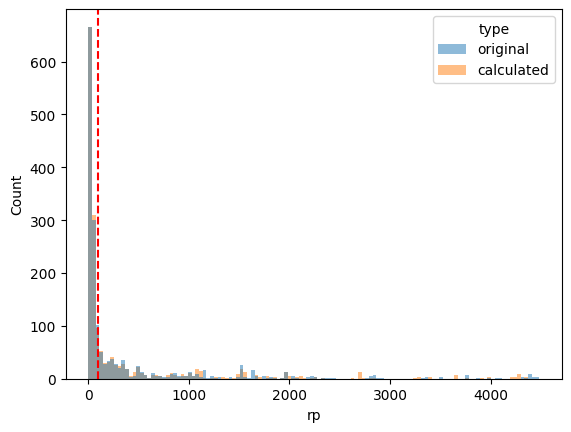

In [663]:
# compare some of the calculated return periods with the actual values from Google
import matplotlib.pyplot as plt
import seaborn as sns

original_5YR_RP_values = [float(ds['return_period_5']) for ds in dict_return_periods.values() if\
                           'return_period_5' in ds]
calculated_5YR_RP_values = [float(ds.attrs['RP_5']) for ds in dict_datasets.values() if\
                             'RP_5' in ds.attrs]
df = pd.concat([pd.DataFrame({'rp': original_5YR_RP_values,
                              'type': 'original'}),
                pd.DataFrame({'rp': calculated_5YR_RP_values,
                              'type': 'calculated'})])
sns.histplot(data = df, x = 'rp', hue = 'type', alpha = 0.5, edgecolor = None)
plt.axvline(x = 100, color = 'red', linestyle = '--')
plt.show()

In [664]:
# exclude all datasets where the 5-yr RP is below 100
dict_datasets = {key: value for key, value in dict_datasets.items() if \
                    float(value.attrs['RP_5']) >= 100}
dict_return_periods_rc = {key: value for key, value in dict_return_periods_rc.items() if \
                            float(value.attrs['RP_5']) >= 100}
print(len(dict_datasets))
print(len(dict_return_periods_rc))

623
623


In [665]:
# free up memory
del dict_reanalysis

### **Checkpoint: adjust comparison type, lead time, or threshold from here**

From here, with the datasets and various return period calculated, the script can be ran with different configurations to generate different kinds of plots and metrics, which will all be exported (except for the plots) to the `data/` folder. The options are:

* For comparison type (**COMP_TYPE**): IMPACT or OBSERVATION, giving a comparison to either events as entailed by the impact data or observational timeseries data. Note that the comparison will differ in sample size due to differing data types and data sizes, and the fact that flood events are discarded based on some criteria from the used comparative dataset (see below).
* For lead time (**LEAD_TIME**), the options are 1 to 7, since the GFH model does an autoregressive 7-day horizon forecast at each issue time.
* For threshold (**THRESHOLD**), the options are 1.5-, 2-, 5-, 7-, 10-, 20-year return period thresholds, as calculated through the timeseries maxima, or the 95th, 98th, 99th percentile thresholds, as calculated through the mean.

One calculation can take up to 30 minutes, depending on whether some common precalculations are done already.
```
comp_types = ['IMPACT', 'OBSERVATION']
thresholds = [1.5, 2, 5, 7, 10, 20, 95, 98, 99]
lead_times = [1, 2, 3, 4, 5, 6, 7]
```

In [835]:
COMP_TYPE = 'IMPACT'
THRESHOLD = 5
LEAD_TIME = 7

### **Creating forecasted/ground truth "events" and calculate overlap**

Now that we have preprocessed (re)forecast datasets per gauge with a lead time of up to 7 days and with attributes such as coordinates and return period thresholds, we can process them further. We take all datasets in an administrative unit (level 2) and:
* subset a certain lead time (LEAD_TIME) to analyse;
* aggregate them using the maximum per timestep;
* aggregate the return periods with the maximum per threshold; and
* create new datasets per administrative unit with the aggregated timeseries and updated attributes.

With datasets per admin unit ready, we loop through them to create "flood events": periods of consecutive flooding in an administrative unit. A flood event is "triggered" once the maximum chosen lead time (LEAD_TIME) predicted discharge in an administrative unit surpasses the return period threshold (THRESHOLD) for more than one day. 

Later, these can be compared to impact events (IMPACT) or observation events (OBSERVATION) to determine overlap, e.g. through boolean masking, and calculate metrics.

In [836]:
# To automate the classification of the gauges into administrative units,
# we first need to add coordinates to of every gauge dataset
from typing import Dict
import pandas as pd
import xarray as xr


def index_country_gauge_coords(df_gauges: pd.DataFrame) -> pd.DataFrame:
    """
    Return the DataFrame with gauge names and coordinates of a specific country

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    :return: DataFrame with gauge names and coordinates of a specific country
    """
    return df_gauges.set_index('gaugeId')[['latitude', 'longitude']]


def export_country_gauge_coords(
        df_gauges: pd.DataFrame, country_name: str = None
    ) -> None:
    """
    Export gauge names and coordinates of a specific country to .csv.
    Optionally prints them as well (default = False)

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    """
    df_subset = index_country_gauge_coords(df_gauges)
    df_subset.to_csv(f"../data/processed/gauge_coords/{country_name}_gauge_coords.csv",
                     index = True,
                     sep = ';',
                     decimal = '.',
                     encoding = 'utf-8')
    

def get_country_gauge_coords(country: str) -> pd.DataFrame:
    """
    Get the coordinates of the gauges in a country, stored in data/ folder

    :param country: name of the country
    :return: DataFrame with the gaugeId, latitude and longitude
    """
    if country[0].islower():
        country = country.capitalize()
    return pd.read_csv(f'../data/processed/gauge_coords/{country}_gauge_coords.csv',
                       index_col = None, sep = ';', decimal = '.')


def assign_coords_to_datasets(
        datasets: Dict[str, xr.Dataset], country: str
    ) -> xr.Dataset:
    """
    Takes a dict of datasets and assigns their coordinates, which it gets
    from get_country_gauge_coords(), and assigns it to each dataset. The
    dict contains the names of the datasets as keys and the datasets as values

    :param datasets: dict of datasets
    :param country: name of the country
    :return: dict of datasets with coordinates
    """
    df_coords = get_country_gauge_coords(country)

    for gauge_id, dataset in datasets.items():
        # assumes full name, e.g. 'hybas_1120661040', in df_coords, thus creating
        # a comparison of solely the hybas numbers, not the full name or dataset identifier
        coords = df_coords[
            df_coords['gaugeId'].apply(lambda x: x.split('_')[-1]) == gauge_id.split('_')[-1]
        ]

        if not coords.empty:
            # add the coordinates to the dataset as attributes
            dataset.attrs['latitude'] = coords['latitude'].values[0]
            dataset.attrs['longitude'] = coords['longitude'].values[0]
            # add the hybas_id to the dataset as well (e.g. '1120661040')
            dataset.attrs['gauge_id'] = gauge_id.split('_')[-1]
        else:
            print(f'No coordinates found for gauge {gauge_id}') 

    return datasets

In [893]:
# With the coordinates added, we can classify the gauges into administrative units
import analyse
from typing import Dict
import warnings
import pandas as pd
import geopandas as gpd
import xarray as xr


def create_coords_df_from_ds(dict_ds: Dict[str, xr.Dataset]) -> pd.DataFrame:
    """
    Create a DataFrame with all gauge ID's and coordinates in a
    dictionary with xarray Datasets

    :param dict_ds: xarray Dataset
    :return: DataFrame with the coordinates
    """
    return pd.DataFrame([
        {
            'gauge_id': ds.attrs['gauge_id'],
            'longitude': ds.attrs['longitude'],
            'latitude': ds.attrs['latitude']
        }
        for ds in dict_ds.values()
    ])


def assure_admin_units_assigned(dict_ds: Dict[str, xr.Dataset]) -> None:
    """
    Check if all datasets have been assigned an admin unit

    :param dict_ds: dict of datasets
    """
    for ds in dict_ds.values():
        if 'admin_unit' not in ds.attrs:
            print(f'No admin unit assigned to dataset {ds.attrs["gauge_id"]}')
            continue
        admin_unit = ds.attrs['admin_unit']
        if any(pd.isna(unit) for unit in admin_unit):
            print(f'No admin unit assigned to dataset {ds.attrs["gauge_id"]} (NaN found)')


def handle_NaN_admin_units(codes: pd.Series) -> list:
    """
    Handle NaN values in the series of administrative unit assignments for gauges

    :param codes: Series containing administrative unit codes (ADM2_PCODE) for a gauge
    :return: list of valid administrative unit codes (ADM2_PCODE)
    """
    if codes.isna().any():
        print(f"Warning: Found NaN in administrative unit assignment "
              f"for gauge IDs: {codes[codes.isna()].index.tolist()}")
    return list(codes.dropna())


def assign_admin_unit_to_datasets(
        dict_ds: Dict[str, xr.Dataset],
        country: str = 'Mali',
        verbose: bool = False,
        # Path to the shape file with admin level 2 units for Mali
        path: str = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp',
        buffer_radius: int = 5000
    ) -> Dict[str, xr.Dataset]:
    """
    Assigns the administrative unit to each dataset in the dictionary by:
    (1) assiging coordinates to the datasets, with assign_coords_to_datasets(),
        which takes information queried by ListGauges() in the 'extract' package
    (2) creating a GeoDataFrame from the dataset coordinates, which includes a
        5 km buffer around the gauges, to account for shape file inaccuracies and,
        more importantly, the fact that gauges are usually located in rivers, which,
        in turn, are usually borders between administrative units, causing gauges to
        be located in only onr of the units, while they effectively tell about both.
        With a buffer, this is accounted for, and, as a result, gauges can be assigned
        to multiple administrative units, if they simply intersect with multiple units
    (3) creating a GeoDataFrame from the shape file with the admin units, source:
        (https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/)
    (4) classifying the gauges into the administrative units by joining the two above
    (5) adding the admin unit names to the datasets by matching the gauge ID's and
        the found administrative units
    (6) returning the updated dictionary with the datasets, with datasets that now have
        the attributes 'longitude', 'latitude', and 'admin_unit'

    :param dict_ds: dict of datasets
    :param country: name of the country
    :param verbose: whether to print some test print-s's
    :param path: path to the shape file with the admin units
    :param buffer_radius: radius of the buffer around the gauges, standard is 5 km
    :return: dict of datasets with administrative units
    """
    #* (1): assign coordinates to the datasets
    dict_ds = assign_coords_to_datasets(dict_ds, country)
    # print(next(iter(dict_ds.items()))) if verbose else None

    #* (2): create a GeoDataFrame from the dataset coordinates;
    # geometry is a point for each gauge, with coords (x, y)
    df_gauge_coords = create_coords_df_from_ds(dict_ds)
    gpd_Mali_gauge_coords = gpd.GeoDataFrame(
        df_gauge_coords,
        geometry = gpd.points_from_xy(
            df_gauge_coords['longitude'], df_gauge_coords['latitude']
        ),
        crs = 'EPSG:4326'
    )
    # add a buffer of 5 km around the points to account for inaccuracies,
    # where 1 degree is approx. 111,32 km at the equator, so in degrees (which
    # we have to use as the coordinate system is WGS84), 5 km is 5000 meter \
    # divided by 111.320 meters (5000 / 111320). This is a rough estimate, but
    # should be sufficient, since the number of 5 km is too mostly arbirtrary.
    # Also, surpress the warning that the buffer is not exact, as we are aware
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gpd_Mali_gauge_coords['geometry'] = \
            gpd_Mali_gauge_coords.geometry.buffer(buffer_radius / 111320)

    #* (3): read the shape file into a GeoDataFrame and convert it to WGS84
    # (which is the coordinate system used by the gauge data)
    gpd_adm_units_Mali = analyse.get_shape_file(path).to_crs('EPSG:4326')
    # check if the coord systems are the same
    if gpd_adm_units_Mali.crs != gpd_Mali_gauge_coords.crs:
        gpd_adm_units_Mali = gpd_adm_units_Mali.to_crs(gpd_Mali_gauge_coords.crs)
    analyse.assert_same_coord_system(gpd_adm_units_Mali, gpd_Mali_gauge_coords)

    #* (4) now we can classify the gauges into the administrative units:
    # creating a joined dataframe with the gauges as basis, meaning
    # that gauges get assigned to the admin unit they are within,
    # including their metadata (such as the shape of the admin unit).
    # (And, thus, the rest of the admin units are not considered.)
    gpd_gauges_classified = gpd.sjoin(
        gpd_Mali_gauge_coords, gpd_adm_units_Mali,
        how = 'left',           # joins left, i.e. the gauges serve as basis
                                # checks if the gauge intersects with the admin unit
        predicate = 'intersects',
        lsuffix = 'gauge', rsuffix = 'adm'
    )
    print(gpd_gauges_classified.head(1)) if verbose else None
    # make a mapping of the gauge ID's and the admin unit names:
    # group by gauge ID; select the admin unit names; check for NaNs;
    # convert to list; then dictionary with {gauge_id: [admin_unit]}
    mapping = gpd_gauges_classified.groupby('gauge_id')['ADM2_PCODE']\
        .apply(handle_NaN_admin_units).to_dict()

    #* (5) lastly, we add the admin unit names to the datasets
    print(mapping) if verbose else None
    for gauge_id, admin_units in mapping.items():
        dict_ds[f'ds_reforecast_{gauge_id}'].attrs['admin_unit'] = admin_units

    #* (6) check result and return
    assure_admin_units_assigned(dict_ds)
    print('\n\n', next(iter(dict_ds.items()))) if verbose else None
    return dict_ds

In [838]:
# make sure country gauge coords are available and then assign them
export_country_gauge_coords(df_Mali_gauges, 'Mali')

dict_datasets = assign_admin_unit_to_datasets(dict_datasets)

     gauge_id  longitude   latitude  \
0  1120040380   -4.91875  16.552083   

                                            geometry  index_adm  Shape_Leng  \
0  POLYGON ((-4.87383 16.55208, -4.87405 16.54768...         37   19.799568   

   Shape_Area  ADM2_FR ADM2_PCODE ADM2_REF ADM2ALT1FR ADM2ALT2FR     ADM1_FR  \
0    9.833102  Goundam     ML0602     None       None       None  Tombouctou   

  ADM1_PCODE    ADM0_FR ADM0_PCODE       date    validOn     validTo  
0       ML06  Mali (le)         ML 2015-06-01 2021-12-20  0000/00/00  
{'1120040380': ['ML0602'], '1120550010': ['ML0702'], '1120550020': ['ML0702'], '1120550380': ['ML0702'], '1120550540': ['ML0702'], '1120550770': ['ML0702'], '1120551410': ['ML0702'], '1120551560': ['ML0603', 'ML0605'], '1120551780': ['ML0702'], '1120552270': ['ML0702'], '1120552280': ['ML0702'], '1120552460': ['ML0702'], '1120553570': ['ML0702'], '1120553750': ['ML0702'], '1120554770': ['ML0702'], '1120556990': ['ML0702'], '1120558440': ['ML0702'], '11205

In [839]:
# check if all datasets in dict_datasets have been assigned the 
# attributes: 'longitude', 'latitude', and 'admin_unit'
def assure_admin_units_assigned(dict_datasets: Dict[str, xr.Dataset]):
    """ 
    Check if all datasets have been assigned an admin unit,
    including coordinates and gauge_id

    :param dict_datasets: dict of datasets
    """
    for ds in dict_datasets.values():
        assert 'gauge_id' in ds.attrs, f'No gauge ID assigned to dataset {ds}'
        assert 'admin_unit' in ds.attrs, f'No admin unit assigned to dataset {ds.attrs["gauge_id"]}'
        assert 'latitude' in ds.attrs, f'No latitude assigned to dataset {ds.attrs["gauge_id"]}'
        assert 'longitude' in ds.attrs, f'No longitude assigned to dataset {ds.attrs["gauge_id"]}'


assure_admin_units_assigned(dict_datasets)

In [840]:
print(dict_datasets['ds_reforecast_1120766460'])

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes: (12/13)
    RP_1.5:      750.0703848778509
    RP_2:        817.8784610140584
    RP_5:        984.7522319527934
    RP_7:        1039.210133278208
    RP_10:       1095.237188480154
    RP_20:       1201.217011364657
    ...          ...
    pc_98th:     873.9418603515626
    pc_99th:     994.752163085937
    latitude:    11.22291666666553
    longitude:   -8.485416666669321
    gauge_id:    1120766460
    admin_unit:  ['ML0306']


In [841]:
# Writing this down here for completeness' sake...
# For plotting purposes, we find the gauge ID that is placed in the
# admin unit of Bamako, in the city named Bamako, Mali's capital.
# The pcode of admin unit is ML0901, and the river gauge ID 1120724680.

In [842]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_admin_units_with_gauges(
        dict_ds: Dict[str, xr.Dataset],
        add_dots: bool = False,
        path = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
    ) -> None:
    """
    Plot the administrative units of a country with the gauges contained in them

    :param dict_ds: dict of gauge datasets
    :param add_dots: whether to add dots for the gauges
    :param path: path to the shape file with the admin units
    """
    # create a GeoDataFrame with the coordinates of the gauges
    # (code copied from assign_admin_unit_to_datasets())
    df_gauge_coords = create_coords_df_from_ds(dict_ds)
    gpd_Mali_gauge_coords = gpd.GeoDataFrame(
        df_gauge_coords,
        geometry = gpd.points_from_xy(
            df_gauge_coords['longitude'], df_gauge_coords['latitude']
        ),
        crs = 'EPSG:4326'
    )
    # add a buffer of 5 km around the points to account for inaccuracies,
    # where 1 degree is approx. 111,32 km at the equator, so in degrees (which
    # we have to use as the coordinate system is WGS84), 5 km is 5000 meter \
    # divided by 111.320 meters (5000 / 111320). This is a rough estimate, but
    # should be sufficient, since the number of 5 km is too mostly arbirtrary.
    # Also, surpress the warning that the buffer is not exact, as we are aware
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gpd_Mali_gauge_coords['geometry'] = \
            gpd_Mali_gauge_coords.geometry.buffer(5000 / 111320)
        
    # make a GeoDataFrame with the administrative units
    gpd_adm_units_Mali = analyse.get_shape_file(path).to_crs('EPSG:4326')
    # A quick intermediary plot to see which admin units are contained in the datasets:
    # We want to make a plot where each administrative unit with a gauge gets a tinted
    # colour. Thus, we now join the GeoDataFrames the other way around
    gpd_adm_units_with_gauges = gpd.sjoin(
        gpd_adm_units_Mali, gpd_Mali_gauge_coords,
        how = 'left',
        predicate = 'intersects', # see if they intersect with one another
        lsuffix = 'adm', rsuffix = 'gauge'
    )

    print('Administrative units in Mali:', len(gpd_adm_units_Mali))
    # Drop the column where index_gauge (aka index_right) is NaN,
    # because that means that the admin unit does not contain a gauge
    gpd_adm_units_with_gauges = gpd_adm_units_with_gauges.dropna(subset = ['index_gauge'])
    # 15 gauges left, so there's one administrative unit with two gauges
    print('Administrative units with a gauge: ', end = '')
    print(len(gpd_adm_units_with_gauges['ADM2_PCODE'].unique()))
    # Plot using 510 colours
    red, blue, dot_c = '#DB0A13', '#092448', '#C6E7FF'
    fig, ax = plt.subplots(figsize = (10, 10))
    gpd_adm_units_Mali.plot(ax = ax, color = blue, edgecolor = 'black', linewidth = 0.5)
    gpd_adm_units_with_gauges.plot(ax = ax, color = red, edgecolor = 'black', linewidth = 0.5)
    # Add legend handles as list (which gives the option to add more later)
    legend_handles = [
        Patch(color = red, label = 'AU with gauge'),
        Patch(color = blue, label = 'AU without gauge'),
    ]
    # If add dots, add all coordinates of the gauges as dots, including as legend
    if add_dots:
        latitudes = [ds.latitude for ds in dict_ds.values()]
        longitudes = [ds.longitude for ds in dict_ds.values()]
        ax.scatter(longitudes, latitudes, color = dot_c, s = 4, alpha = 1)
        legend_handles.append(
            Line2D([0], [0], marker = 'o', color = dot_c, markersize = 5, alpha = 1, linestyle = '',
                   label = 'FloodHub gauges')
        )
        
    # This comment is now irrelevant but kept for reference (e.g. to use as example in paper)
    # # The coordinates of gauge 1120766460 seem to be slightly off, and
    # # coincidentally, it is placed outside of Mali and not within an admin unit   
    # # ax.plot(-8.485416666669321, 11.22291666666553, 'go', markersize = 2)
    ax.legend(handles = legend_handles, loc = 'upper right')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Administrative units with gauges in Mali')
    plt.show()

Administrative units in Mali: 53
Administrative units with a gauge: 41


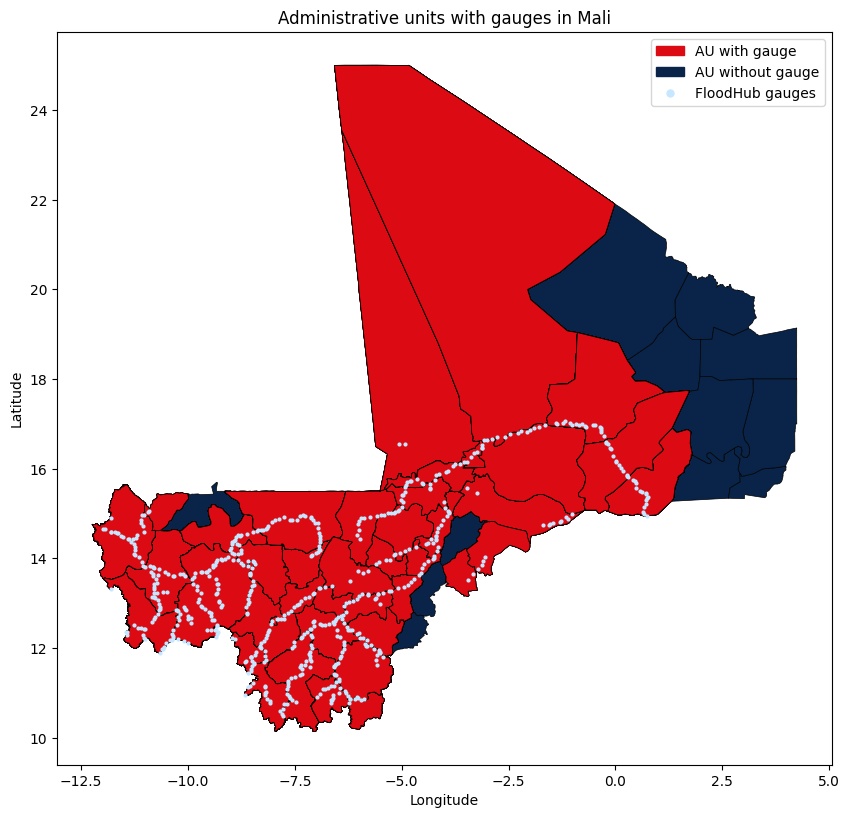

In [843]:
plot_admin_units_with_gauges(dict_datasets, True)

In [844]:
# With the datasets classified into admin units, we will now aggregate
# the data per admin unit and create a dataset with just the maximum value of
# the reforecast data at each possible timestep available in the datasets for
# each admin units (resulting in one dataset per admin unit). 
#   Also, to determine when to trigger and identify an "event", we need to
# choose how we want to aggregate the return periods of each gauge
# into one value for the administrative unit. 
import os
from typing import Dict, List
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd


def export_datasets_to_netcdf(
        d_ds: Dict[str, xr.Dataset], path: str, lt: int
    ) -> None:
    """
    Export a dataset to a netCDF file

    :param d_ds: dict of datasets
    :param path: path to the file
    :param lt: lead time of the dataset
    """
    for key, ds in d_ds.items():
        try:
            if os.path.dirname(path) and not os.path.exists(os.path.dirname(path)):
                os.makedirs(os.path.dirname(path), exist_ok = True)
            ds.to_netcdf(f'{path}{key}_{lt * 24}lt.nc')
        except FileNotFoundError as fnf_error:
            print(f"File not found error: {fnf_error}")
        except PermissionError as perm_error:
            print(f"Permission error: {perm_error}")
        except TypeError as type_error:
            print(f"Type error: {type_error}")
        except Exception as exc:
            print(f"Failed to dataset to '{path}': {exc}")


def import_datasets_from_netcdf(path: str, lt: int) -> Dict[str, xr.Dataset]:
    """
    Import a dictionary of datasets from a folder with netCDF files:
    the inverse of export_datasets_to_netcdf()

    :param path: path to the files
    :param lt: lead time of the datasets to import
    :return: dict of datasets
    """
    d_ds = {}
    if not os.path.exists(path):
        raise ValueError('Path does not exist')
    for filename in os.listdir(path):
        if filename.endswith(f'_{lt * 24}lt.nc'):
            key = filename.split('_')[0]
            file_path = os.path.join(path, filename)
            try:
                ds = xr.open_dataset(file_path)
                d_ds[key] = ds
            except Exception as exc:
                print(f"Failed to import dataset from '{file_path}': {exc}")
    return d_ds


# def get_upstream_gauge_return_period(
#         admin_unit: str,
#         dict_ds_au: Dict[str, xr.Dataset],
#         dict_return_periods: Dict[str, xr.Dataset],
#         rp_value: int = 5,
#     ) -> float:
#     """
#     Searches in the admin unit for the gauge that is the most "upstream"

#     :param admin_unit: administrative unit ID
#     :param dict_ds_au: dict of datasets per admin unit
#     :param dict_return_periods: dictionary of return period dataset per gauge
#     :param rp_value: return period value to aggregate
#     :return: return period value of the most upstream gauge
#     """


def create_admin_unit_set(dict_ds: Dict[str, xr.Dataset]) -> set:
    """
    Create a unique set of the admin units in the datasets

    :param dict_ds: dict of datasets
    :return: set of admin units
    """
    admin_units = set()
    for ds in dict_ds.values():
        if 'admin_unit' in ds.attrs:
            if ds.attrs['admin_unit'] is None:
                print(f'No admin unit found in dataset {ds.attrs["gauge_id"]}')
            else:
                admin_units.update(ds.attrs['admin_unit'])
        else:
            raise ValueError('No admin unit found in dataset')
    return admin_units


def get_dict_ds_per_admin_unit(dict_ds: Dict[str, xr.Dataset]) -> Dict[str, list]:
    """
    Get a dictionary with the datasets per admin unit

    :param dict_ds: dict of datasets
    :return: dict of datasets per admin unit
    """
    admin_units = create_admin_unit_set(dict_ds)
    dict_ds_per_admin_unit = {unit: [] for unit in admin_units}
    for ds in dict_ds.values():
        for unit in ds.attrs['admin_unit']:
            dict_ds_per_admin_unit[unit].append(ds)
    return dict_ds_per_admin_unit


def pretty_print_list(l: list) -> None:
    """
    Pretty print a list

    :param l: list
    """
    print(', '.join(l))


def subset_lead_time(ds: xr.Dataset, lt: int) -> xr.Dataset:
    """
    Subset the dataset to a certain lead time

    :param ds: xarray Dataset
    :param lt: lead time to subset to
    :return: xarray Dataset with subsetted lead time
    """
    if lt < 0 or lt > 7:
        raise ValueError('Lead time must be between 0 and 7 days')
    return ds.sel(lead_time = pd.Timedelta(days = lt))


def assign_actual_dates_to_dataset(ds: xr.Dataset) -> xr.Dataset:
    """
    Assign the actual dates to the dataset as new coordinates

    :param ds: xarray Dataset
    :return: xarray Dataset with actual dates as coordinates
    """
    actual_dates = ds['issue_time'] + ds['lead_time']
    return ds.assign_coords(actual_date = ('issue_time', actual_dates.data))


def aggregate_per_admin_unit(
        dict_datasets: Dict[str, xr.Dataset],
        lead_time: int = 7,
        method_streamflow: str = 'max',
        method_return_periods: str = 'max',
        verbose: bool = True
    ) -> Dict[str, xr.Dataset]:
    """
    Aggregate the data per administrative unit:
    - with lead time, subset the forecast horizon can be subsetted
    - method_streamflow: method of aggregation for the streamflow data,
                         defaulting to 'max', i.e. just taking the max per timestep
    - method_return_periods: method of aggregation for the return periods

    :param dict_datasets: dict of datasets
    :param lead_time: lead time of the forecast to aggregate
    :param method_streamflow: method of aggregation for the streamflow data
    :param method_return_periods: method of aggregation for the return periods
    :param verbose: whether to print some test print-s's
    :return: dict of datasets with aggregated data
    """
    # get the datasets per admin unit for aggregation next;
    # check which admin units did not get any dataset assigned
    grouped_datasets = get_dict_ds_per_admin_unit(dict_datasets)
    if verbose:
        print("[admin unit ID] : list([gauge ID's])")
        for unit, datasets in grouped_datasets.items():
            print(unit, end = ' : ')
            pretty_print_list([ds.attrs['gauge_id'] for ds in datasets])
        print('\n')

    dict_datasets_aggregated = {}
    dict_rp_aggregated = {}
    # time complexity is O(n), where n is the number of admin units
    idx = 1
    for admin_unit, datasets in grouped_datasets.items():
        if verbose:
            print(f'aggregating {idx}/{len(grouped_datasets)}: {admin_unit}')
            idx += 1
        
        # (2) concatenate the datasets into one dataset and add gauge_id dimension;
        # (3) filter by lead time, discarding the other lead times; (4) assign the
        # actual dates to the dataset, a.k.a. the date at which the forecast actually
        # applies to; (5) aggregate the data by 'actual date' and calculate with 'method'
        ds_combined = xr.concat(datasets, dim = 'gauge_id')
        ds_combined_subset = subset_lead_time(ds_combined, lead_time)
        ds_combined_actual_dates = assign_actual_dates_to_dataset(ds_combined_subset)
        
        if method_streamflow == 'max':
            ds_aggregated = \
                ds_combined_actual_dates.groupby('actual_date').max(dim = 'gauge_id')
        elif method_streamflow == 'mean':
            ds_aggregated = \
                ds_combined_actual_dates.groupby('actual_date').mean(dim = 'gauge_id')
        else:
            raise ValueError('Method parameter not recognised')
        ds_aggregated.attrs = {}

        # we'll also aggregate the return periods present in the dataset attributes here
        # using a method of choice, and add these to the aggregated datasets as attributes.
        # we do this by (1) collecting the relevant attributes from the datasets, (2)
        # aggregating them with the method, and (3) adding them as attributes to the
        # aggregated datasets, and also saving them separately for reference
        dict_rp_aggregated[admin_unit] = xr.Dataset({}, attrs = {'admin_unit': admin_unit})
        attrs_collector = {}
        for ds in datasets:
            for attr in ds.attrs:
                if attr.startswith('RP_') or attr.startswith('pc_'):
                    if attr not in attrs_collector:
                        attrs_collector[attr] = []
                    attrs_collector[attr].append(ds.attrs[attr])
        for attr_key, values in attrs_collector.items():
            v = [float(v) for v in values]
            if len(v) != len(datasets):
                raise ValueError('Not all datasets have the same attributes')
            if method_return_periods == 'max':
                max_value = float(np.max(v))
                ds_aggregated.attrs[attr_key] = max_value
                dict_rp_aggregated[admin_unit].attrs[attr_key] = max_value
            elif method_return_periods == 'mean':
                mean_value = float(np.mean(v))
                ds_aggregated.attrs[attr_key] = mean_value
                dict_rp_aggregated[admin_unit].attrs[attr_key] = mean_value
            else:
                raise ValueError('RP-aggregation method not recognised')
            
        # last for this step, we update the attributes of the dataset of the admin unit,
        # since now we're up a level from gauges to units, asking for a replacement
        # of the attributes: we drop longitude, latitude, gauge_id, and admin_unit,
        # and add the admin_unit and the gauge_id's of the gauges in the unit
        ds_aggregated.attrs['admin_unit'] = admin_unit
        ds_aggregated.attrs['gauge_ids'] = [ds.attrs['gauge_id'] for ds in datasets]
        dict_datasets_aggregated[admin_unit] = ds_aggregated
    
    return dict_datasets_aggregated, dict_rp_aggregated


def aggregate_or_load_per_admin_unit(
        dict_datasets: Dict[str, xr.Dataset],
        lt: int = 7,
        method_streamflow: str = 'max',
        method_return_periods: str = 'max',
        verbose: bool = True,
    ) -> Dict[str, xr.Dataset]:
    """
    Helper function to aggregate the data per gauge (with aggregate_per_admin_unit())
    to per admin unit if not done already (then load the datasets instead)

    :param dict_datasets: dict of datasets
    :param lt: lead time of the forecast to aggregate (e.g. 7)
    :param method_streamflow: method of aggregation for the streamflow data
    :param method_return_periods: method of aggregation for the return periods
    :param verbose: whether to print some test print-s's
    :return: dict of datasets with aggregated data
    """
    if type(lt) != int or lt < 0 or lt > 7:
        raise ValueError('Lead time must be an integer between 0 and 7')
    
    n_to_load = len(create_admin_unit_set(dict_datasets))
    if not os.path.exists('../data/GRRR/aggregated/') or not os.path.exists('../data/GRRR/aggregated_rp/'):
        os.makedirs('../data/GRRR/aggregated/', exist_ok = True)
        os.makedirs('../data/GRRR/aggregated_rp/', exist_ok = True)
    # Check whether the below if statements work with some printing statements
    print('Checking if datasets are already loaded...')
    # print(n_to_load)
    # print(len([f for f in os.listdir('../data/GRRR/aggregated/') if f.endswith(f'_{lt * 24}lt.nc')]))
    # print(len([f for f in os.listdir('../data/GRRR/aggregated_rp/') if f.endswith(f'_{lt * 24}lt.nc')]))


    n_datasets_loaded = len([f for f in os.listdir('../data/GRRR/aggregated/') if \
                             f.endswith(f'_{lt * 24}lt.nc')])
    n_rps_loaded = len([f for f in os.listdir('../data/GRRR/aggregated_rp/') if \
                        f.endswith(f'_{lt * 24}lt.nc')])
    if (n_to_load == n_datasets_loaded) and (n_to_load == n_rps_loaded):
        print('Loading in datasets...')
        dict_datasets_au = import_datasets_from_netcdf('../data/GRRR/aggregated/', lt)
        dict_return_periods_au = import_datasets_from_netcdf('../data/GRRR/aggregated_rp/', lt)
        print('Loading complete')
    else:
        print('Datasets not loaded yet; aggregating...')
        dict_datasets_au, dict_return_periods_au = aggregate_per_admin_unit(
            dict_datasets, lt, method_streamflow, method_return_periods, verbose)
        export_datasets_to_netcdf(dict_datasets_au, '../data/GRRR/aggregated/', lt)
        export_datasets_to_netcdf(dict_return_periods_au, '../data/GRRR/aggregated_rp/', lt)
        print('Aggregation complete')

    return dict_datasets_au, dict_return_periods_au

In [845]:
# test the code with just 10 gauges from the dict_datasets and dict_return_periods
# dict_datasets_subset = {key: dict_datasets[key] for key in list(dict_datasets.keys())[:20]}
# dict_return_periods_subset = {key: dict_return_periods_rc[key] for key in list(dict_return_periods_rc.keys())[:20]}
# dict_datasets_aggregated, dict_return_periods_aggregated = \
#     aggregate_per_admin_unit(
#         dict_datasets_subset, dict_return_periods_subset, verbose = True
#     )

In [846]:
# # loop through all datasets and print out all administrative unit names
# idx = 0
# for hybas, ds in dict_datasets.items():
#     print(idx, hybas, ds.attrs['admin_unit'])
#     idx += 1

In [847]:
# aggregate the data per gauge to per admin unit if not done already
dict_datasets_au, dict_return_periods_au = aggregate_or_load_per_admin_unit(
    dict_datasets, LEAD_TIME
)

Checking if datasets are already loaded...
Loading in datasets...
Loading complete


In [848]:
# sys.exit()

In [849]:
from typing import List, Tuple
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
# make a plot to visualise the aggregated data for a certain admin unit
# by plotting the individual gauges in the admin unit and the aggregated data
# which should nicely visualise the aggregation process, while also serving as a check
def add_RPs_to_plot(
        ax: mpl.axes, ds: xr.Dataset, thr: Tuple[int], set_legend: bool = True
    ) -> None:
    """
    Adds horizontal lines with return periods to a plot

    :param ax: axis to add the return periods to
    :param ds: dataset with attributes for the return periods
    :param thr: list of thresholds to add return periods for
    """
    colors = ['yellow', 'orange', 'red', 'brown', 'black']
    ys = [ds.attrs[f'RP_{threshold}'].item() for threshold in thr]

    # if there is only one colour, set it to orange
    # add legend, make a legend with a line 
    for threshold, y, color in zip(thr, ys, colors):
        ax.axhline(
            y = y,
            color = color if len(thr) > 1 else 'orange',
            label = f'{threshold}-yr return period' if set_legend else None,
            linestyle = '--'
        )
    if set_legend:
        ax.legend(loc = 'upper right')

        
def plot_aggregated_reforecast(
        issue_time_start_date: str, issue_time_end_date: str,
        l_ds_gauges: List[xr.Dataset],
        ds_au: xr.Dataset,
        thresholds: Tuple[int] = (2, 5, 20)
    ) -> None:
    """ 
    Plots the gauges in an administrative unit and the aggregated data
    for that same administrative unit, showing if the aggregation process
    was processed correctly. (In contrast to plot_reforecast(), this function
    does not plot distinct lead times, since they're already filtered out
    in the aggregation process.)

    :param issue_time_start_date: start date for the issue time
    :param issue_time_end_date: end date for the issue time
    :param l_ds_gauges: list of xarray datasets for individual gauges
    :param ds_au: aggregated xarray dataset for the admin unit
    :param thresholds: tuple with the thresholds for the return periods
    """
    fig, ax = plt.subplots(figsize = (20, 4))
    
    # plot individual gauges in the administrative unit
    for ds in l_ds_gauges:
        # for the gauge datasets, we still need to subset the lead time
        ds_7_day = ds.sel(lead_time = pd.Timedelta(days = 7))
        issue_time_slice = ds_7_day.sel(issue_time = \
                            slice(issue_time_start_date, issue_time_end_date))
        ax.plot(
            pd.to_datetime(issue_time_slice['issue_time'].values),
            issue_time_slice['streamflow'].values,
            alpha = 0.5,        # make the lines little bit transparent
            label = f'gauge {ds_7_day.attrs["gauge_id"]}'
        )
    
    # plot the aggregated timeseries (usually the maximum)
    ds_aggregated_slice = ds_au.sel(issue_time = \
                            slice(issue_time_start_date, issue_time_end_date))
    ax.plot(
        pd.to_datetime(ds_aggregated_slice['issue_time'].values),
        ds_aggregated_slice['streamflow'].values,
        color = '#092448',
        linewidth = 2,
        label = 'aggregated',
        zorder = 3              # make sure the aggregated data is on top
    )
    
    # # add the return periods for all gauges in the admin unit,
    # # only add the legend for the return periods once
    # set_legend = True
    # for gauge_ID in ds_au.attrs['gauge_ids']:
    #     print(gauge_ID)
    #     # Here, I'd need the dict_datasets attributes for the RPs, but let's forget them for now.
    #     add_RPs_to_plot(ax, ds, thresholds, set_legend)
    #     set_legend = False
        
    # set title, labels
    ax.set_title(f'aggregated forecast for {ds_au.attrs["admin_unit"]} with return periods per gauge')
    ax.set_xlabel('issue time')
    ax.set_ylabel(r'streamflow ($\mathrm{m}^3/\mathrm{s}$)')
    # plt.legend(loc = 'upper right')
    plt.show()


def get_datasets_unit_with_most_gauges(
        dict_ds_agg: Dict[str, xr.Dataset],
        dict_ds: Dict[str, xr.Dataset]
    ) -> Tuple[List[xr.Dataset], str]:
    """
    Finds the administrative unit with the most gauges and returns 
    the gauge datasets belonging to that unit in a list, taken from
    the non-aggregated dictionary of datasets

    :param dict_ds_agg: dict with the datasets
    :param dict_ds: dict with the datasets
    :return: list with the datasets of the admin unit with most gauges and unit name
    """
    most_common_admin_unit = \
        max(dict_ds_agg.keys(), key = lambda k: len(dict_ds_agg[k].attrs['gauge_ids']))
    
    datasets_for_admin_unit = [
        ds for ds in dict_ds.values() if most_common_admin_unit in ds.attrs['admin_unit']
    ]

    return datasets_for_admin_unit, most_common_admin_unit


def get_datasets_for_xth_admin_unit(
        dict_ds_agg: Dict[str, xr.Dataset],
        dict_ds: Dict[str, xr.Dataset],
        x: int
    ) -> Tuple[List[xr.Dataset], str]:
    """
    Finds the administrative unit with the xth most gauges and returns 
    the gauge datasets belonging to that unit in a list, taken from
    the non-aggregated dictionary of datasets

    :param dict_ds_agg: dict with the datasets
    :param dict_ds: dict with the datasets
    :param x: the xth admin unit to get the datasets for
    :return: list with the datasets of the admin unit with most gauges and unit name
    """
    aus_sorted = sorted(dict_ds_agg.keys(),
                        key = lambda k: len(dict_ds_agg[k].attrs['gauge_ids']), 
                        reverse = True)
    if x < 1 or x > len(aus_sorted):
        raise ValueError(f'x must be between 1 and {len(aus_sorted)}')
    
    xth_admin_unit = aus_sorted[x - 1]
    datasets_for_admin_unit = [
        ds for ds in dict_ds.values() if xth_admin_unit in ds.attrs['admin_unit']
    ]

    # for the datasets in datasets_for_admin_unit, see if the
    # gauge ID's are correct by comparing them to the gauge ID
    # list in the attributes of the dataset for the admin unit
    gauge_ids = dict_ds_agg[xth_admin_unit].attrs['gauge_ids']
    for ds in datasets_for_admin_unit:
        if ds.attrs['gauge_id'] not in gauge_ids:
            raise ValueError(f'gauge ID {ds.attrs["gauge_id"]} not in gauge ID list')

    return datasets_for_admin_unit, xth_admin_unit

In [850]:
l_gauges_10th_admin_unit, admin_unit_10th_gauges = \
    get_datasets_for_xth_admin_unit(dict_datasets_au, dict_datasets, 10)

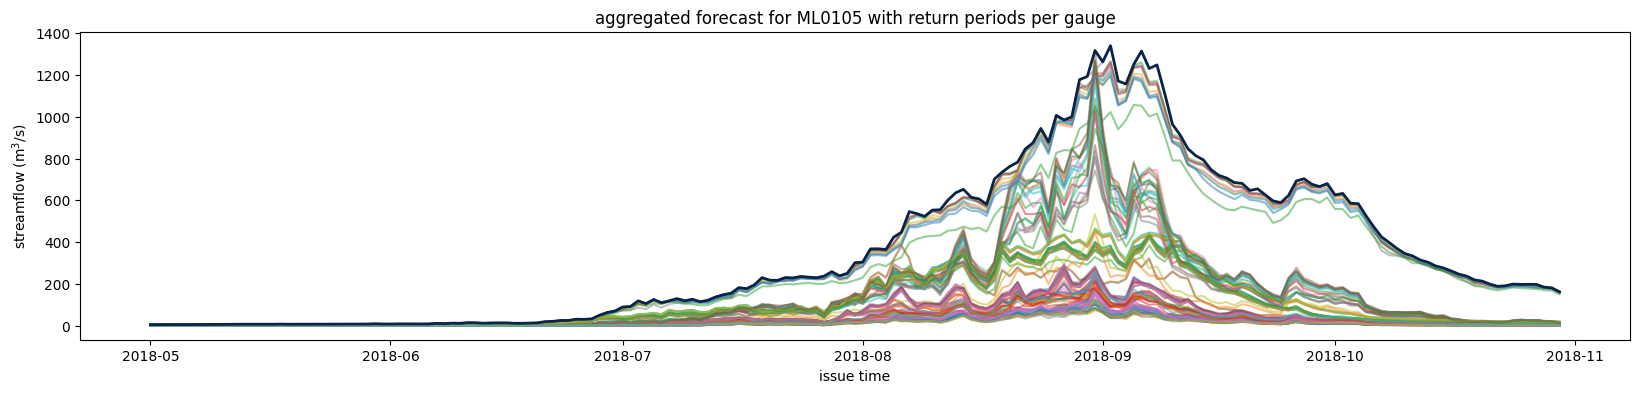

In [851]:
l_gauges_admin_unit_most, admin_unit_most_gauges = \
    get_datasets_unit_with_most_gauges(dict_datasets_au, dict_datasets)

plot_aggregated_reforecast('2018-05-01', '2018-10-30',
                           l_gauges_admin_unit_most,
                           dict_datasets_au[admin_unit_most_gauges])

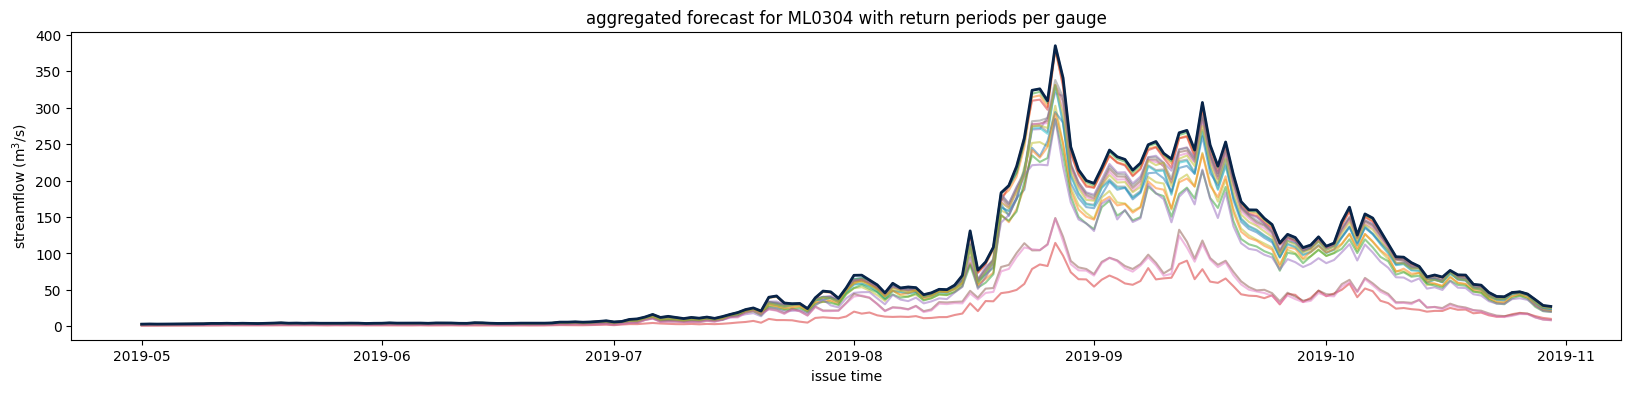

In [852]:
l_gauges_xth_admin_unit, admin_unit_xth_gauges = \
    get_datasets_for_xth_admin_unit(dict_datasets_au, dict_datasets, 15)

plot_aggregated_reforecast('2019-05-01', '2019-10-30',
                           l_gauges_xth_admin_unit,
                           dict_datasets_au[admin_unit_xth_gauges])

In [853]:
# # To determine when to trigger and identify an "event", we need to
# # choose how we want to aggregate the return periods of each gauge
# # into one value for the administrative unit. Multiple options can 
# # be argued for, but we will start with the mean value of the return
# # periods of the gauges in the administrative unit, with the reasoning
# # that minima and maxima can be too extreme/skewed
# import pandas as pd
# import geopandas as gpd
# import numpy as np
# import xarray as xr
# from typing import Dict, List


# # def get_upstream_gauge_return_period(
# #         admin_unit: str,
# #         dict_ds_au: Dict[str, xr.Dataset],
# #         dict_return_periods: Dict[str, xr.Dataset],
# #         rp_value: int = 5,
# #     ) -> float:
# #     """
# #     Searches in the admin unit for the gauge that is the most "upstream"

# #     :param admin_unit: administrative unit ID
# #     :param dict_ds_au: dict of datasets per admin unit
# #     :param dict_return_periods: dictionary of return period dataset per gauge
# #     :param rp_value: return period value to aggregate
# #     :return: return period value of the most upstream gauge
# #     """
    

# def aggregate_return_periods(
#         dict_ds_au: Dict[str, xr.Dataset],
#         dict_return_periods: Dict[str, xr.Dataset],
#         rp_value: int = 5,
#         method: str = 'mean'
#     ) -> Dict[str, xr.Dataset]:
#     """
#     Aggregate return periods per administrative unit based on the specified method
    
#     :param dict_datasets_au: dict of datasets per admin unit
#     :param dict_return_periods: dictionary of return period dataset per gauge
#     :param rp_value: return period value to aggregate
#     :param method: aggregation method ('min', 'mean', 'max', 'upstream')
#     :return: dict with admin unit ID : dataset with rp dataaset
#     """
#     if rp_value not in [2, 5, 20]:
#         raise ValueError("threshold must be 2, 5, or 20")
#     return_periods_per_admin = {}
#                                     # for each admin unit ds:
#     for admin_unit, ds in dict_ds_au.items():
#         return_period_values = []   # loop through its gauges and get the return periods
#         for gauge_id in ds.attrs['gauge_ids']:
#             if f'hybas_{gauge_id}' in dict_return_periods:
#                 return_period_ds = dict_return_periods.get(f'hybas_{gauge_id}')
#             else:
#                 print(f'No return period dataset found for gauge {gauge_id}')
#                 continue
#                                     # store the return period value of choice
#             if f'return_period_{rp_value}' in return_period_ds:
#                 return_period_values.append(return_period_ds[f'return_period_{5}'].item())
#             else:
#                 print(f'No return period value {rp_value} found for gauge {gauge_id}')
#                                     # store the return period values per admin unit
#         return_periods_per_admin[admin_unit] = return_period_values

#     print(return_periods_per_admin)
#     # aggregate with method of choice
#     aggregated_return_periods = {}
#     for admin_unit, values in return_periods_per_admin.items():
#         if method == 'min':
#             aggregated_value = np.min(values)
#         elif method == 'mean':
#             aggregated_value = np.mean(values)
#         elif method == 'max':
#             aggregated_value = np.max(values)
#         # elif method == 'upstream':
#         #     aggregated_value = get_upstream_gauge_return_period(admin_unit,
#         #                                                         dict_ds_au,
#         #                                                         dict_return_periods,
#         #                                                         rp_value)
#         else:
#             raise ValueError("Method not recognised")

#         # create and save new dataset with the aggregated rp's
#         aggregated_return_periods[admin_unit] = xr.Dataset({
#                 'return_period_5': aggregated_value
#             }, attrs = {
#                 'admin_unit': admin_unit
#             })

#     return aggregated_return_periods

In [897]:
def export_dict_flood_events_to_csv(
        dict_flood_events: Dict[str, pd.DataFrame], th: Any,
        lt: int, verbose: bool = False
    ) -> None:
    """
    Export the dictionary with flood events to a csv file
    with a MultiIndex for keys and events

    :param dict_flood_events: dictionary with flood events
    :param th: return period threshold
    :param lt: lead time
    :param verbose: whether to print some test print-s's
    """
    if not dict_flood_events:
        print('No flood events found')
        return
    df_flood_events = pd.concat(dict_flood_events,
                                names = ['admin_unit', 'events'])
    print(df_flood_events) if verbose else None
                            # sort the index to make the csv file more readable
    df_flood_events = df_flood_events.sort_index()
                            # add n_flood_events to name to
                            # see difference between files
    n_flood_events = df_flood_events.shape[0]
    print(f'exporting {n_flood_events} flood events to csv')
    
    if th in [95, 98, 99]:
        th_str = f'{th}pc'
    else:
        th_str = f'{th}rp'
    df_flood_events.to_csv(
        f'../data/processed/flood_events/flood_events_au_{lt * 24}lt_{th_str}_n{n_flood_events}.csv',
        sep = ';', decimal = '.')
    
    
def create_flood_mask(
        ds: xr.Dataset, threshold: int = 5
    ) -> np.ndarray:
    """
    Creates a boolean mask to identify when the streamflow
    exceeds the return period threshold

    :param ds: dataset with streamflow data
    :param threshold: return period threshold
    :return: boolean mask
    """
    if f'RP_{threshold}' not in ds.attrs and f'pc_{threshold}th' not in ds.attrs:
        raise ValueError(f"No return period key ({threshold}) found for {ds.attrs['admin_unit']}")
    # if ds.attrs[f'RP_{threshold}'] is None and ds.attrs[f'pc_{threshold}th'] is None:
    #     raise ValueError(f"No return period value ({threshold}) found for {ds.attrs['admin_unit']}")

    # return a boolean mask where True indicates that the streamflow
    # exceeds the return period threshold for the administrative unit
    if f'RP_{threshold}' in ds.attrs:
        return ds['streamflow'] > ds.attrs[f'RP_{threshold}']
    else:
        return ds['streamflow'] > ds.attrs[f'pc_{threshold}th']


def merge_sequential_flood_events(
        df: pd.DataFrame, ds: xr.Dataset, action_lifetime: int = 10
    ) -> pd.DataFrame:
    """
    Merge flood events that are within one action lifetime of one another

    :param df: DataFrame with flood events
    :param ds: dataset with streamflow data (for calculation of peak streamflow)
    :param action_lifetime: days allowed between events
    :return: DataFrame with merged flood events
    """
                            # convert the DataFrame to a list of dictionaries
    list_events = [df.iloc[0].to_dict()]
    for idx in range(1, len(df)):
                            # for each flood event, get the current and last event,
                            # check if they are within the action lifetime of one another
                            # and merge them if they are
        current_event = df.iloc[idx]
        last_event = list_events[-1]

        days_between = (pd.Timestamp(current_event['flood_start']) - \
                        pd.Timestamp(last_event['flood_end'])).days
        if days_between <= action_lifetime:
                            # within if-s, merge events
            last_event['flood_end'] = pd.Timestamp(current_event['flood_end'])
            last_event['duration'] = (last_event['flood_end'] - last_event['flood_start']).days + 1
                            # recompute peak_streamflow over the new period
            last_event['peak_streamflow'] = ds['streamflow'].sel(
                issue_time = slice(last_event['flood_start'], last_event['flood_end'])
            ).max().item()
        else:
                            # else, no merge needed
            list_events.append(current_event.to_dict())

    return pd.DataFrame(list_events)


def create_flood_events(
        dict_ds_au: Dict[str, xr.Dataset],
        merge = True,
        threshold: int = 5,
        action_lifetime: int = 10
    ) -> Dict[str, pd.DataFrame]:
    """
    Creates flood events based on the return period threshold.
    A flood event is defined as a consecutive period where the
    streamflow exceeds the given threshold for the return period

    :param dict_ds_au: dict of ds per admin unit
    :param threshold: rp-value to trigger flood event (default is 5)
    :param action_lifetime: days allowed between events (default is 10)
    :return: dict with df of flood events per admin unit
    """
    if threshold not in [1.5, 2, 5, 7, 10, 20, 95, 98, 99]:
        raise ValueError("threshold must be 1.5, 2, 5, 7, 10, 20")
    # ds_rp_agg = aggregate_return_periods(dict_ds_au, ds_rp_agg, threshold)
    
    flood_events_per_au = {}    # for each admin unit ds:
    for admin_unit, ds in dict_ds_au.items():
                                # create a boolean mask to identify when
                                # the streamflow exceeds the return period threshold
        flood_mask = create_flood_mask(ds, threshold)
        
        flood_events = []
                                # find the start and end of flood events by checking
                                # consecutive True values in the mask
        flood_start, flood_end = None, None
        for idx, is_flood in enumerate(flood_mask):
            if is_flood and flood_start is None:
                                # start of a new flood event
                flood_start = ds['actual_date'].values[idx]
            elif not is_flood and flood_start is not None:
                                # end of the current flood event
                flood_end = ds['actual_date'].values[idx - 1]
                                # inclusive difference (+1) between the two dates;
                                # if the flood event is only one day, the duration is 1;
                                # and, if duration == 1, the event is ignored, as,
                                # hydrologically, the river is expected to handle it
                duration = pd.Timedelta(flood_end - flood_start).days + 1
                if duration == 1:
                    flood_start, flood_end = None, None
                    continue
                                # store the flood event details
                flood_events.append({
                    'flood_start': flood_start,
                    'flood_end': flood_end,
                    'duration': duration,
                    'peak_streamflow': \
                        ds['streamflow'].sel(issue_time = slice(flood_start,
                                                                flood_end)).max().item()
                })
                                # reset flood_start and flood_end
                flood_start, flood_end = None, None
                                # by now, if flood_start is not None,
                                # it means the flood event is still going
        if flood_start is not None:
            flood_end = ds['actual_date'].values[-1]
            flood_events.append({
                'flood_start': flood_start,
                'flood_end': flood_end,
                'duration': pd.Timedelta(flood_end - flood_start).days + 1,
                'peak_streamflow': \
                    ds['streamflow'].sel(issue_time = \
                                         slice(flood_start, flood_end)).max().item()
            })

                                # store the flood events per admin unit in a df,
                                # and merge sequential flood events when needed
                                # (as they are likely the same event)
        df = pd.DataFrame(flood_events)
        if df.empty:            # if no flood events are found, skip the admin unit
            print('No flood events found for admin unit', admin_unit)
            continue

        if merge and len(flood_events) > 0:       
            df = merge_sequential_flood_events(df, ds, action_lifetime)
        flood_events_per_au[admin_unit] = df

    return flood_events_per_au

In [855]:
# Note that the flood events are already calculated by their "actual date",
# hence, we export it using LEAD_TIME (* 24 hours) as lead time identifier
dict_flood_events_per_admin = create_flood_events(dict_datasets_au, True, THRESHOLD)
export_dict_flood_events_to_csv(dict_flood_events_per_admin, THRESHOLD, LEAD_TIME)

exporting 156 flood events to csv


In [856]:
def plot_agg_reforecast(start_date: str, end_date: str,
                        ds_rf: xr.Dataset, threshold: int = 5,
    ) -> None:
    """
    Plots aggregated reforecast data for a given time range

    :param start_date: start date for the time range
    :param end_date: end date for the time range
    :param ds_rf: reforecast dataset of admin unit
    :param thresholds: list of thresholds to add return periods for
    """
    fig, ax = plt.subplots(figsize = (20, 4))
    ds_subset = ds_rf.streamflow.sel(issue_time = slice(start_date, end_date))
    
    ax.plot(ds_subset.issue_time, ds_subset.values)
    ax.axhline(y = ds_rf.attrs[f'RP_{threshold}'], color = 'orange',
               label = f'{threshold}-yr return period', linestyle = '--'
    )
    ax.set_title(f'Reforecast data for {ds_rf.attrs["admin_unit"]} with {threshold}-yr return period')
    plt.legend(loc = 'upper right')
    plt.show()

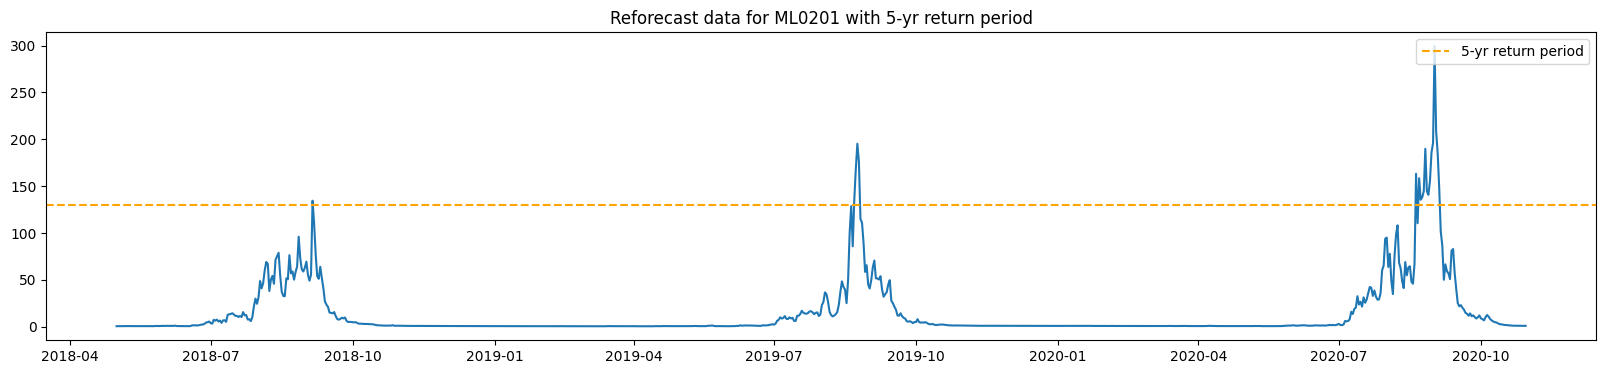

In [857]:
# Check whether the flood events are correctly created using some plots:
"""
ML0201;0;2018-09-05;2018-09-05;0;134.45091247558594
ML0201;1;2019-08-20;2019-08-20;0;128.57044982910156
ML0201;2;2019-08-22;2019-08-26;4;195.2600860595703
ML0201;3;2020-08-20;2020-08-20;0;163.1853790283203
ML0201;4;2020-08-22;2020-09-04;13;299.27252197265625
"""
# ML0201, for example, has 5 flood events, with some having a duration of 1 day
# Let's investigate with a plot and see if this has been processed correctly
issue_time_start_date = '2018-05-01'
issue_time_end_date = '2020-10-30'

plot_agg_reforecast(issue_time_start_date, issue_time_end_date, dict_datasets_au['ML0201'])

In [858]:
# # Manual .xlsx to .csv conversion errors, so we'll recreate the .csv manually
# """
# df_impact_data = pd.read_csv('../data/impact_data/impact_data_Mali.csv',
#                              sep = ',',
#                              header = 0,
#                              encoding = 'utf-8')
# print(df_impact_data.head())
# """
# import openpyxl
# import csv

# sheet = openpyxl.load_workbook('../data/impact_data/impact_data_Mali.xlsx').active

# with open('../data/impact_data/impact_data_Mali_recreated.csv',
#           'w',
#           newline = '',
#           encoding = 'utf-8') as csvfile:
#     csvwriter = csv.writer(csvfile, delimiter = ';')
#     for row in sheet.iter_rows():
#         csvwriter.writerow([cell.value if cell.value is not None else "" for cell in row])

# df_impact_data = pd.read_csv('../data/impact_data/impact_data_Mali_recreated.csv',
#                                 sep = ',',
#                                 header = 0,
#                                 encoding = 'utf-8')
# print(df_impact_data.columns)
# print(df_impact_data.head())

In [859]:
# the next step is to load in the impact data and to transform it to
# a format that is similar to the flood events, such that we can compare
# and evaluate the model's performance
df_impact_data = pd.read_csv('../data/impact_data/impact_data_Mali.csv',
                                sep = ',',
                                header = 0,
                                encoding = 'utf-8')

print(df_impact_data.columns)
print(df_impact_data.head())

Index(['ID', 'Années', 'Mois', 'Jours', 'Start Date', 'End Date',
       'Duration (Days)', 'Pays', 'Région', 'Cercle', 'Commune',
       'Quartier/Villages', '#Ménages touchés', '#Personnes affectées',
       '#Ménages sinistrées', '#Personnes sinistrées', '#Personnes blessées',
       'Personnes déplacées', '#Personnes décedées', 'Sum personnes affectées',
       '#Maisons endommagées', '#Maisons detruites', '#Ecole endommagées',
       '#Ecole occupées', '#Points d'eau endommagés', '#Latrines détruites',
       '# Magasins effondres', 'Vivres (T)', 'Superficie Cultures (ha)',
       'Betails', 'Volailles', 'Sum maisons et services affectées',
       'Hauteur pluie (mm)', 'Autres dégâts', 'Alimentaires', 'Abris',
       'Kits WASH', 'NFI', 'Autres réponses', 'Sum réponse',
       'Organisations ayant apporté d'assistance', 'Besoins Non couverts',
       'Column1', 'Source', 'Document initial', 'Tab document initial',
       'Event Duration', 'Unnamed: 0', 'region (adm1)', 'cercle (ad

In [860]:
import json


def fill_cercle_from_commune(d: Dict[str, List[str]], row: pd.Series) -> str:
    """ 
    Tries to fill in an empty 'Cercle' column with the corresponding
    'Cercle' value from the 'Commune' entry in the dict if there is one

    :param dict: dictionary with commune-cercle mapping
    :param row: row from df
    :return: 'Cercle' value (hopefully)
    """
    if pd.isna(row['Cercle']) or row['Cercle'].strip() == '':
        commune = row['Commune']
        if commune in d and len(d[commune]) == 1:
            return d[commune][0]
        else:
            return row['Cercle']
    else:
        return row['Cercle']


def export_dict_impact_events_to_csv(
        dict_impact_events: Dict[str, pd.DataFrame], verbose: bool = False
    ) -> None:
    """
    Export the dictionary with impact events to a csv file
    with a MultiIndex for keys and events

    :param dict_flood_events: dictionary with flood events
    """
    list_df_impact_events = []
    for admin_unit, df in dict_impact_events.items():
        df = df.copy()
        df.reset_index(inplace = True)
        df['admin_unit'] = admin_unit
        list_df_impact_events.append(df)

    df_flood_events = pd.concat(list_df_impact_events, ignore_index = True)

    print(df_flood_events) if verbose else None
    print(f'exporting {df_flood_events.shape[0]} impact events to csv')
    df_flood_events.to_csv(
        f'../data/processed/flood_events/impact_events_au_{df_flood_events.shape[0]}.csv',
        sep = ';', decimal = '.', index = False)
    

def map_cercle_names_to_pcodes(
        df: pd.DataFrame,
        path: str = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp',
        verbose: bool = False
        ) -> Dict[str, str]:
    """
    Maps the Cercle names in the impact data to the pcodes found in the
    shape file of the administrative units and used for the flood events

    :param df: dataframe with impact data
    :param path: path to the shape file
    :param verbose: whether to print some test prints
    :return: dictionary with Cercle names mapped to pcodes
    """
                        # load shape file and normalise columns of interest
    gdf = analyse.get_shape_file(path).to_crs('EPSG:4326')
    gdf['ADM2_FR'] = gdf['ADM2_FR'].str.strip().str.upper()\
                        .str.normalize('NFKD').str.encode('ascii',errors = 'ignore')\
                            .str.decode('utf-8') 
                        # use the print statements to compare admin unit names
                        # of the shape file and of the impact data
    # print(np.sort(gdf['ADM2_FR'].unique()))
                        # print out the identifiers in the impact data which are not
                        # found in the shape file, so we can manually check and correct
    if verbose:
        print('Identifiers in impact data not found in shape file:')
        print(np.sort(np.setdiff1d(df['Cercle'].unique(), gdf['ADM2_FR'].unique())))
                        # the print statement above and this one produce:
    """
    ['ABEIBARA' 'ANDERAMBOUKANE' 'ANSONGO' 'BAFOULABE' 'BAMAKO' 'BANAMBA'
    'BANDIAGARA' 'BANKASS' 'BARAOUELI' 'BLA' 'BOUGOUNI' 'BOUREM' 'DIEMA'
    'DIOILA' 'DIRE' 'DJENNE' 'DOUENTZA' 'GAO' 'GOUNDAM' 'GOURMA-RHAROUS'
    'INEKAR' 'KADIOLO' 'KANGABA' 'KATI' 'KAYES' 'KENIEBA' 'KIDAL' 'KITA'
    'KOLOKANI' 'KOLONDIEBA' 'KORO' 'KOULIKORO' 'KOUTIALA' 'MACINA' 'MENAKA'
    'MOPTI' 'NARA' 'NIAFUNKE' 'NIONO' 'NIORO' 'SAN' 'SEGOU' 'SIKASSO'
    'TENENKOU' 'TESSALIT' 'TIDERMENE' 'TIN-ESSAKO' 'TOMBOUCTOU' 'TOMINIAN'
    'YANFOLILA' 'YELIMANE' 'YOROSSO' 'YOUWAROU']
    <class 'numpy.ndarray'>
    ['GOUMERA' 'ESSOUK' 'INTACHDAYTE' 'AGUELHOK' 'TAMKOUTAT' 'ZEGOUA' 'SONA'
    'KOURY' 'BIRAMABOUGOU' 'SANDIA' 'TOUBAKORO' 'KENEKOUN']
    """
                        # create a mapping from Cercle names to pcodes
    mapping = gdf.set_index('ADM2_FR')['ADM2_PCODE'].to_dict()
                        # some manual corrections made by searching Google Maps and GeoView
    manual_corrections = {
        'GOUMERA' : mapping.get('KAYES'),
        'ESSOUK' : mapping.get('KIDAL'),
        'INTACHDAYTE' : mapping.get('KIDAL'),
        'AGUELHOK' : mapping.get('TESSALIT'),
        'TAMKOUTAT' : mapping.get('GAO'),
        'ZEGOUA' : mapping.get('KADIOLO'),
        'SONA' : mapping.get('YOROSSO'),
        'KOURY' : mapping.get('YOROSSO'),
        'BIRAMABOUGOU' : mapping.get('SIKASSO'),
        'SANDIA' : mapping.get('KAYES'),
        'TOUBAKORO' : mapping.get('KOULIKORO'),
        'KENEKOUN' : mapping.get('KANGABA')
    }
                        # update the mapping with the manual corrections
                        # and apply the mapping to the 'Cercle' column    
    mapping.update(manual_corrections)
                        # save PCODE as the standard an NAME as subsidiary
    df['admin_unit'] = df['Cercle'].apply(lambda x: mapping.get(x, None))
    df['admin_unit_NAME'] = df['Cercle']
    print(df.head()) if verbose else None
                        # handle unmapped Cercle values
    unmapped_cercles = df[df['admin_unit'].isnull()]['Cercle'].unique()
    if unmapped_cercles.size > 0:
        raise ValueError(f'Unmapped Cercle values: {unmapped_cercles}')
    
                        # at last, export the mapping as a .json file with
                        # as keys the pcodes and as values the Cercle names,
                        # and also the inverse mapping (it should exist)
    with open('../data/mappings/Cercle_to_PCODE.json', 'w') as f:
        json.dump(mapping, f, indent = 4)
    inverse_mapping = {v: k for k, v in mapping.items()}
    with open('../data/mappings/PCODE_to_Cercle.json', 'w') as f:
        json.dump(inverse_mapping, f, indent = 4)

    return df


def merge_duplicate_events(d_events: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Filter out double impact events by checking whether events have the 
    same start date, and then merge them to an event with the start date
    of the first, and end date of the last event with the same start date.
    Added later: also adjacent or overlapping events are merged.

    :param dict_events: dict with au codas keys and events dfs as values
    :return: same dict, but merged
    """
    d_events_merged = {}

    for admin_unit, df_events in d_events.items():
                            # bring event_ID back as column
        df_events = df_events.reset_index()
        # grouped = df_events.groupby('flood_start')

        merged_rows = []
        current_event = df_events.iloc[0].to_dict()
        # for flood_start, group in grouped:
        for idx in range(1, len(df_events)):
            next_event = df_events.iloc[idx].to_dict()

            if next_event['flood_start'] <= current_event['flood_end']:
                current_event['flood_end'] = max(current_event['flood_end'], next_event['flood_end'])
                current_event['duration'] = (current_event['flood_end'] - \
                                             current_event['flood_start']).days + 1
            else:
                merged_rows.append(current_event)
                current_event = next_event.copy()
        merged_rows.append(current_event)

        
            #                 # if one event, don't merge
            # if len(group == 1):
            #     merged_rows.append(group.iloc[0])
            # else:
            #                 # find the latest flood end
            #                 # and update columns accordingly
            #     idx_max_end = group['flood_end'].idxmax()
            #     max_end_row = group.loc[idx_max_end].to_dict()
            #     max_end_row['flood_end'] = group['flood_end'].max()
            #     max_end_row['duration'] = (max_end_row['flood_end'] - \
            #                                max_end_row['flood_start']).days + 1
            #     merged_rows.append(max_end_row)
                     
        merged_events = pd.DataFrame(merged_rows)
        merged_events.set_index('event_ID', inplace = True)
        merged_events.sort_values('flood_start', inplace = True)
        d_events_merged[admin_unit] = merged_events            

    return d_events_merged


def process_impact_data_to_events(
        df: pd.DataFrame, verbose: bool = False
    ) -> Dict[str, pd.DataFrame]:
    """
    Process the "raw" impact data to events similar
    to the events created from the flood data, with
    specifically, per administative unit:
    - start date of the event;
    - end date of the event;
    - duration of the event; and
    
    Here, especially classification into administrative units
    is problematic, as some data is missing. How this is handled
    can vary per your specific use case, and for missing rows
    information is printed when verbose is True

    :param df: dataframe with impact data
    :param verbose: whether to be verbose
    :return: dictionary with events per administrative unit
    """                  
                        # keep only (possitbly) relevant columns, of which notable:
                        # - 'Start date' and 'End date': self-explanatory
                        # - 'Cercle': administrative unit
                        # - the rest gives more location information, which might be
                        #   useful if administrative unit information is missing
    df = df[['Start Date', 'End Date', 'Région', 'Cercle', 'Commune', 'Quartier/Villages']].copy()
                        # rename 'Start date' and 'End date' to 'flood_start' and 'flood_end'
                        # and convert them to datetime objects with flag 'raise' for errors:
                        # if any dates are missing they can be reconstructed using the
                        # 'Années', 'Mois', and 'Jours' columns, but was not needed here
    df.rename(columns = {'Start Date': 'flood_start', 'End Date': 'flood_end'}, inplace = True)
    df['flood_start'] = pd.to_datetime(df['flood_start'], format = '%d/%m/%Y', errors = 'raise')
    df['flood_end'] = pd.to_datetime(df['flood_end'], format = '%d/%m/%Y', errors = 'raise')
                        # after printing out rows with missing dates with the following line:
    """
    print(df[df['flood_start'].isnull() | df['flood_end'].isnull()]) if verbose else None
    """ 
                        # row 133 was empty, so we drop it
    df.dropna(subset = ['flood_start', 'flood_end'], inplace = True)
                        # double check if no dates are missing
    if df['flood_start'].isnull().values.any() or df['flood_end'].isnull().values.any():
        raise ValueError('Missing dates in impact data')
                        # next, we normalise 'Cercle' column to no whitespace and uppercase,
                        # and also delete any accents on top of letters or dashes etc to make
                        # sure the 'Cercle' column is as clean and uniform as possible
    df['Cercle'] = df['Cercle'].str.strip().str.upper()
    df['Cercle'] = df['Cercle'].str.normalize('NFKD').str.encode('ascii', errors = 'ignore').str.decode('utf-8')
                        # solve some other specific naming ambiguities:
    df['Cercle'] = df['Cercle'].str.replace(r'\bTOMBOUCTO\b', 'TOMBOUCTOU', regex = True)
    df['Cercle'] = df['Cercle'].str.replace(r'\bGOURMA-RH\b', 'GOURMA-RHAROUS', regex = True)
    df['Cercle'] = df['Cercle'].str.replace('NIAFUNKE + MORE LOCATIONS', 'NIAFUNKE')
    df['Cercle'] = df['Cercle'].str.replace(r'\bBANDIAGAR\b', 'BANDIAGARA', regex = True)
    df['Cercle'] = df['Cercle'].str.replace('BAROUELI', 'BARAOUELI')
    df['Cercle'] = df['Cercle'].str.replace('DIOLA', 'DIOILA')
    df['Cercle'] = df['Cercle'].str.replace('NIANFUNKE', 'NIAFUNKE')
    df['Cercle'] = df['Cercle'].str.replace('ASANGO', 'ANSONGO')
    df['Cercle'] = df['Cercle'].str.replace('KOLONDIEB', 'KOLONDIEBA')

                        # to handle missing 'Cercle' information, we make a mapping/dict
                        # with as key the Commune (which is a subset of Cercle) and as
                        # value the corresponding Cercle, which can be used after to fill
                        # in missing Cercle information. We also check if there are not
                        # illogical double entries, which would need manual handling. We
                        # also change Cercle names with 'District' to NaN, so they can maybe
                        # be picked up by the Commune-Cercle mapping
    df['Cercle'] = df['Cercle'].replace('DISTRICT', np.nan)
    df['Commune'] = df['Commune'].str.strip().str.upper()
    dict_communce_cercle = df.groupby('Commune')['Cercle'].unique().to_dict()
                        # delete NaN's from the arrays itself in the dictionary;
                        # loop over all dictionary items and remove NaN's
    for commune, cercles in dict_communce_cercle.items():
        dict_communce_cercle[commune] = [cercle for cercle in cercles if isinstance(cercle, str)]
                        # check whether a commune is associated w/ a missing or multiple cercles
    for commune, cercles in dict_communce_cercle.items():
        if len(cercles) == 1 and (not isinstance(cercles[0], str) or cercles[0].strip() == ''):
            if verbose:
                print(f"Commune '{commune}' is associated with a missing Cercle")
    for commune, cercles in dict_communce_cercle.items():
        if len(cercles) > 1:
            if verbose:
                print(f"Commune '{commune}' is associated with multiple Cercles: {cercles}")
                        # which prints:
    """
    Commune 'BLA' is associated with multiple Cercles: ['SAN', 'BLA']
    Commune 'LOGO' is associated with multiple Cercles: ['YELIMANE', 'KAYES']
    Commune 'TIENFALA' is associated with multiple Cercles: ['BOUGOUNI', 'KOULIKORO']
    """
                        # so we handle these manually (after checking Google Maps etc.)
    dict_communce_cercle['BLA'] = ['SEGOU']
    dict_communce_cercle['LOGO'] = ['KAYES']
    dict_communce_cercle['TIENFALA'] = ['KOULIKORO']

                        # next, we fill in missing 'Cercle' information with the dictionary
                        # we created above, and we print out the rows with missing 'Cercle'
    df['Cercle'] = df.apply(lambda row: fill_cercle_from_commune(dict_communce_cercle, row),
                            axis = 1)
    df_missing_cercle = df[df['Cercle'].isnull() | \
        df['Cercle'].apply(lambda x: not isinstance(x, str) or x.strip() == '')]
    if verbose:         # Note: the above modifications "saved" 13 flood events
        print(f'\nImpact events without Cercle info: {df_missing_cercle.shape[0]}')
        print(f'Impact events with Cercle info: {df.shape[0] - df_missing_cercle.shape[0]}\n')
                        # Note: if after above, 'Cercle' is still missing, we *could* try
                        # and see if the 'Region' column is (coincidently?) the same as a
                        # 'Cercle' column, but we ignore this possibility for now.
                        # Next, we separate the data which has no 'Cercle' information
                        # and drop the three unnecessary remaining columns 
    df = df[~df.index.isin(df_missing_cercle.index)]
                        #! Comment this to not drop the indicated columns and also
                        #! add them to the line: df_events = df_group[[...]] column list
                        #! Don't forget the line which gets rid of the accent in Region
    df = df.drop(columns = ['Région', 'Commune', 'Quartier/Villages'])
    # df = df.rename(columns = {'Région': 'Region'})
                        # calculate the duration of each flood event and add as column,
                        # where the difference is inclusive, so we add 1 to the result
    df['duration'] = (df['flood_end'] - df['flood_start']).dt.days + 1

                        # next, we map the names of the 'Cercle' column to the admin units
                        # in the flood data, and we check if all 'Cercle' values are mapped
    df = map_cercle_names_to_pcodes(df) 
    df_missing_mapping = df[df['admin_unit'].isnull()]
    if df_missing_mapping.shape[0] > 0:
        print(f'unmapped Cercle values: {df_missing_mapping["Cercle"].unique()}')
    # df.to_csv('../data/impact_data/impact_data_Mali_tidied.csv')
                        # lastly, we group the data by 'Cercle' and create a dictionary
                        # with the 'Cercle' as key and the corresponding dataframe as value
    dict_events = {}
                        # order the data and store in dictionary
    for cercle, df_group in df.groupby('admin_unit'):
                        # ensure chronological order of the events
        df_group = df_group.sort_values(by = ['flood_start', 'flood_end']).reset_index(drop = True)
                        # give events an identifier and set as index
        df_group['event'] = df_group.index
        df_group['event_ID'] = df_group.apply(lambda x: f"{cercle}_{x['event']}",
                                              axis = 1)
        df_group.set_index('event_ID', inplace = True)
        df_events = df_group[['admin_unit_NAME', 'admin_unit',
                              'flood_start', 'flood_end', 'duration',]]
                                # 'Region', 'Commune', 'Quartier/Villages']]
        dict_events[cercle] = df_events
        
                        # merge duplicate events
    dict_events_merged = merge_duplicate_events(dict_events)
                        # sort again
    for _, value in dict_events_merged.items():
        value.sort_values(by = ['flood_start', 'flood_end'], inplace = True)

                        # export to csv and return
    export_dict_impact_events_to_csv(dict_events_merged, verbose)
    return dict_events_merged

In [861]:
dict_impact_events = process_impact_data_to_events(df_impact_data, False)

exporting 525 impact events to csv


In [862]:
# Next and final step of impact data preprocessing is subsetting by the available dates
# in the forecast data and by the available administrative units in the forecast data
def determine_min_max_date_of_dataset(d_ds: Dict[str, xr.Dataset]) -> Tuple[str, str]:
    """
    Determine the earliest and latest date of the datasets

    :param d_ds: dictionary with datasets
    :return: tuple with earliest and latest date
    """
    earliest_dates = []
    latest_dates = []
    for ds in d_ds.values():
        earliest_dates.append(ds['issue_time'].values[0])
        latest_dates.append(ds['issue_time'].values[-1])

    return min(earliest_dates), max(latest_dates)


def subset_events_on_unit_and_date(
        d_impact_events: Dict[str, pd.DataFrame],
        d_forecast_units: Dict[str, xr.Dataset],
        earliest_date: str, latest_date: str
    ) -> Dict[str, pd.DataFrame]:
    """
    Subset impact events based on available forecast administrative units 
    and specified date range. Events are filtered to include only those 
    within the specified date range and belonging to administrative units 
    present in the forecast data. Administrative units with no valid impact 
    data within the date range or not in the forecast data are logged
    
    :param d_impact_events: dictionary with impact events
    :param d_units: dictionary with available administrative units, i.e.
                    the units for which forecast data is available
    :param earliest_date: earliest date
    :param latest_date: latest date
    :return: dictionary with subsetted events
    """
    d_subsetted = {}
    l_no_impact_data = []
    earliest_date = pd.to_datetime(earliest_date)
    latest_date = pd.to_datetime(latest_date)
                            # for every admin unit in the impact data:
    for admin_unit, df in d_impact_events.items():
                            # check if it is in the forecast data
                            # and, if so, if it is in the time range
        if admin_unit in d_forecast_units:
            df_c = df.copy()
            df_c['flood_start'] = pd.to_datetime(df_c['flood_start'])
            df_c['flood_end'] = pd.to_datetime(df_c['flood_end'])

            df_subset = df_c[(df_c['flood_start'] >= earliest_date) & \
                             (df_c['flood_end'] <= latest_date)]
                            # if the subset is not empty, add to dict
            if not df_subset.empty:
                d_subsetted[admin_unit] = df_subset
            else:
                print(f'\tno impact data found for {admin_unit}')
                l_no_impact_data.append(admin_unit)
        else:
            print(f'{admin_unit} impact data discarded due to lack of forecast data')
    
    return d_subsetted, l_no_impact_data

In [863]:
                            # determine available units and earliest and latest dates
available_admin_units = set(dict_datasets_au.keys())
earliest_date, latest_date = determine_min_max_date_of_dataset(dict_datasets_au)
                            # subset the impact events on the available units and dates
dict_impact_events_final, _ = subset_events_on_unit_and_date(
    dict_impact_events, available_admin_units, earliest_date, latest_date)
export_dict_impact_events_to_csv(dict_impact_events_final)

	no impact data found for ML0102
	no impact data found for ML0104
ML0106 impact data discarded due to lack of forecast data
	no impact data found for ML0201
	no impact data found for ML0303
	no impact data found for ML0306
ML0307 impact data discarded due to lack of forecast data
	no impact data found for ML0403
ML0407 impact data discarded due to lack of forecast data
ML0501 impact data discarded due to lack of forecast data
	no impact data found for ML0502
	no impact data found for ML0507
ML0801 impact data discarded due to lack of forecast data
ML0802 impact data discarded due to lack of forecast data
ML0803 impact data discarded due to lack of forecast data
ML1001 impact data discarded due to lack of forecast data
exporting 110 impact events to csv


In [864]:
def filter_flood_events_by_impact_per_year(
    d_floods: Dict[str, pd.DataFrame], d_impacts: Dict[str, pd.DataFrame]
) -> Dict[str, pd.DataFrame]:
    """
    Filters flood events per administrative unit and per year, excluding flood
    events for years where there is no impact data for that administrative unit

    :param d_floods: dict of flood events per admin unit
    :param d_impacts: dict of impact events per admin unit
    :return: filtered dict of flood events per admin unit
    """
    d_floods_filtered = {}

    for admin_unit, df_floods in d_floods.items():
                            # if there is impact data at all for the flood
                            # events, then start filtering by year; if not,
                            # the flood events are discarded entirely
        if admin_unit in d_impacts:
                            # make copy and ensure datatypes
            df_floods_c = df_floods.copy()
            df_impacts_c = d_impacts[admin_unit].copy()
            df_floods_c['flood_start'] = pd.to_datetime(df_floods_c['flood_start'])
            df_floods_c['flood_end'] = pd.to_datetime(df_floods_c['flood_end'])
            df_impacts_c['flood_start'] = pd.to_datetime(df_impacts_c['flood_start'])
            df_impacts_c['flood_end'] = pd.to_datetime(df_impacts_c['flood_end'])
                            # get set of impact years, and add a 'year' column
                            # to flood events for filtering
            impact_years = set(df_impacts_c['flood_start'].dt.year.unique())
            df_floods_c['year'] = df_floods_c['flood_start'].dt.year
                            # get set of original flood event years
                            # and filter, getting a df with just flood events for
                            # years where there is impact data available
            original_years = set(df_floods_c['year'].unique())
            df_floods_c = df_floods_c[df_floods_c['year'].isin(impact_years)]
                            # get set of excluded years and drop the 'year' column again
            excluded_years = original_years - impact_years
            df_floods_c.drop(columns = ['year'], inplace = True)

                            #* explanation of printing statements:
                            #* no \t:  best case scenario, all flood events retained
                            #* one \t: 2nd best, excluding some years of flood events
                            #* two \t: worst casr, no flood events retained after looking
                            #*         for impact data (years), so all flood events discarded

                            # there are flood events remaining, add to result
            if not df_floods_c.empty:
                d_floods_filtered[admin_unit] = df_floods_c
                            # if some years are excluded, print them
                if not excluded_years:
                    print(f'{admin_unit}: all flood events retained')
                else:  
                    excluded_years = ', '.join([str(year) for year in excluded_years])
                    print(f'\t{admin_unit}: excluding flood events of years {excluded_years}')
                            # else, no flood events left after filtering for years
                            # with impact data (so there potentially was no impact
                            # data to match with the flood events); print this out
            else:
                print(f'\t\t{admin_unit}: all flood events discarded due to lack of impact data')
        else:
            print(f'\t\t{admin_unit}: all flood events discarded due to lack of impact data')

    return d_floods_filtered

In [865]:
# we use the impact events per administrative unit per year to 
# get the admin units with no impact data out of the flood events entirely,
# and flood events for which there is no impact data are also removed
dict_flood_events_final = filter_flood_events_by_impact_per_year(
    dict_flood_events_per_admin, dict_impact_events_final)

		ML0101: all flood events discarded due to lack of impact data
		ML0102: all flood events discarded due to lack of impact data
	ML0103: excluding flood events of years 2018, 2020
		ML0104: all flood events discarded due to lack of impact data
	ML0105: excluding flood events of years 2018, 2020, 2022
		ML0107: all flood events discarded due to lack of impact data
		ML0201: all flood events discarded due to lack of impact data
	ML0202: excluding flood events of years 2018, 2019, 2020, 2021
	ML0203: excluding flood events of years 2018, 2020, 2021, 2022
	ML0204: excluding flood events of years 2018, 2019, 2020, 2021
	ML0205: excluding flood events of years 2018, 2020, 2021
	ML0206: excluding flood events of years 2018, 2020, 2021, 2022
	ML0207: excluding flood events of years 2019, 2020
	ML0301: excluding flood events of years 2018, 2019, 2020, 2021
	ML0302: excluding flood events of years 2018
		ML0303: all flood events discarded due to lack of impact data
	ML0304: excluding flood event

In [ ]:
export_dict_flood_events_to_csv(dict_flood_events_final, THRESHOLD, LEAD_TIME)

exporting 25 flood events to csv


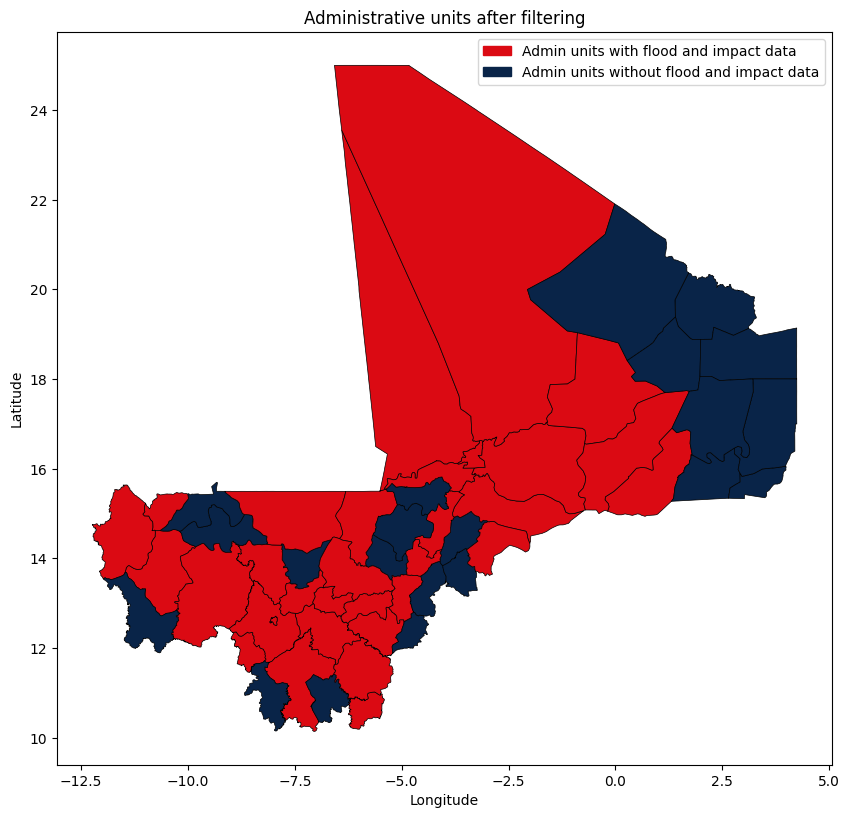

In [867]:
# make a map of all the admin units with at least one flood event
# and impact event in the same year, i.e. all admin units that are
# relevant for the analysis
from typing import Any, Dict


def plot_leftover_admin_units(
        d: Dict[str, Any],
        path: str = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
    ) -> None:
    """ 
    Plots the admin units that are leftover after filtering out

    :param d: dictionary with admin units as keys, the values can be Any
    :param path: path to the shape file
    """
    red, blue = '#DB0A13', '#092448'
    gpd_adm_units_Mali = analyse.get_shape_file(path).to_crs('EPSG:4326')
    gpd_adm_units_Mali['col'] = gpd_adm_units_Mali['ADM2_PCODE'].apply(
        lambda x: red if x in d else blue
    )
    fig, ax = plt.subplots(figsize = (10, 10))
    gpd_adm_units_Mali.plot(
        ax = ax, color = gpd_adm_units_Mali['col'], edgecolor = 'black', linewidth = 0.5
    )
    red_patch = Patch(color = red, label = 'Admin units with flood and impact data')
    blue_patch = Patch(color = blue, label = 'Admin units without flood and impact data')
    plt.legend(handles = [red_patch, blue_patch], loc = 'upper right')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Administrative units after filtering')
    plt.show()


# plot_leftover_admin_units(dict_flood_events_final)
plot_leftover_admin_units(dict_impact_events_final)

In [899]:
def combine_dict_events_to_df(d_events: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Combine the dictionary of events to a single dataframe

    :param d_events: dictionary with events
    :return: dataframe with all events
    """
    if not d_events:
        return pd.DataFrame(columns = ['flood_start', 'flood_end', 'admin_unit'])
    
    events_list = []
    for admin_unit, df in d_events.items():
        df = df.copy()
        if 'admin_unit' not in df.columns:
            df['admin_unit'] = admin_unit
        events_list.append(df)
    df = pd.concat(events_list, ignore_index = True)
    df['flood_start'] = pd.to_datetime(df['flood_start'])
    df['flood_end'] = pd.to_datetime(df['flood_end'])
    
    return df[['flood_start', 'flood_end', 'admin_unit']]


def calculate_metrics(d_metrics: Dict[str, Dict[str, int]]) -> pd.DataFrame:
    """
    Calculate the performance metrics from the metrics dictionary;
    metrics:
    - probability of detection (POD): TP / (TP + FN)
    - false alarm ratio (FAR): FP / (TP + FP)
    - precision: TP / (TP + FP)
    - recall: TP / (TP + FN)
    - f1-score: 2 * (precision * recall) / (precision + recall)

    :param d_metrics: dictionary with metrics per admin unit
    :return: dataframe with metrics
    """
    metrics_list = []       # init storages
    total_TP, total_FP, total_FN = 0, 0, 0

    for admin_unit, metrics in d_metrics.items():
        TP = metrics['TP']
        FP = metrics['FP']
        FN = metrics['FN']
        total_TP += TP
        total_FP += FP
        total_FN += FN
                            # calculate metrics
        POD = TP / (TP + FN) if TP + FN > 0 else 0
        FAR = FP / (TP + FP) if TP + FP > 0 else 0
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
                            # store metrics
        metrics_list.append({
            'admin_unit': admin_unit,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'POD': POD,	
            'FAR': FAR,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
                            # calculate total metrics
    total_POD = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
    total_FAR = total_FP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
    total_precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
    total_recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
    total_f1 = 2 * (total_precision * total_recall) / (total_precision + total_recall) if \
        total_precision + total_recall > 0 else 0
                            # store total metrics at first index (0th)
    metrics_list.insert(0, {
        'admin_unit': 'total',
        'TP': total_TP,
        'FP': total_FP,
        'FN': total_FN,
        'POD': total_POD,
        'FAR': total_FAR,
        'precision': total_precision,
        'recall': total_recall,
        'f1': total_f1	
    })

                            # round floats to 3 decimals 
    for metric in metrics_list:
        for key, value in metric.items():
            if isinstance(value, float):
                metric[key] = np.round(value, 3)

    return pd.DataFrame(metrics_list)


def add_admin_unit_name_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a column to a DataFrame with the Cercle name based on the 
    pcode in the 'admin_unit' column

    :param df: DataFrame with 'admin_unit' column
    :return: DataFrame with added 'admin_unit_NAME' column
    """
    with open('../data/mappings/PCODE_to_Cercle.json', 'r') as f:
        mapping = json.load(f)
    df['admin_unit_NAME'] = df['admin_unit'].apply(lambda x: mapping.get(x, None))
    return df


def match_events_and_get_metrics(
        d_flood_events, d_impact_events, action_lifetime: int = 10
) -> Dict[str, int]:
    """
    Matches flood events to impact events and calculates performance metrics;
    it calculates the following metrics per administrative unit:
    - True Positives (TP): the number of correctly predicted flood events;
    - False Positives (FP): the number of incorrectly predicted flood events; and
    - False Negatives (FN): the number of missed flood events,
    and returns them as a dictionary with admin unit as key, metrics as value.

    :param d_flood_events: dictionary with flood events
    :param d_impact_events: dictionary with impact events
    :param action_lifetime: margin of error for comparison of dates (or could
                            also be called, in a practical sense, the action lifetime)
    :return: df with total and per unit metrics (through helper function)
    """
                            # convert the event dictionaries back to dataframes
    df_flood_events = combine_dict_events_to_df(d_flood_events)
    df_impact_events = combine_dict_events_to_df(d_impact_events)
    metrics = {}
                            # get the set of unique administrative units from
                            # the flood and impact events, although they should
                            # be the same, we take the union anyway
    admin_units = set(df_flood_events['admin_unit']).union(set(df_impact_events['admin_unit']))
    for admin_unit in admin_units:
                            # zero-init metrics
        TP, FP, FN = 0, 0, 0
                            # get the flood and impact events for the admin unit
        events_pred = \
            df_flood_events[df_flood_events['admin_unit'] == admin_unit].reset_index(drop = True)
        events_true = \
            df_impact_events[df_impact_events['admin_unit'] == admin_unit].reset_index(drop = True)
                            # check if there are any events for the admin unit, if not
                            # we can skip the calculation and add metrics immediately;
                            # if no events at all, all metrics are zero
        if events_pred.empty and events_true.empty:
            metrics[admin_unit] = {'TP': TP, 'FP': FP, 'FN': FN}
            continue        # if no predicted events, all true events are false negatives
        if events_pred.empty:
            metrics[admin_unit] = {'TP': TP, 'FP': FP, 'FN': events_true.shape[0]}
            continue        # if no true events, all predicted events are false positives
        if events_true.empty:
            metrics[admin_unit] = {'TP': TP, 'FP': events_pred.shape[0], 'FN': FN}
                            # convert the events to intervals for comparison, with
                            # closed as 'both' and add margin of error for the preds:
                            # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
        intervals_pred = events_pred.apply(
            lambda row: pd.Interval(row['flood_start'] - pd.Timedelta(days = action_lifetime),
                                    row['flood_end'] + pd.Timedelta(days = action_lifetime),
                                    closed = 'both'), axis = 1)
        intervals_true = events_true.apply(
            lambda row: pd.Interval(row['flood_start'],
                                    row['flood_end'],
                                    closed = 'both'),axis = 1)
        
                            # sets to keep track of matched events and avoid double counting;
                            # loop over the predicted events and check if they
                            # match with the true events, and update the metrics
                            # (matched_pred is unused, but might be useful later)
        matched_pred = set()
        matched_true = set()
        for idx_pred, interval_pred in intervals_pred.items():
                            # set flag to False
            is_match = False
                            # look for overlap of prediction with an impact event
            for idx_imp, interval_imp in intervals_true.items():
                            # skip if event already matched (although this
                            # wouldn't be triggered in practice)
                if idx_imp in matched_true:
                    continue
                            # if overlap, update metrics and set flag to True
                if interval_pred.overlaps(interval_imp):
                    TP += 1
                    matched_pred.add(idx_pred)
                    matched_true.add(idx_imp)
                    is_match = True
                            # stop looking for impact events once a match is found;
                            # the question is whether to do this yes/no. Will discuss on Monday
                    # break
                            # no match found, so false positive is added
            if not is_match:
                FP += 1
                            # any impact events not matched are false negatives
        for idx_imp in intervals_true.index:
            if idx_imp not in matched_true:
                FN += 1
                            # store the metrics for the admin unit
        metrics[admin_unit] = {'TP': TP, 'FP': FP, 'FN': FN}

    return add_admin_unit_name_column(calculate_metrics(metrics))


def export_results(
        df: pd.DataFrame, ct: str, lt: int, th: int
    ) -> None:
    """ 
    Simple function that exports the results df in correct name format
    
    :param df: DataFrame with results
    :param ct: comparison type (e.g. 'IMPACT')
    :param lt: lead time in days (e.g. 7)
    :param th: threshold (e.g. 5)
    """
    if th in [95, 98, 99]:
        th_str = f'{th}pc'
    else:
        th_str = f'{th}rp'
    df.to_csv(
        f'../data/results/GFH_vs_{ct}_{lt * 24}lt_{th_str}.csv'
    )

In [869]:
# We can now calculate the performance of the model by comparing the
# flood events to the impact events, and we will do this by calculating
# the following metrics:
# - True Positives (TP): the number of correctly predicted flood events;
# - False Positives (FP): the number of incorrectly predicted flood events; and
# - False Negatives (FN): the number of missed flood events,
# and with these a bunch of other metrics such as:
# - Precision: TP / (TP + FP)
# - Recall: TP / (TP + FN)
# - F1-score: 2 * Precision * Recall / (Precision + Recall)
# - POD (Probability of Detection): TP / (TP + FN)
# - FAR (False Alarm Rate): FP / (TP + FP)

# margin of error for the comparison of dates; argumentation for this
# can be that the impact data is inexact and that for practical preparation-
# wise purposes, a little margin of error does not make a big difference
action_lifetime = 10 # also called the margin of error
df_metrics = match_events_and_get_metrics(dict_flood_events_final,
                                          dict_impact_events_final,
                                          action_lifetime)
# note that when action_lifetime is set to an arbitrarily large number such as
# 10000, you'd expect only true positives, but that's not the case, since there
# might be impact events for which *the* threshold is not passed within those
# 10000 days, i.e. when the threshold is so high it is not passed within the timeframe
inevitable_FNs = sum([len(dict_impact_events_final[admin_unit]) for admin_unit in \
                      dict_impact_events_final.keys() if admin_unit not in dict_flood_events_final])
print(f'Admin units with impact data without a flood event for threshold {THRESHOLD} is',
      len(dict_impact_events_final.keys()) - len(dict_flood_events_final.keys()),
      f'\nleading to {inevitable_FNs} inevitable False Negatives')

Admin units with impact data without a flood event for threshold 99 is 11 
leading to 30 inevitable False Negatives


In [870]:
# print all keys of flood evetns and impact evetns and sort them
print(sorted(dict_flood_events_final.keys()))
print(sorted(dict_impact_events_final.keys()))


['ML0103', 'ML0105', 'ML0202', 'ML0203', 'ML0204', 'ML0205', 'ML0206', 'ML0207', 'ML0301', 'ML0302', 'ML0304', 'ML0305', 'ML0401', 'ML0402', 'ML0405', 'ML0406', 'ML0503', 'ML0504', 'ML0604', 'ML0701', 'ML0901']
['ML0101', 'ML0103', 'ML0105', 'ML0107', 'ML0202', 'ML0203', 'ML0204', 'ML0205', 'ML0206', 'ML0207', 'ML0301', 'ML0302', 'ML0304', 'ML0305', 'ML0401', 'ML0402', 'ML0404', 'ML0405', 'ML0406', 'ML0503', 'ML0504', 'ML0505', 'ML0506', 'ML0601', 'ML0602', 'ML0603', 'ML0604', 'ML0605', 'ML0701', 'ML0702', 'ML0703', 'ML0901']


In [871]:
export_results(df_metrics, COMP_TYPE, LEAD_TIME, THRESHOLD)
print(df_metrics)

   admin_unit  TP  FP   FN    POD    FAR  precision  recall     f1  \
0       total   6  19  104  0.055  0.760      0.240   0.055  0.089   
1      ML0504   0   1    3  0.000  1.000      0.000   0.000  0.000   
2      ML0605   0   0    4  0.000  0.000      0.000   0.000  0.000   
3      ML0107   0   0    2  0.000  0.000      0.000   0.000  0.000   
4      ML0701   0   1    1  0.000  1.000      0.000   0.000  0.000   
5      ML0402   1   0    4  0.200  0.000      1.000   0.200  0.333   
6      ML0103   0   1    3  0.000  1.000      0.000   0.000  0.000   
7      ML0901   1   2    9  0.100  0.667      0.333   0.100  0.154   
8      ML0105   0   1    1  0.000  1.000      0.000   0.000  0.000   
9      ML0603   0   0    2  0.000  0.000      0.000   0.000  0.000   
10     ML0505   0   0    3  0.000  0.000      0.000   0.000  0.000   
11     ML0204   0   1    2  0.000  1.000      0.000   0.000  0.000   
12     ML0202   0   1    6  0.000  1.000      0.000   0.000  0.000   
13     ML0506   0   

In [872]:
import matplotlib.dates as mdates
import matplotlib.patches as patches
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict


def prepare_plot_df(d_events: Dict[str, pd.DataFrame], e_type: str) -> pd.DataFrame:
    """
    Combines events from dictionary of events (i.e. flood or impact events)
    to a DataFrame, with, as addition (and opposed to prior functions), an
    extra column with 'event_type' to distinguish between flood and impact,
    which is handy for plotting

    :param d_events: dictionary with events
    :param e_type: type of events (flood or impact)
    :return: dataframe with all events
    """
    events = []
    for au, df in d_events.items():
        df = df.copy()
        df['admin_unit'] = au
        df['event_type'] = e_type
        events.append(df)
                        # combine, ensure datetime columns, return
    df = pd.concat(events, ignore_index = True)
    df['flood_start'] = pd.to_datetime(df['flood_start'])
    df['flood_end'] = pd.to_datetime(df['flood_end'])

    return df


def get_plot_df_for_admin_unit(
        d_floods: Dict[str, pd.DataFrame], d_impacts: Dict[str, pd.DataFrame], admin_unit: str
    ) -> pd.DataFrame:
    """ 
    Takes the dictionary of events and the dictionary of flood events,
    combines them to a DataFrame with prepare_plot_df(), and subsets
    for admin unit, giving a DataFrame with all events for that admin unit

    :param d_floods: dictionary with events
    :param d_impacts: dictionary with flood events
    :param admin_unit: administrative unit
    :return: dataframe with all events for admin unit
    """
    if not admin_unit in d_floods.keys() or not admin_unit in d_impacts.keys():
        print(f'Cannot continue with plot, {admin_unit} not in events')
        return None
    
    df_floods = prepare_plot_df(d_floods, 'flood')
    df_impacts = prepare_plot_df(d_impacts, 'impact')
    df_all_events = pd.concat([df_floods, df_impacts],
                               ignore_index = True).sort_values(['admin_unit', 'flood_start'])
    df_all_events = df_all_events[df_all_events['admin_unit'] == admin_unit]

    return df_all_events


def hex_to_rgb(c: str) -> tuple:
    """
    Converts a hex color string to RGB tuple

    :param c: hex color string (e.g., '#DB0000')
    :return: tuple of (R,G,B) in 0 - 255 range
    """
    return tuple(int(c.lstrip('#')[idx : idx + 2], 16) for idx in (0, 2, 4))


def get_opacity_adjusted_hex(c: str, o: float = 1) -> str:
    """ 
    Adjusts a colour for a given opactiy level:
    https://graphicdesign.stackexchange.com/questions/126031/
    make-color-transparent-and-keep-the-same-visual-color

    :param c: colour in hex
    :param o: opacity level (0 - 1)
    :return: adjusted colour in hex
    """
    foreground_c = hex_to_rgb(c)
    background_c = (255, 255, 255) # white

    return '#{:02x}{:02x}{:02x}'.format(*tuple(
        max(0, min(255, int((fg - (1 - o) * bg) / o)))
        for fg, bg in zip(foreground_c, background_c)
    ))


def plot_flood_and_impact_events(
    d_floods: Dict[str, pd.DataFrame], d_impacts: Dict[str, pd.DataFrame],
    ds_reforecast: xr.Dataset,
    admin_unit: str, start_time: str, end_time: str, threshold: float, action_lifetime: int = 10
) -> None:
    """ 
    Timeseries met discharge van FloodHub (en GloFAS) met transparante
    boxes(/lijnen bij 1-daagse events) voor events, plus ook return
    periods als y. Geeft impressie van wat de modellen doen, wanneer ze
    triggeren, alsook hoe ze (niet) matchen met impact
    
    :param d_floods: dictionary with flood events
    :param d_impacts: dictionary with impact events
    :param ds_reforecast: reforecast dataset
    :param admin_unit: administrative unit
    :param start_time: start time of the plot
    :param end_time: end time of the plot
    :param threshold: return period threshold
    :param action_lifetime: margin of error/action lifetime for comparison of dates
    """
    df = get_plot_df_for_admin_unit(d_floods, d_impacts, admin_unit)
    if df is None:
        return

    fig, ax = plt.subplots(figsize = (20, 6))
    alpha = 0.5                 # transparency
    red, blue = '#DB0A13', '#092448'
    red = get_opacity_adjusted_hex(red, alpha)
    blue = get_opacity_adjusted_hex(blue, alpha)
    
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    
    ds_subset = ds_reforecast.streamflow.sel(issue_time = slice(start_time, end_time))
    ax.plot(ds_subset.actual_date, ds_subset.values, color = 'black', linewidth = 2)
    thr_string = f'RP_{threshold}' if threshold not in [95, 98, 99] else f'pc_{threshold}th'
    ax.axhline(y = ds_reforecast.attrs[thr_string], color = 'orange',
               label = f'{threshold}-yr return period', linestyle = '--'
    )
    # analyse.add_return_periods(ax, ds_return_periods, [5], True)

    # if event is of type impact, add margin of error to start and end
    for idx, row in df.iterrows():
                                # subtract one day because of indexing error of the boxes
        start = row['flood_start'] - pd.Timedelta(days = 1)
        end = row['flood_end'] - pd.Timedelta(days = 1)
                                # add action lifetime to the flood events
        if row['event_type'] == 'flood':
            start = start - pd.Timedelta(days = action_lifetime)
            end = end + pd.Timedelta(days = action_lifetime)
                                # inclusive duration
        duration = (end - start).days + 1
                                # add rectangle to plot for each event
        rect = patches.Rectangle(
                                # (x, y) position, starting from y = 0
            (mdates.date2num(start), 0),
            duration,           # width in days
            ax.get_ylim()[1],   # height from y = 0 to max y (spans entire height)
            facecolor = red if row['event_type'] == 'flood' else blue,
            alpha = alpha
        )
        ax.add_patch(rect)
    
    ax.set_xlim(start_time, end_time)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate() 
    ax.set_xlabel('time')
    ax.set_ylabel(r'discharge ($\mathrm{m}^3/\mathrm{s}$)')

    legend_handles = [
        patches.Patch(color = blue, alpha = alpha, label = 'impact events'),
        patches.Patch(color = red, alpha = alpha, label = 'forecasted events'),
        plt.Line2D([0], [0], color = 'black', linewidth = 2, label = 'forecasted discharge')
    ]
    ax.legend(handles = legend_handles, loc = 'upper right')
    
    plt.tight_layout()
    plt.show()

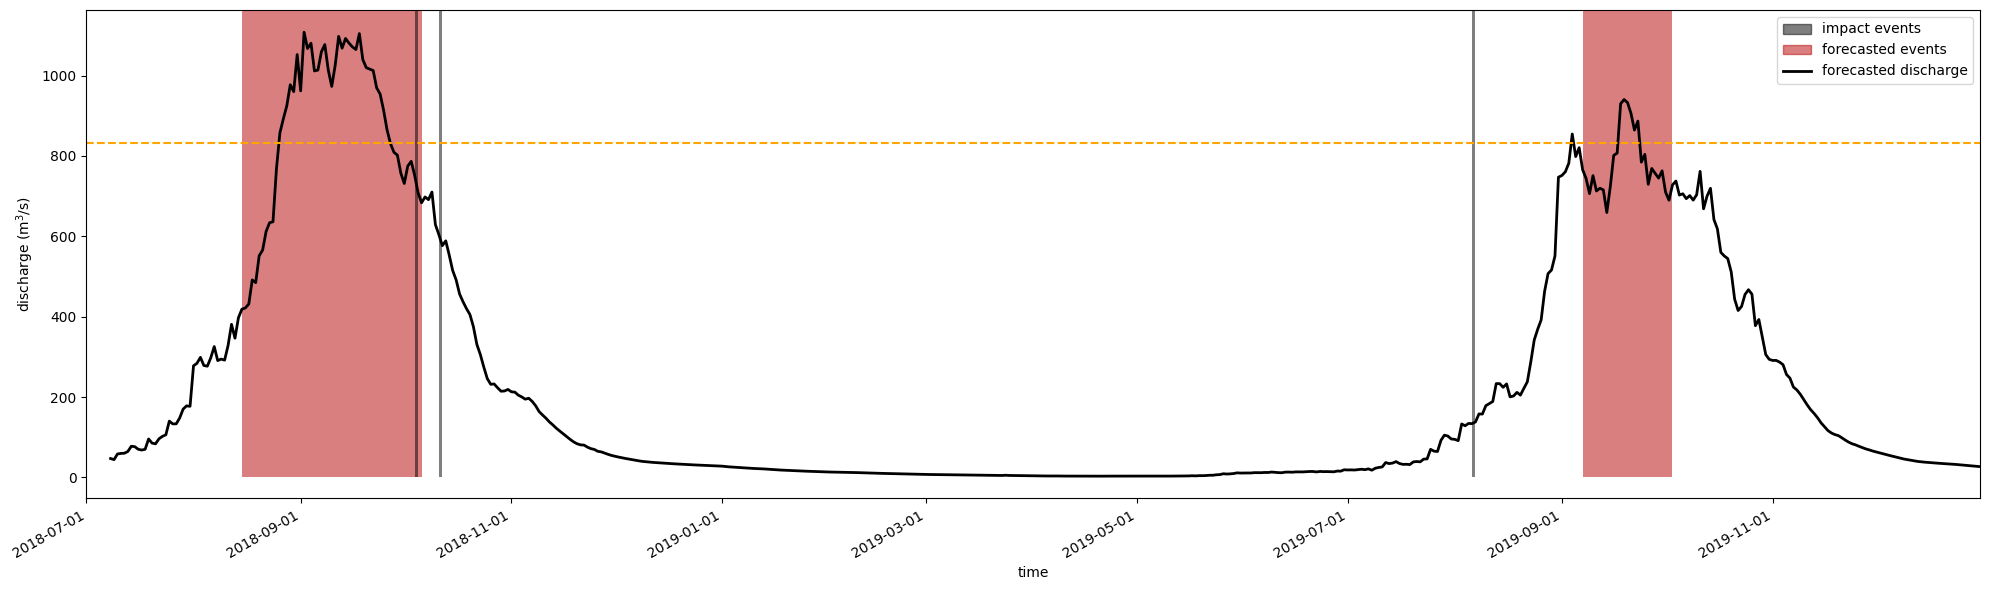

In [873]:
au_plot = 'ML0305'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2018-07-01', '2019-12-31', THRESHOLD)

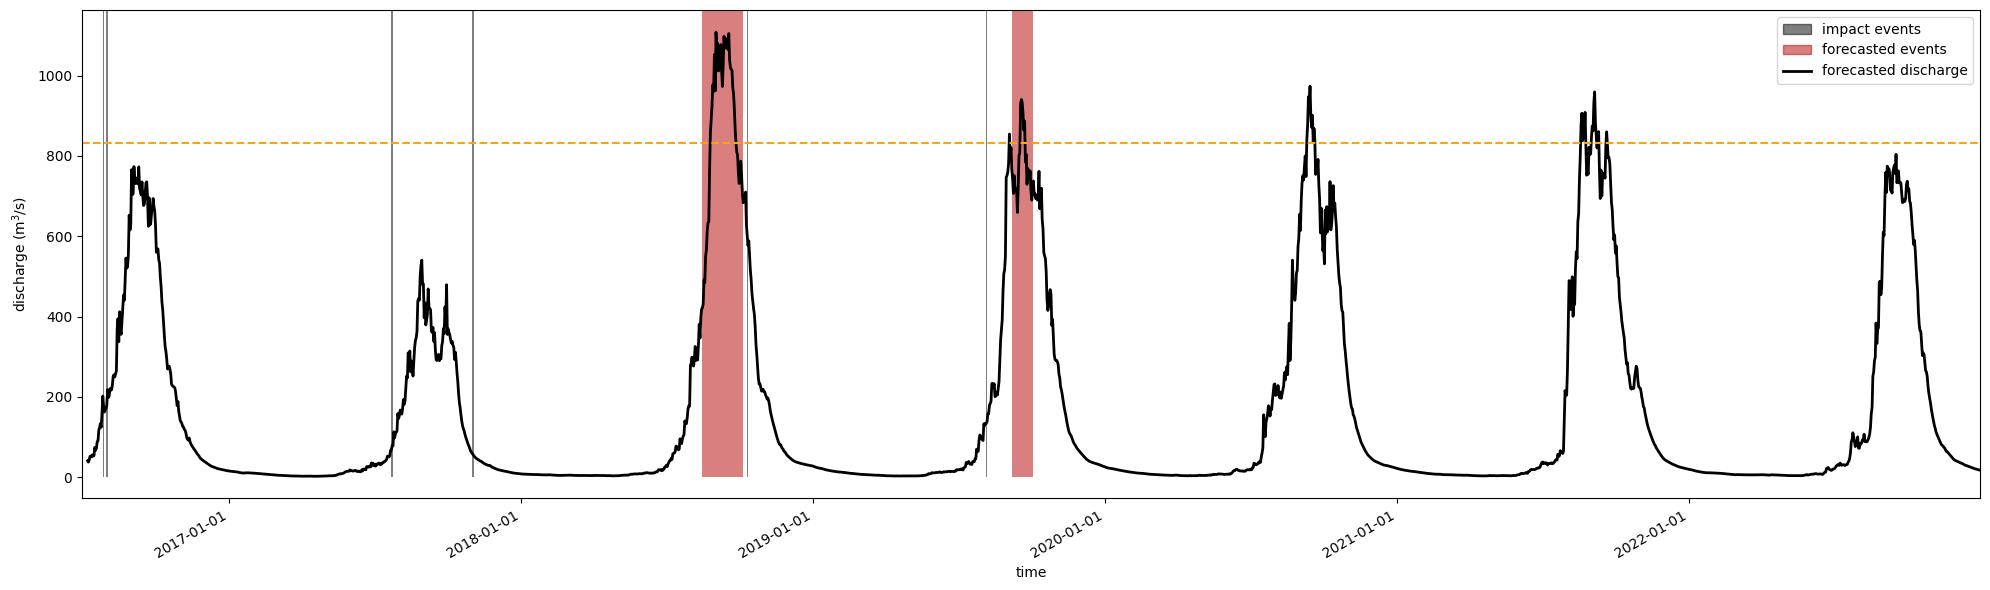

In [874]:
au_plot = 'ML0305'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

In [875]:
# make a list of admin units:
admin_units = list(dict_flood_events_final.keys())
print(admin_units)

['ML0103', 'ML0105', 'ML0202', 'ML0203', 'ML0204', 'ML0205', 'ML0206', 'ML0207', 'ML0301', 'ML0302', 'ML0304', 'ML0305', 'ML0401', 'ML0402', 'ML0405', 'ML0406', 'ML0503', 'ML0504', 'ML0604', 'ML0701', 'ML0901']


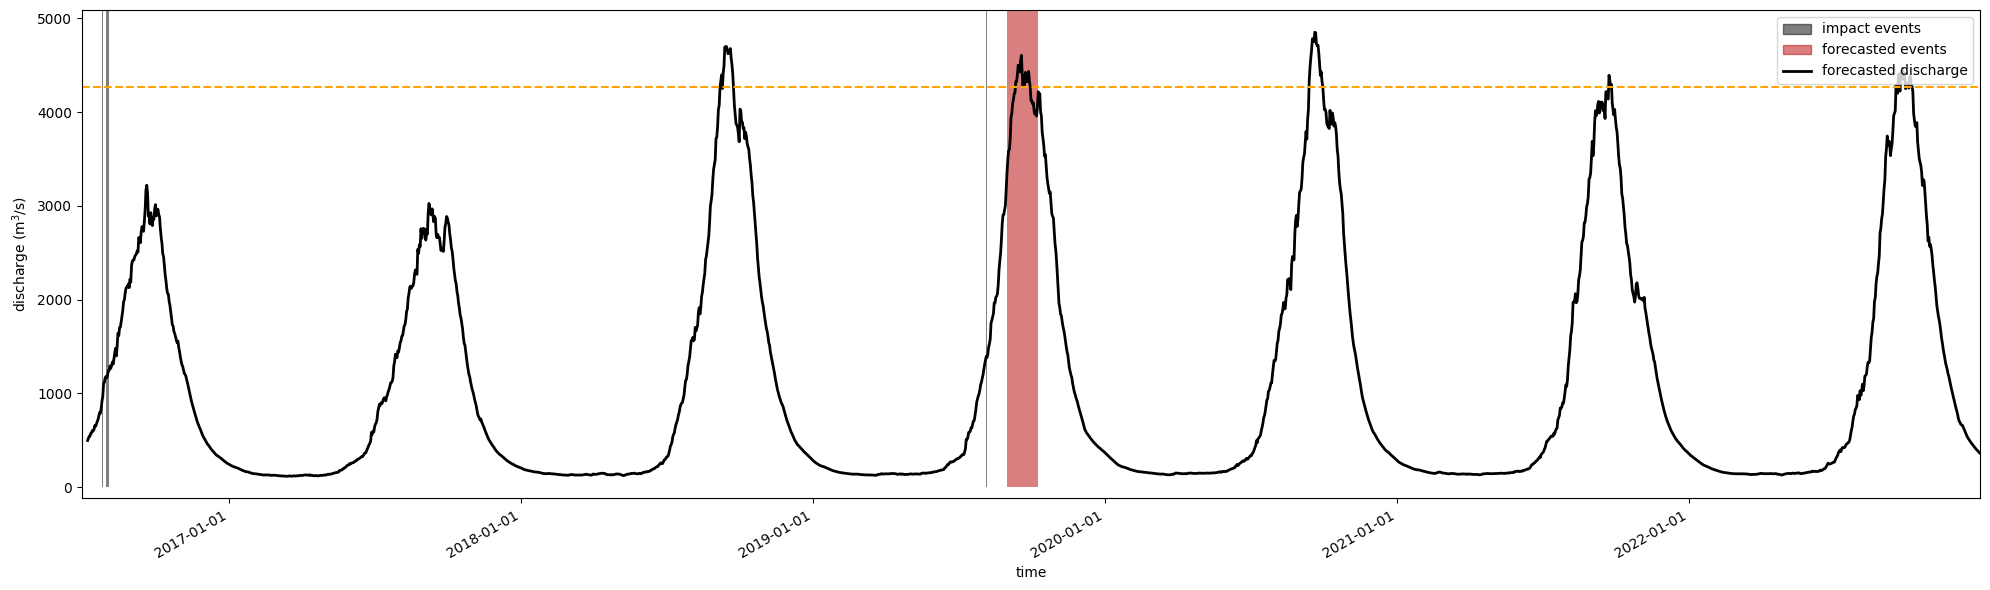

In [876]:
au_plot = 'ML0206'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

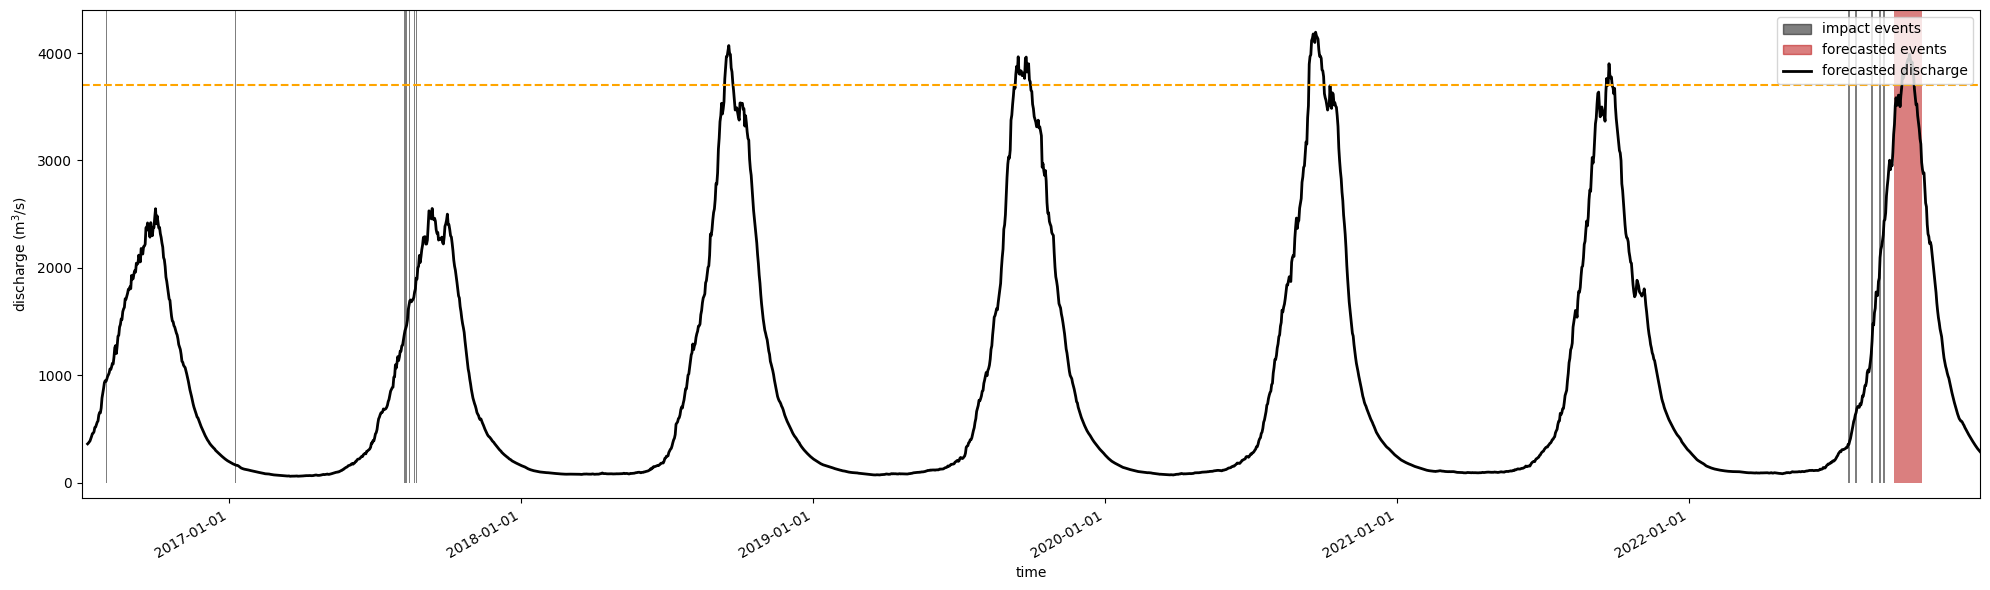

In [877]:
au_plot = 'ML0406'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

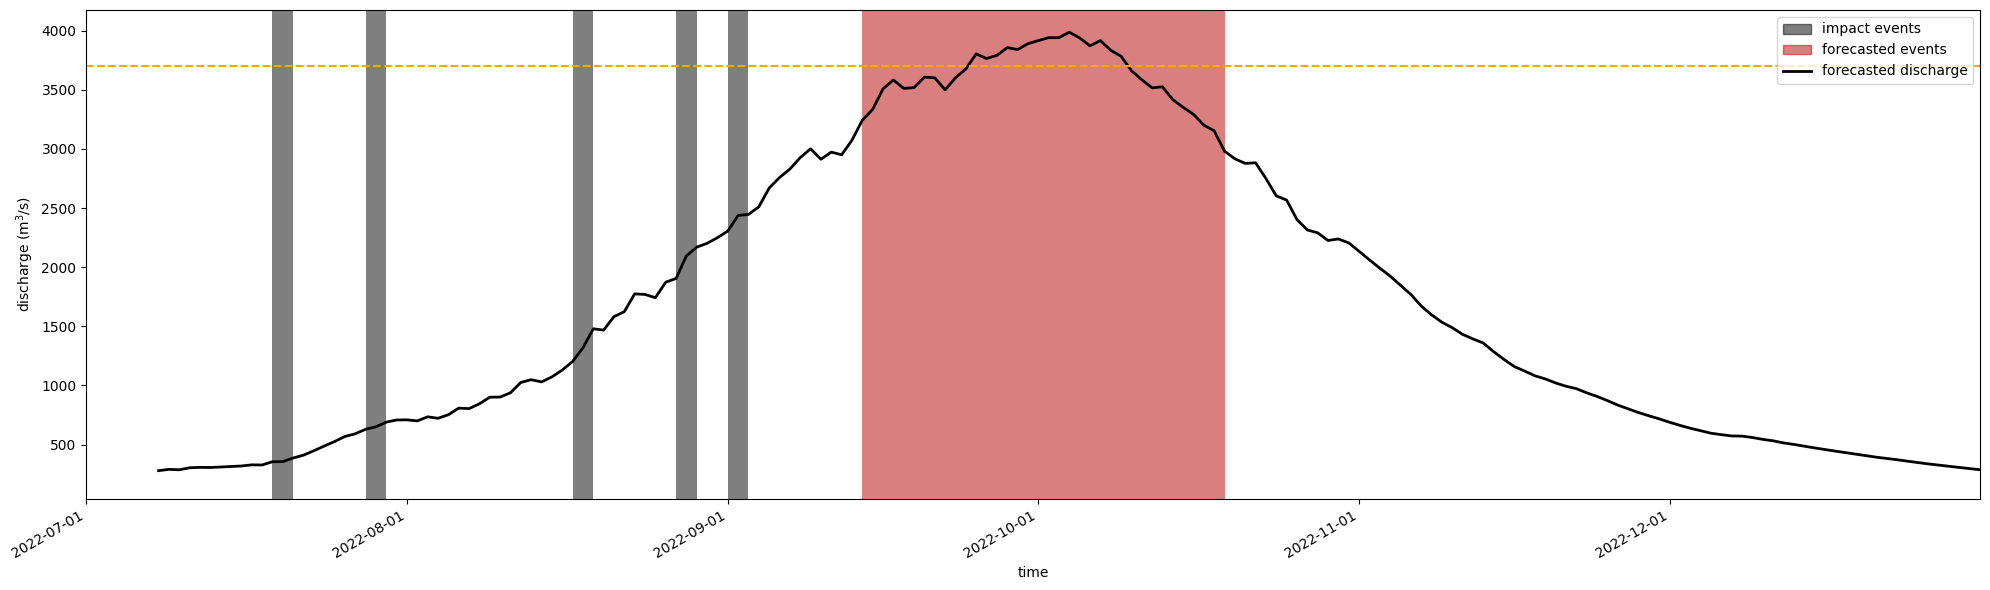

In [878]:
au_plot = 'ML0406'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2022-07-01', '2022-12-31', THRESHOLD)

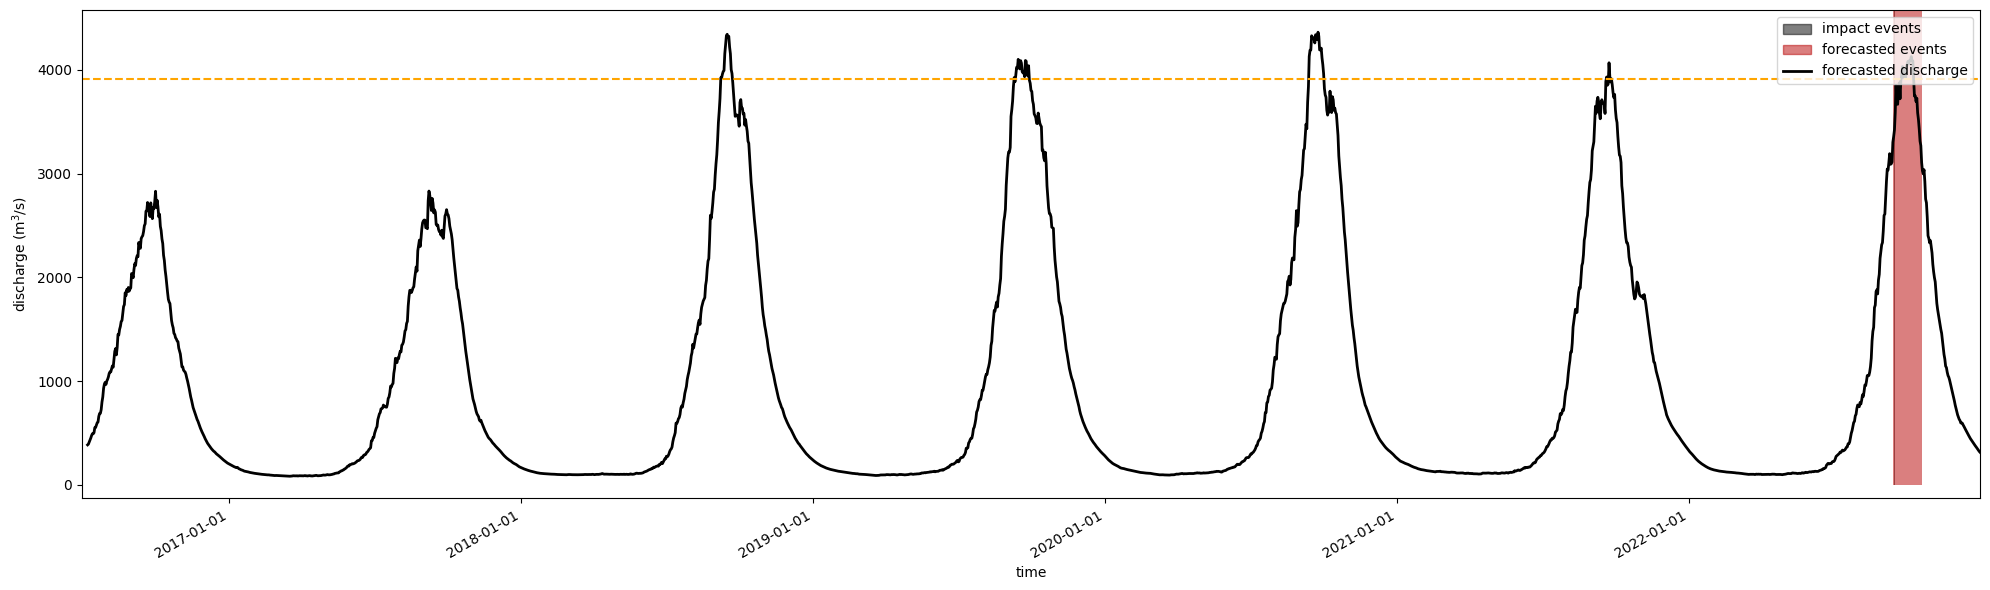

In [879]:
au_plot = 'ML0401'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

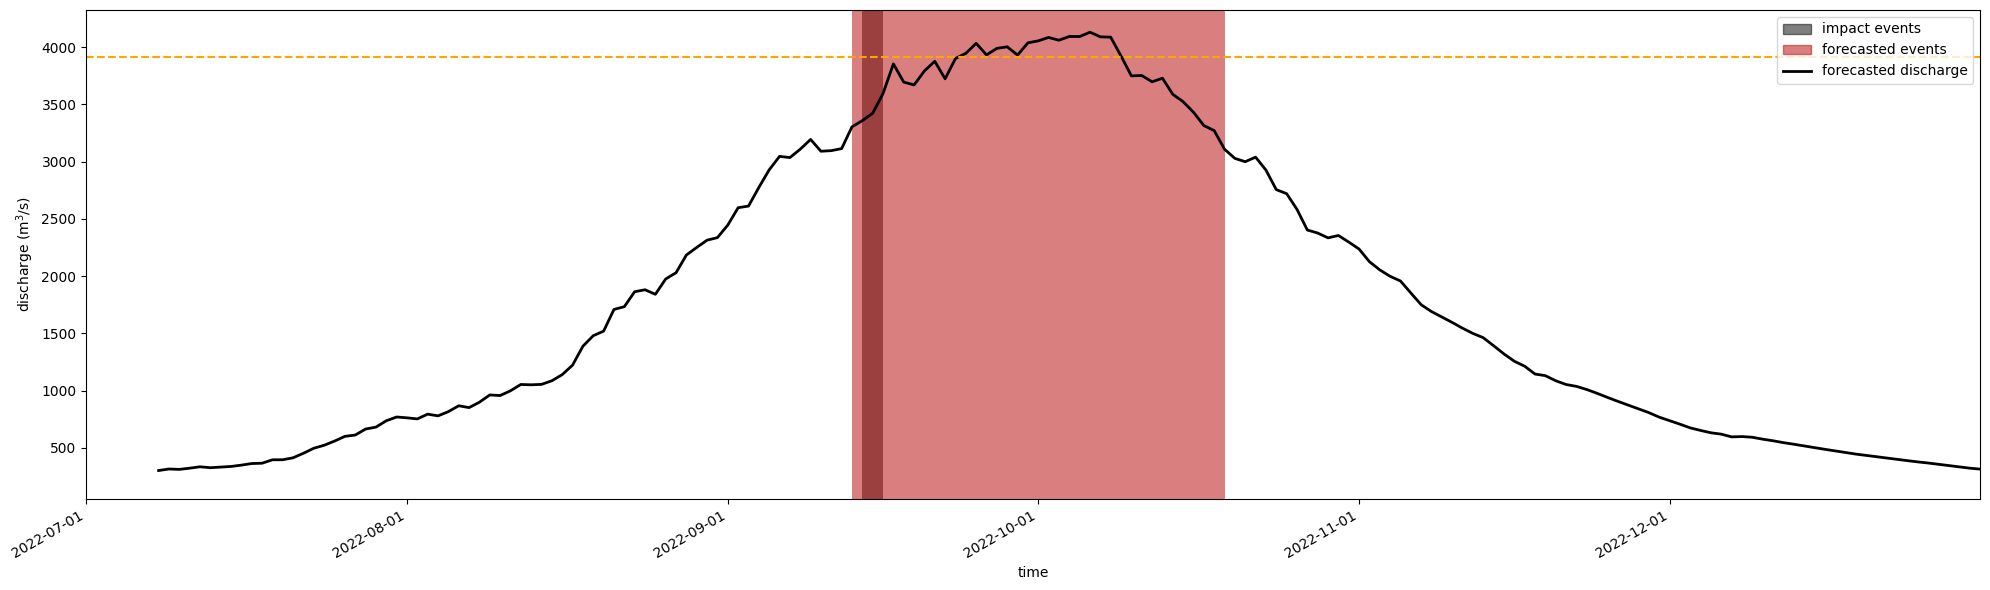

In [880]:
au_plot = 'ML0401'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2022-07-01', '2022-12-31', THRESHOLD)

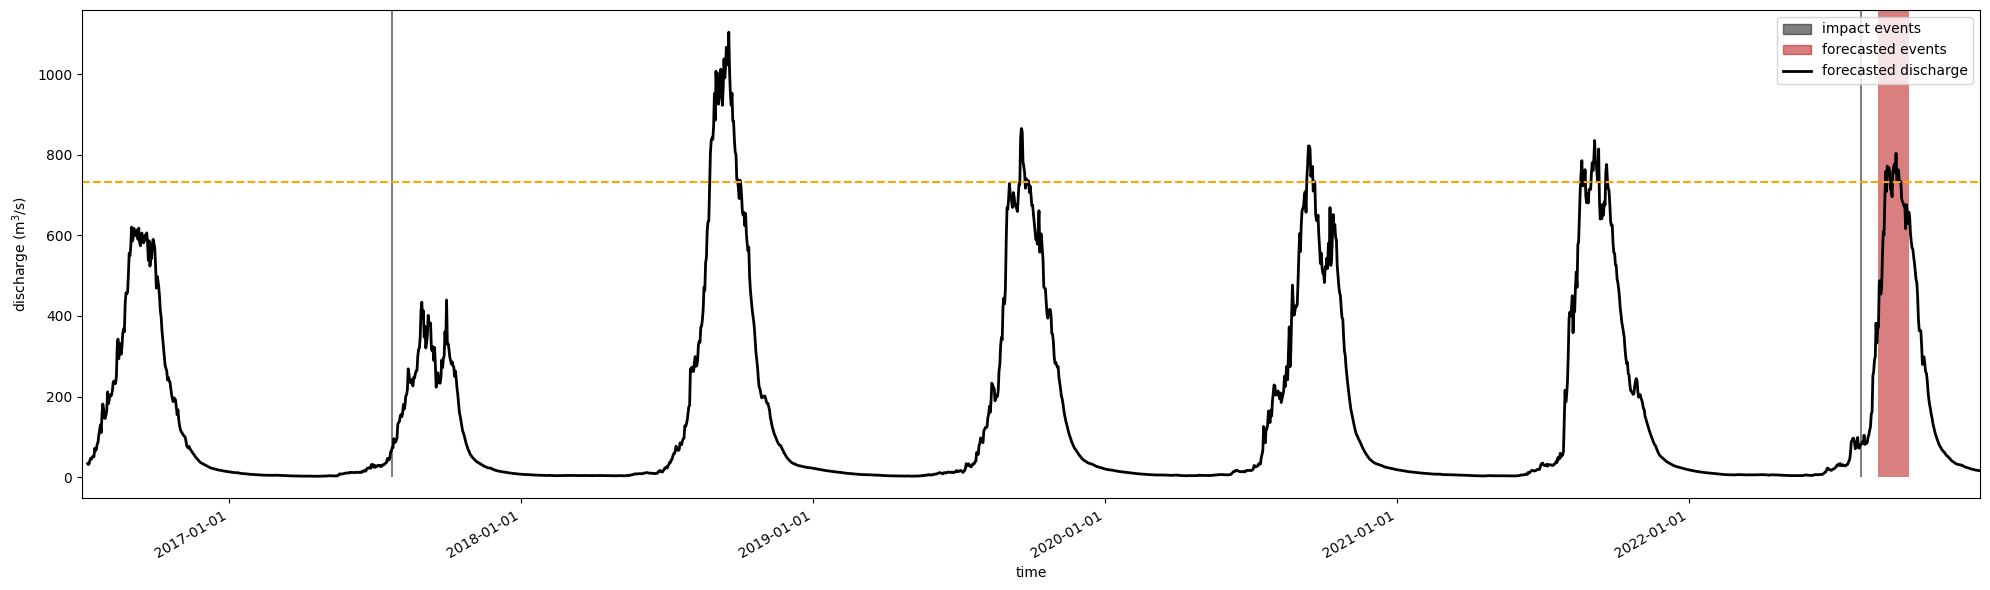

In [881]:
au_plot = 'ML0301'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

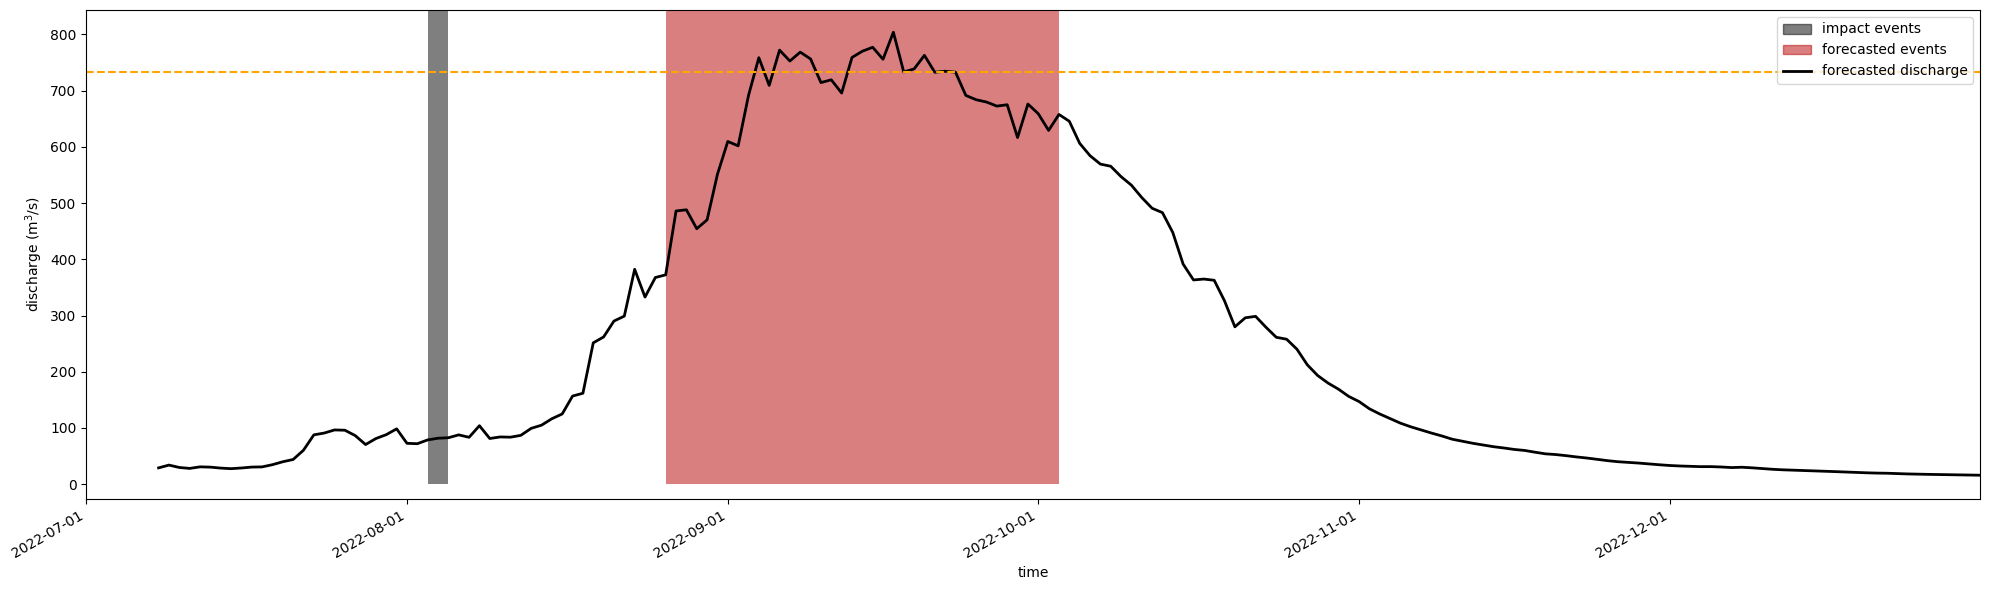

In [882]:
au_plot = 'ML0301'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2022-07-01', '2022-12-31', THRESHOLD)

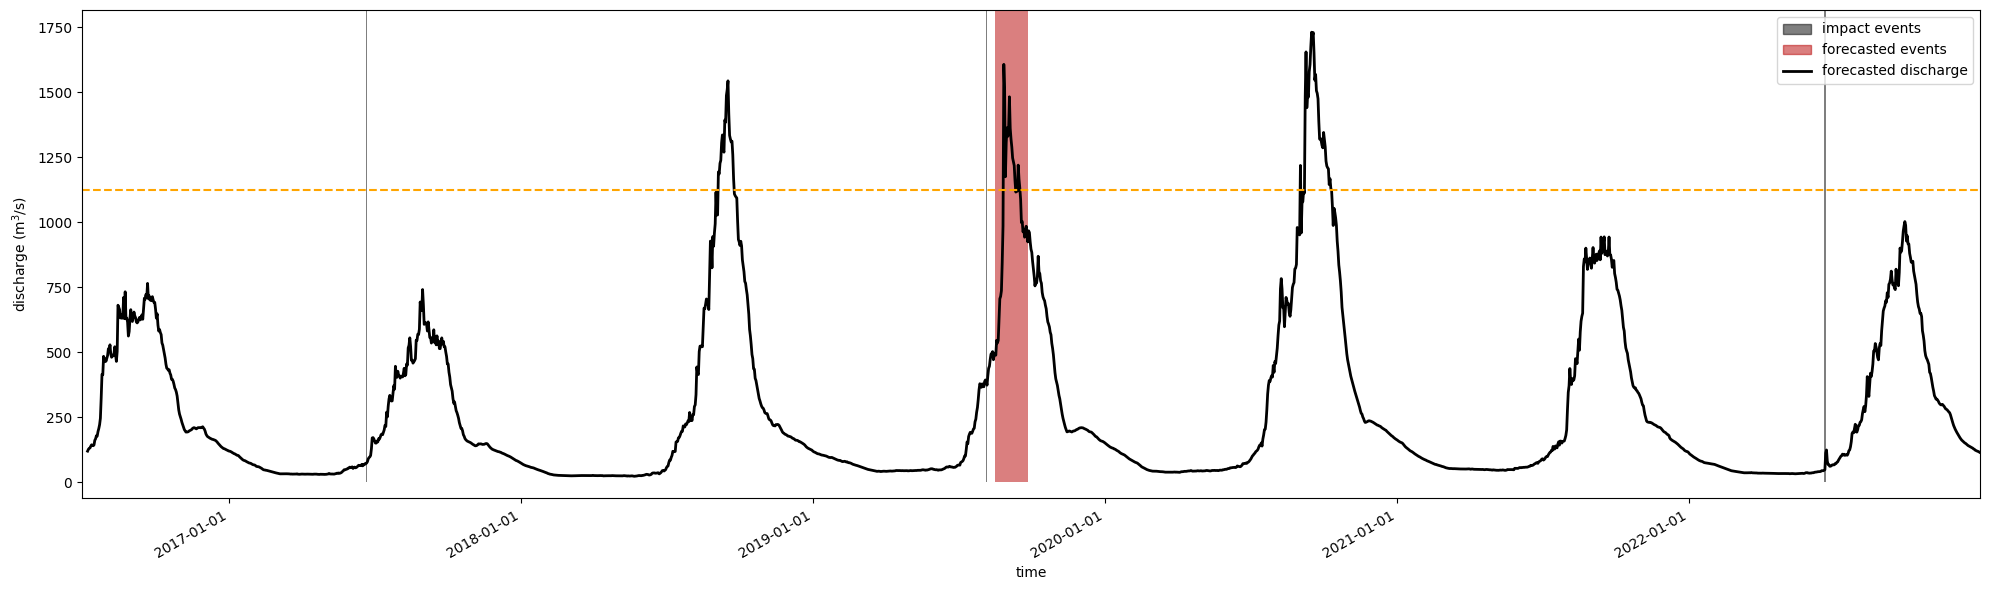

In [883]:
au_plot = 'ML0103'
plot_flood_and_impact_events(dict_flood_events_final, dict_impact_events_final,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

### **Automatically generate all metrics**

The cell below generates all metrics for the given configs, and is commented out by default (recommended)

In [900]:
comp_types = ['IMPACT', 'OBSERVATION']
thresholds = [1.5, 2, 5, 7, 10, 20, 95, 98, 99]
# thresholds = [20, 95, 98, 99]
lead_times = [1, 2, 3, 4, 5, 6, 7]


for th in thresholds:
    for lt in lead_times:
        THRESHOLD = th
        LEAD_TIME = lt
        print('\n\n\t\tCalculating metrics for threshold', THRESHOLD, 'and lead time', LEAD_TIME, '\n\n')

        # PREPARE DATA
        dict_datasets = assign_admin_unit_to_datasets(dict_datasets)
        dict_datasets_au, dict_return_periods_au = aggregate_or_load_per_admin_unit(
            dict_datasets, LEAD_TIME
        )
        df_impact_data = pd.read_csv(
            '../data/impact_data/impact_data_Mali.csv', sep = ',', header = 0, encoding = 'utf-8')

        # FLOOD & IMPACT EVENTS
        dict_flood_events_per_admin = create_flood_events(dict_datasets_au, True, THRESHOLD)
        export_dict_flood_events_to_csv(dict_flood_events_per_admin, THRESHOLD, LEAD_TIME)

        dict_impact_events = process_impact_data_to_events(df_impact_data, False)
                                    # determine available units and earliest and latest dates
        available_admin_units = set(dict_datasets_au.keys())
        earliest_date, latest_date = determine_min_max_date_of_dataset(dict_datasets_au)
        dict_impact_events_final, _ = subset_events_on_unit_and_date(
            dict_impact_events, available_admin_units, earliest_date, latest_date)
        export_dict_impact_events_to_csv(dict_impact_events_final)

                                    # use impact data availability to filter flood events
        dict_flood_events_final = filter_flood_events_by_impact_per_year(
            dict_flood_events_per_admin, dict_impact_events_final)
        export_dict_flood_events_to_csv(dict_flood_events_final, THRESHOLD, LEAD_TIME)
        
        # PERFORMANCE METRICS
        df_metrics = match_events_and_get_metrics(dict_flood_events_final,
                                                dict_impact_events_final,
                                                10)
        export_results(df_metrics, COMP_TYPE, LEAD_TIME, THRESHOLD)
        
        print('\n\n\t\tCalculated metrics for threshold', THRESHOLD, 'and lead time', LEAD_TIME, '\n\n')



		Calculating metrics for threshold 1.5 and lead time 1 


Checking if datasets are already loaded...
Loading in datasets...
Loading complete
exporting 246 flood events to csv
exporting 525 impact events to csv
	no impact data found for ML0102
	no impact data found for ML0104
ML0106 impact data discarded due to lack of forecast data
	no impact data found for ML0201
	no impact data found for ML0303
	no impact data found for ML0306
ML0307 impact data discarded due to lack of forecast data
	no impact data found for ML0403
ML0407 impact data discarded due to lack of forecast data
ML0501 impact data discarded due to lack of forecast data
	no impact data found for ML0502
	no impact data found for ML0507
ML0801 impact data discarded due to lack of forecast data
ML0802 impact data discarded due to lack of forecast data
ML0803 impact data discarded due to lack of forecast data
ML1001 impact data discarded due to lack of forecast data
exporting 110 impact events to csv
		ML0101: all flood even